# Restaurant Similarity Score and PECOTA Projection Model

# Data Preparation and Segmentation

## Overview
This code performs the initial data preparation and segmentation for our restaurant financial analysis model.
We're adapting the PECOTA (Player Empirical Comparison and Optimization Test Algorithm) projection system from
baseball analytics and applying it to restaurant financial data. This approach allows us to create similarity
scores between restaurants and make financial projections based on comparable establishments.

## What This Code Does
1. **Data Loading**: Imports the restaurant financial dataset from Google Drive
2. **Date Preprocessing**: Converts date columns to proper datetime format for time-series analysis
3. **Enhanced Segmentation**: Implements a sophisticated restaurant categorization system that:
   - Identifies specific restaurant sub-segments (Fast Casual, Quick Service, Premium Dining, etc.)
   - Uses text analysis of company names and business descriptions
   - Considers financial characteristics like average check size
   - Creates both detailed segments and high-level categories for flexibility in analysis
4. **Segment Distribution**: Displays the distribution of restaurants across different segments

## Why Segmentation Matters
Proper restaurant segmentation is crucial for our similarity model because restaurants within the same segment
tend to have comparable business models, cost structures, and growth patterns. This granular segmentation will
enable more accurate peer comparisons and financial projections in the subsequent modeling steps.

The segmentation approach mimics how baseball analytics groups similar players, allowing us to identify
"comparable restaurants" that can predict financial performance trajectories.

In [10]:
"""
Restaurant Similarity Score and PECOTA Projection Model
Integrating Baseball Analytics with Restaurant Financial Analysis
Enhanced with Segment-Specific Modeling and Robust Missing Data Handling
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from collections import defaultdict
import math
import random
from datetime import datetime
import warnings
import copy
warnings.filterwarnings('ignore')

# Mount Google Drive to access your data
drive.mount('/content/drive')

# Define file path
file_path = '/content/drive/My Drive/Colab Notebooks/Finance Thesis/Restaurant Financial Data.csv'

###########################################
# STEP 1: DATA PREPARATION AND ENHANCED SEGMENTATION
###########################################

# Load restaurant financial data
df = pd.read_csv(file_path)

# Convert date columns
df['datadate'] = pd.to_datetime(df['datadate'], errors='coerce')
df['ipodate'] = pd.to_datetime(df['ipodate'], errors='coerce')

# Define enhanced function to determine restaurant segment with more specific categories
def determine_segment(row):
    """
    Determine restaurant segment based on company name, description, and financial characteristics.
    Enhanced to provide more specific segment categorization.
    """
    name = str(row.get('conm', '')).lower()
    description = str(row.get('busdesc', '')).lower()

    # Fast food indicators - now with sub-segments
    fast_casual_terms = ['fast casual', 'chipotle', 'panera', 'shake shack']
    qsr_terms = ['quick service', 'mcdonald', 'burger king', 'wendys', 'taco bell', 'kfc']
    pizza_terms = ['pizza', 'domino', 'papa john']

    # Fine dining indicators - now with sub-segments
    upscale_casual_terms = ['upscale casual', 'cheesecake factory', 'brio', 'bonefish']
    premium_dining_terms = ['fine dining', 'ruth chris', 'del frisco', 'capital grille', 'morton']

    # Casual dining indicators - now with sub-segments
    family_dining_terms = ['family dining', 'ihop', 'denny', 'cracker barrel']
    bar_grill_terms = ['bar & grill', 'bar and grill', 'applebee', 'chili', 'buffalo wild', 'outback']

    # Specialized segments
    ethnic_terms = ['mexican', 'chinese', 'italian', 'japanese', 'sushi', 'thai']
    cafe_bakery_terms = ['cafe', 'bakery', 'coffee', 'starbucks', 'dunkin']

    # Check average check size if available in data
    avg_check = row.get('avg_check', 0)

    # Check for fast food indicators with sub-segments
    for term in fast_casual_terms:
        if term in name or term in description:
            return 'Fast Casual'

    for term in qsr_terms:
        if term in name or term in description:
            return 'Quick Service'

    for term in pizza_terms:
        if term in name or term in description:
            return 'Pizza Chains'

    # Check for fast food general terms
    if any(term in name or term in description for term in ['fast', 'quick', 'burger', 'chicken', 'drive']):
        return 'Quick Service'  # Default fast food category

    # Check for fine dining indicators with sub-segments
    for term in premium_dining_terms:
        if term in name or term in description:
            return 'Premium Dining'

    for term in upscale_casual_terms:
        if term in name or term in description:
            return 'Upscale Casual'

    # Check for fine dining general terms
    if any(term in name or term in description for term in ['gourmet', 'fine', 'steakhouse', 'premium']):
        return 'Premium Dining'  # Default fine dining category

    # Check for casual dining indicators with sub-segments
    for term in family_dining_terms:
        if term in name or term in description:
            return 'Family Dining'

    for term in bar_grill_terms:
        if term in name or term in description:
            return 'Bar & Grill'

    # Check for specialized segments
    for term in ethnic_terms:
        if term in name or term in description:
            return 'Ethnic Restaurants'

    for term in cafe_bakery_terms:
        if term in name or term in description:
            return 'Cafe & Bakery'

    # Use financial characteristics as additional indicators
    if pd.notna(avg_check):
        if avg_check > 50:
            return 'Premium Dining'
        elif avg_check > 25:
            return 'Upscale Casual'
        elif avg_check > 15:
            return 'Casual Dining'
        else:
            return 'Quick Service'

    # Default to casual dining if no specific indicators
    return 'Casual Dining'

# Assign segments to all companies
df['segment'] = df.apply(determine_segment, axis=1)

# For backward compatibility with the existing model, create a high-level segment
def get_high_level_segment(segment):
    if segment in ['Quick Service', 'Fast Casual', 'Pizza Chains']:
        return 'Fast Food'
    elif segment in ['Premium Dining', 'Upscale Casual']:
        return 'Fine Dining'
    elif segment in ['Casual Dining', 'Family Dining', 'Bar & Grill', 'Ethnic Restaurants', 'Cafe & Bakery']:
        return 'Casual Dining'
    else:
        return 'Casual Dining'  # Default

df['high_level_segment'] = df['segment'].apply(get_high_level_segment)

# View segment distribution
segment_counts = df['segment'].value_counts()
high_level_counts = df['high_level_segment'].value_counts()

print("Detailed restaurant segment distribution:")
print(segment_counts)
print("\nHigh-level restaurant segment distribution:")
print(high_level_counts)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Detailed restaurant segment distribution:
segment
Quick Service         4666
Pizza Chains           336
Premium Dining         191
Ethnic Restaurants     186
Cafe & Bakery          170
Fast Casual            126
Family Dining          115
Upscale Casual          77
Bar & Grill             41
Name: count, dtype: int64

High-level restaurant segment distribution:
high_level_segment
Fast Food        5128
Casual Dining     512
Fine Dining       268
Name: count, dtype: int64


# Data Quality Assessment and Imputation

## Overview
This section of the code addresses one of the most challenging aspects of financial modeling: handling missing or incomplete data. Drawing inspiration from baseball's PECOTA model, we implement sophisticated techniques to assess data quality and impute missing values, which enables more reliable restaurant financial analysis.

## What This Code Does

### 1. Direct and Derived Financial Metrics
First, we define two sets of metrics that form the foundation of our analysis:
- **Direct metrics**: Raw financial data points directly from financial statements (sales, assets, liabilities, etc.)
- **Derived metrics**: Calculated ratios and performance indicators (profit margin, EBITDA margin, asset turnover, etc.)

### 2. Data Quality Assessment
The code implements a comprehensive data quality evaluation system that:
- Assesses completeness of financial metrics for each restaurant
- Examines time series continuity to identify gaps in yearly reporting
- Categorizes companies into quality tiers (EXCLUDE, LIMITED_ANALYSIS, FULL_ANALYSIS)
- Provides a structured way to determine which restaurants have sufficient data for reliable analysis

### 3. Sophisticated Missing Data Imputation
We employ multiple imputation strategies in a hierarchical approach:
- **Time series interpolation/extrapolation**: Uses historical data patterns from the same restaurant
- **Ratio-based imputation**: Leverages known financial relationships (e.g., EBITDA typically ~15% of sales)
- **Segment-specific medians**: Falls back to peer group benchmarks when company-specific data is insufficient

### 4. Segment-Specific Financial Benchmarks
The model incorporates detailed segment-specific financial ratios that reflect the economic realities of different restaurant types:
- Premium dining establishments have higher profit margins (~12% EBIT to sales vs. ~8% for quick service)
- Fast food restaurants typically operate with thinner margins but higher turnover
- Each restaurant sub-segment (Fast Casual, Bar & Grill, etc.) has its own financial profile

### 5. Confidence Scoring
Finally, the code calculates confidence scores for imputed data, providing transparency about the reliability of our financial projections. This helps us appropriately weight different data points in subsequent similarity calculations.

## Why This Matters
High-quality data is the foundation of accurate financial modeling. By implementing these sophisticated imputation techniques, we can include more restaurants in our analysis while maintaining statistical rigor. This approach mirrors how baseball's PECOTA system handles missing player statistics, allowing for more comprehensive comparisons and more accurate projections of future financial performance.

In [11]:
###########################################
# STEP 2: CALCULATE SEGMENT-SPECIFIC MEDIANS
###########################################

# Define direct metrics for analysis
direct_metrics = ['sale', 'at', 'lt', 'ni', 'ebit', 'ebitda', 'cogs', 'xsga',
                 'act', 'lct', 'ppent', 'ppegt', 'dltt', 'dlc']

# Define derived metrics calculations
derived_metrics = [
    # Original metrics
    {'name': 'profit_margin', 'calc': lambda df: df['ni'] / df['sale']},
    {'name': 'ebitda_margin', 'calc': lambda df: df['ebitda'] / df['sale']},
    {'name': 'operating_margin', 'calc': lambda df: df['ebit'] / df['sale']},
    {'name': 'asset_turnover', 'calc': lambda df: df['sale'] / df['at']},
    {'name': 'debt_to_assets', 'calc': lambda df: df['lt'] / df['at']},
    {'name': 'cogs_to_sales', 'calc': lambda df: df['cogs'] / df['sale']},
    {'name': 'sga_to_sales', 'calc': lambda df: df['xsga'] / df['sale']},
    {'name': 'current_ratio', 'calc': lambda df: df['act'] / df['lct']},

    # Advisor-requested metrics
    {'name': 'sales_growth_rate', 'calc': None},  # Will be calculated separately for year-over-year
    {'name': 'gross_margin', 'calc': lambda df: (df['sale'] - df['cogs']) / df['sale']},
    {'name': 'opex_to_revenue', 'calc': lambda df: (df['sale'] - df['cogs'] - df['ebit']) / df['sale']},
    {'name': 'ppe_aging', 'calc': lambda df: df['ppent'] / df['ppegt'] if pd.notna(df['ppegt']) and df['ppegt'] > 0 else None},
    {'name': 'leverage', 'calc': lambda df: (df['dltt'] + df['dlc']) / df['at'] if pd.notna(df['at']) and df['at'] > 0 else None}
]

###########################################
# DATA QUALITY ASSESSMENT
###########################################

def assess_data_quality(company_data):
    """
    Evaluates completeness of company financial data and categorizes missing data.

    Args:
        company_data: Dictionary with company financial data by year

    Returns:
        dict: Quality metrics including completeness percentages and missingness patterns
    """
    quality_metrics = {
        'direct_metrics': {},
        'derived_metrics': {},
        'time_series': {'consecutive_years': 0, 'gaps': []},
        'overall_completeness': 0.0,
        'recommendation': None
    }

    if not company_data:
        quality_metrics['recommendation'] = 'EXCLUDE'
        return quality_metrics

    # Check for essential direct metrics (sale, at, ni, etc.)
    for metric in direct_metrics:
        available = sum(1 for year in company_data.keys() if pd.notna(company_data[year].get(metric)))
        quality_metrics['direct_metrics'][metric] = available / len(company_data) if len(company_data) > 0 else 0

    # Check for derived metrics
    for metric_def in derived_metrics:
        metric = metric_def['name']
        available = sum(1 for year in company_data.keys() if pd.notna(company_data[year].get(metric)))
        quality_metrics['derived_metrics'][metric] = available / len(company_data) if len(company_data) > 0 else 0

    # Check for time series continuity
    years = sorted(list(company_data.keys()))
    consecutive_runs = []
    current_run = [years[0]] if years else []

    for i in range(1, len(years)):
        if years[i] == years[i-1] + 1:
            current_run.append(years[i])
        else:
            consecutive_runs.append(current_run)
            quality_metrics['time_series']['gaps'].append((years[i-1], years[i]))
            current_run = [years[i]]

    if current_run:
        consecutive_runs.append(current_run)

    quality_metrics['time_series']['consecutive_years'] = max([len(run) for run in consecutive_runs]) if consecutive_runs else 0

    # Calculate overall completeness for essential metrics
    essential_metrics = ['sale', 'ni', 'ebit', 'cogs']  # Core metrics needed for analysis
    derived_essential = ['profit_margin', 'ebitda_margin', 'gross_margin']

    all_essential = essential_metrics + derived_essential
    total_possible = len(all_essential) * len(company_data)
    total_available = sum(1 for year in company_data for metric in essential_metrics if pd.notna(company_data[year].get(metric)))
    total_available += sum(1 for year in company_data for metric in derived_essential if pd.notna(company_data[year].get(metric)))

    quality_metrics['overall_completeness'] = total_available / total_possible if total_possible > 0 else 0

    # Make recommendations based on data quality
    if quality_metrics['overall_completeness'] < 0.3 or len(company_data) < 2:
        quality_metrics['recommendation'] = 'EXCLUDE'
    elif quality_metrics['time_series']['consecutive_years'] < 3 or quality_metrics['overall_completeness'] < 0.5:
        quality_metrics['recommendation'] = 'LIMITED_ANALYSIS'
    else:
        quality_metrics['recommendation'] = 'FULL_ANALYSIS'

    return quality_metrics

def impute_missing_data(company_data, quality_metrics, year_segment_medians):
    """
    Intelligently imputes missing data based on quality assessment and segment medians.

    Args:
        company_data: Dictionary of company financial data by year
        quality_metrics: Output from assess_data_quality function
        year_segment_medians: Median values by year and segment

    Returns:
        dict: Company data with imputed values and imputation flags
    """
    imputed_data = copy.deepcopy(company_data)

    # Initialize imputation tracking
    for year in company_data:
        imputed_data[year]['_imputed'] = {}

    years = sorted(list(company_data.keys()))

    # First pass: Direct financial metrics using appropriate strategies
    for year in years:
        year_num = company_data[year].get('fyear')
        segment = company_data[year].get('segment')

        # Check if segment medians for this year are present
        segment_medians = {}
        if year_num in year_segment_medians and segment in year_segment_medians[year_num]:
            segment_medians = year_segment_medians[year_num][segment]

        for metric in direct_metrics:
            if pd.isna(company_data[year].get(metric)):
                # First try time series interpolation for key metrics
                if metric in ['sale', 'at', 'cogs']:
                    imputed_value = impute_time_series(company_data, year, metric, years)
                    if pd.notna(imputed_value):
                        imputed_data[year][metric] = imputed_value
                        imputed_data[year]['_imputed'][metric] = 'time_series'
                        continue

                # Then try segment medians
                if metric in segment_medians and pd.notna(segment_medians[metric]):
                    imputed_data[year][metric] = segment_medians[metric]
                    imputed_data[year]['_imputed'][metric] = 'segment_median'
                    continue

                # Lastly, try ratio-based imputation for financial metrics
                if metric in ['ni', 'ebit', 'ebitda']:
                    imputed_value = impute_ratio_based(company_data, year, metric, years)
                    if pd.notna(imputed_value):
                        imputed_data[year][metric] = imputed_value
                        imputed_data[year]['_imputed'][metric] = 'ratio_based'

    # Second pass: Derived metrics using the now-imputed direct metrics
    for year in years:
        year_num = company_data[year].get('fyear')
        segment = company_data[year].get('segment')

        # Get segment medians for this year-segment
        segment_derived_medians = {}
        if year_num in year_segment_medians and segment in year_segment_medians[year_num]:
            segment_derived_medians = {
                m['name']: year_segment_medians[year_num][segment].get(m['name'])
                for m in derived_metrics if m['name'] in year_segment_medians[year_num][segment]
            }

        # Calculate derived metrics from imputed direct metrics
        for metric_def in derived_metrics:
            metric = metric_def['name']
            calc_func = metric_def['calc']

            if pd.isna(company_data[year].get(metric)):
                # Skip sales_growth_rate, handled separately
                if metric == 'sales_growth_rate':
                    continue

                if calc_func:
                    try:
                        # Attempt to calculate using imputed direct metrics
                        calculated_value = calc_func(pd.Series(imputed_data[year]))
                        if pd.notna(calculated_value) and not np.isinf(calculated_value):
                            imputed_data[year][metric] = calculated_value
                            imputed_data[year]['_imputed'][metric] = 'calculated'
                            continue
                    except (TypeError, ZeroDivisionError, KeyError):
                        pass

                # If calculation fails, use segment median
                if metric in segment_derived_medians and pd.notna(segment_derived_medians[metric]):
                    imputed_data[year][metric] = segment_derived_medians[metric]
                    imputed_data[year]['_imputed'][metric] = 'segment_median'

    # Third pass: Calculate growth rates after imputed sales figures
    for i in range(1, len(years)):
        current_year = years[i]
        prev_year = years[i-1]

        if 'sale' in imputed_data[current_year] and 'sale' in imputed_data[prev_year]:
            current_sale = imputed_data[current_year]['sale']
            prev_sale = imputed_data[prev_year]['sale']

            if pd.notna(current_sale) and pd.notna(prev_sale) and prev_sale > 0:
                growth_rate = (current_sale - prev_sale) / prev_sale
                imputed_data[current_year]['sales_growth_rate'] = growth_rate

                if pd.isna(company_data[current_year].get('sales_growth_rate')):
                    imputed_data[current_year]['_imputed']['sales_growth_rate'] = 'calculated'

    return imputed_data

def impute_time_series(company_data, target_year, metric, all_years):
    """
    Imputes missing value using time series interpolation or extrapolation.

    Args:
        company_data: Dictionary of company financial data by year
        target_year: Year to impute
        metric: Metric to impute
        all_years: List of all available years

    Returns:
        Imputed value or None if imputation not possible
    """
    # Get years with valid data for this metric
    valid_years = [year for year in all_years if pd.notna(company_data[year].get(metric))]
    valid_values = [company_data[year][metric] for year in valid_years]

    if not valid_years:
        return None

    if len(valid_years) == 1:
        return valid_values[0]  # Only one data point - use it directly

    # Try interpolation if target_year is between known years
    if min(valid_years) < target_year < max(valid_years):
        return np.interp(target_year, valid_years, valid_values)

    # Try extrapolation for short gaps
    if target_year < min(valid_years) and (min(valid_years) - target_year) <= 2:
        # Use first two points for extrapolation
        if len(valid_years) >= 2:
            slope = (valid_values[1] - valid_values[0]) / (valid_years[1] - valid_years[0])
            return valid_values[0] + slope * (target_year - valid_years[0])
        return valid_values[0]  # Default to first value

    if target_year > max(valid_years) and (target_year - max(valid_years)) <= 2:
        # Use last two points for extrapolation
        if len(valid_years) >= 2:
            slope = (valid_values[-1] - valid_values[-2]) / (valid_years[-1] - valid_years[-2])
            return valid_values[-1] + slope * (target_year - valid_years[-1])
        return valid_values[-1]  # Default to last value

    # If gaps are too large, don't extrapolate as it may introduce too much error
    return None

def impute_ratio_based(company_data, target_year, metric, all_years):
    """
    Imputes missing financial ratios based on known relationships.

    Args:
        company_data: Dictionary of company financial data by year
        target_year: Year to impute
        metric: Metric to impute
        all_years: List of all available years

    Returns:
        Imputed value or None if imputation not possible
    """
    # Financial relationships that can be used for imputation
    relationship_map = {
        'ni': [
            {'base': 'ebit', 'typical_ratio': 0.7},  # NI is typically ~70% of EBIT due to taxes
            {'base': 'ebitda', 'typical_ratio': 0.5}  # NI is typically ~50% of EBITDA
        ],
        'ebit': [
            {'base': 'ebitda', 'typical_ratio': 0.75},  # EBIT is typically ~75% of EBITDA
            {'base': 'sale', 'typical_ratio': 0.1}  # EBIT is typically ~10% of sales
        ],
        'ebitda': [
            {'base': 'sale', 'typical_ratio': 0.15}  # EBITDA is typically ~15% of sales
        ]
    }

    # Define segment-specific typical ratios - adjusted for different restaurant segments
    segment_specific_ratios = {
        'Fast Food': {
            'ni_to_ebit': 0.65,  # Lower margins due to value pricing
            'ni_to_ebitda': 0.45,
            'ebit_to_ebitda': 0.7,
            'ebit_to_sale': 0.08,
            'ebitda_to_sale': 0.12
        },
        'Fast Casual': {
            'ni_to_ebit': 0.68,
            'ni_to_ebitda': 0.48,
            'ebit_to_ebitda': 0.72,
            'ebit_to_sale': 0.1,
            'ebitda_to_sale': 0.14
        },
        'Quick Service': {
            'ni_to_ebit': 0.65,
            'ni_to_ebitda': 0.45,
            'ebit_to_ebitda': 0.7,
            'ebit_to_sale': 0.08,
            'ebitda_to_sale': 0.12
        },
        'Pizza Chains': {
            'ni_to_ebit': 0.67,
            'ni_to_ebitda': 0.47,
            'ebit_to_ebitda': 0.72,
            'ebit_to_sale': 0.09,
            'ebitda_to_sale': 0.13
        },
        'Casual Dining': {
            'ni_to_ebit': 0.7,
            'ni_to_ebitda': 0.5,
            'ebit_to_ebitda': 0.75,
            'ebit_to_sale': 0.1,
            'ebitda_to_sale': 0.15
        },
        'Family Dining': {
            'ni_to_ebit': 0.68,
            'ni_to_ebitda': 0.48,
            'ebit_to_ebitda': 0.72,
            'ebit_to_sale': 0.09,
            'ebitda_to_sale': 0.14
        },
        'Bar & Grill': {
            'ni_to_ebit': 0.72,
            'ni_to_ebitda': 0.52,
            'ebit_to_ebitda': 0.76,
            'ebit_to_sale': 0.11,
            'ebitda_to_sale': 0.16
        },
        'Fine Dining': {
            'ni_to_ebit': 0.75,  # Higher margins due to premium pricing
            'ni_to_ebitda': 0.55,
            'ebit_to_ebitda': 0.8,
            'ebit_to_sale': 0.12,
            'ebitda_to_sale': 0.18
        },
        'Premium Dining': {
            'ni_to_ebit': 0.75,
            'ni_to_ebitda': 0.55,
            'ebit_to_ebitda': 0.8,
            'ebit_to_sale': 0.12,
            'ebitda_to_sale': 0.18
        },
        'Upscale Casual': {
            'ni_to_ebit': 0.73,
            'ni_to_ebitda': 0.53,
            'ebit_to_ebitda': 0.78,
            'ebit_to_sale': 0.11,
            'ebitda_to_sale': 0.17
        },
        'Ethnic Restaurants': {
            'ni_to_ebit': 0.7,
            'ni_to_ebitda': 0.5,
            'ebit_to_ebitda': 0.75,
            'ebit_to_sale': 0.1,
            'ebitda_to_sale': 0.15
        },
        'Cafe & Bakery': {
            'ni_to_ebit': 0.68,
            'ni_to_ebitda': 0.48,
            'ebit_to_ebitda': 0.72,
            'ebit_to_sale': 0.09,
            'ebitda_to_sale': 0.14
        }
    }

    # Get segment-specific typical ratios if available
    segment = company_data[target_year].get('segment', 'Casual Dining')
    high_level_segment = get_high_level_segment(segment)

    # Update typical ratios based on segment
    if segment in segment_specific_ratios:
        # Use detailed segment if available
        specific_ratios = segment_specific_ratios[segment]
    elif high_level_segment in segment_specific_ratios:
        # Fall back to high level segment
        specific_ratios = segment_specific_ratios[high_level_segment]
    else:
        # Default to casual dining
        specific_ratios = segment_specific_ratios['Casual Dining']

    # Update relationship map with segment-specific ratios
    segment_relationship_map = copy.deepcopy(relationship_map)

    if metric == 'ni':
        segment_relationship_map[metric][0]['typical_ratio'] = specific_ratios['ni_to_ebit']
        segment_relationship_map[metric][1]['typical_ratio'] = specific_ratios['ni_to_ebitda']
    elif metric == 'ebit':
        segment_relationship_map[metric][0]['typical_ratio'] = specific_ratios['ebit_to_ebitda']
        segment_relationship_map[metric][1]['typical_ratio'] = specific_ratios['ebit_to_sale']
    elif metric == 'ebitda':
        segment_relationship_map[metric][0]['typical_ratio'] = specific_ratios['ebitda_to_sale']

    if metric not in segment_relationship_map:
        return None

    # Try each relationship in order
    for relation in segment_relationship_map[metric]:
        base_metric = relation['base']
        typical_ratio = relation['typical_ratio']

        # Check if we have the base metric for this year
        if pd.notna(company_data[target_year].get(base_metric)):
            # First, try to establish company-specific ratio from other years
            valid_years = [yr for yr in all_years if yr != target_year and
                          pd.notna(company_data[yr].get(metric)) and
                          pd.notna(company_data[yr].get(base_metric)) and
                          company_data[yr][base_metric] != 0]

            if valid_years:
                # Calculate average ratio from other years
                ratios = [company_data[yr][metric] / company_data[yr][base_metric] for yr in valid_years]
                avg_ratio = np.median(ratios)  # Use median to reduce impact of outliers

                # Apply company-specific ratio
                return company_data[target_year][base_metric] * avg_ratio
            else:
                # If no company-specific ratio can be established, use segment-specific typical ratio
                return company_data[target_year][base_metric] * typical_ratio

    # If all relationships fail, return None
    return None

def calculate_imputation_confidence(imputed_data):
    """
    Calculate confidence level in data based on imputation extent.

    Args:
        imputed_data: Dictionary with imputed company data including _imputed flags

    Returns:
        dict: Confidence scores for key metrics and overall
    """
    confidence = {
        'overall': 1.0,
        'metrics': {}
    }

    # Define confidence penalties for different imputation methods
    imputation_penalties = {
        'time_series': 0.1,      # Small penalty for time series interpolation
        'calculated': 0.2,       # Medium penalty for calculated values
        'ratio_based': 0.3,      # Higher penalty for ratio-based imputation
        'segment_median': 0.5    # Largest penalty for using segment medians
    }

    # Count imputation instances by metric and method
    total_years = len(imputed_data)
    if total_years == 0:
        return confidence

    imputation_counts = defaultdict(lambda: defaultdict(int))

    for year in imputed_data:
        if '_imputed' in imputed_data[year]:
            for metric, method in imputed_data[year]['_imputed'].items():
                imputation_counts[metric][method] += 1

    # Calculate confidence for each key metric
    key_metrics = ['sale', 'ni', 'ebit', 'ebitda', 'profit_margin', 'ebitda_margin', 'sales_growth_rate']

    for metric in key_metrics:
        if metric in imputation_counts:
            # Calculate weighted penalty based on imputation methods
            total_penalty = 0
            for method, count in imputation_counts[metric].items():
                method_penalty = imputation_penalties.get(method, 0.5)
                total_penalty += method_penalty * (count / total_years)

            # Confidence is reduced by the total penalty (min 0.1)
            confidence['metrics'][metric] = max(0.1, 1.0 - total_penalty)
        else:
            # No imputation for this metric
            confidence['metrics'][metric] = 1.0

    # Calculate overall confidence as weighted average of key metrics
    metric_weights = {
        'sale': 0.25,
        'ni': 0.2,
        'ebit': 0.15,
        'ebitda': 0.15,
        'profit_margin': 0.1,
        'ebitda_margin': 0.1,
        'sales_growth_rate': 0.05
    }

    weighted_confidence = 0
    total_weight = 0

    for metric, weight in metric_weights.items():
        if metric in confidence['metrics']:
            weighted_confidence += confidence['metrics'][metric] * weight
            total_weight += weight

    if total_weight > 0:
        confidence['overall'] = weighted_confidence / total_weight

    return confidence

# Helper function to calculate median
def calculate_median(values):
    """Calculate median of a list of values, handling empty lists"""
    if not values or len(values) == 0:
        return None

    # Filter out non-numeric values
    numeric_values = [v for v in values if pd.notna(v) and not pd.isna(v) and not np.isinf(v)]
    if len(numeric_values) == 0:
        return None

    # Sort values
    sorted_values = sorted(numeric_values)
    middle = len(sorted_values) // 2

    if len(sorted_values) % 2 == 0:
        # Even number of elements - average the middle two
        return (sorted_values[middle - 1] + sorted_values[middle]) / 2
    else:
        # Odd number of elements - return the middle one
        return sorted_values[middle]

# Function to calculate year-segment medians with enhanced segment specificity
def calculate_year_segment_medians(df):
    """
    Calculate median values for each metric by year and segment
    Now using detailed segments for more precise benchmarks
    """
    year_segment_medians = {}

    # Calculate year-over-year sales growth rate for each company
    company_growth_rates = {}
    for company, group in df.groupby('conm'):
        group = group.sort_values('fyear')
        growth_rates = []

        # Convert to records for easier iteration
        records = group.to_dict('records')
        for i in range(1, len(records)):
            if (pd.notna(records[i]['sale']) and pd.notna(records[i-1]['sale']) and
                records[i-1]['sale'] > 0):
                year = records[i]['fyear']
                segment = records[i]['segment']
                growth_rate = (records[i]['sale'] - records[i-1]['sale']) / records[i-1]['sale']

                growth_rates.append({
                    'year': year,
                    'segment': segment,
                    'growth_rate': growth_rate
                })

        company_growth_rates[company] = growth_rates

    # Organize growth rates by year and segment
    year_segment_growth_rates = defaultdict(lambda: defaultdict(list))
    for company, growth_rates in company_growth_rates.items():
        for entry in growth_rates:
            year_segment_growth_rates[entry['year']][entry['segment']].append(entry['growth_rate'])

    # Group data by year and detailed segment
    for (year, segment), group in df.groupby(['fyear', 'segment']):
        if year not in year_segment_medians:
            year_segment_medians[year] = {}

        if segment not in year_segment_medians[year]:
            year_segment_medians[year][segment] = {}

        # Calculate medians for direct metrics
        for metric in direct_metrics:
            valid_values = group[metric].dropna().replace([np.inf, -np.inf], np.nan).dropna().tolist()
            if valid_values:
                year_segment_medians[year][segment][metric] = calculate_median(valid_values)

        # Calculate medians for derived metrics
        for metric in derived_metrics:
            if metric['name'] == 'sales_growth_rate':
                # Use pre-calculated growth rates
                if year in year_segment_growth_rates and segment in year_segment_growth_rates[year]:
                    growth_rates = year_segment_growth_rates[year][segment]
                    if growth_rates:
                        year_segment_medians[year][segment]['sales_growth_rate'] = calculate_median(growth_rates)
                continue  # Skip the rest for sales_growth_rate

            # Skip calculation if it requires a column not in the DataFrame
            required_cols = []
            calc_func = metric['calc']
            if calc_func:
                # Identify required columns by looking at function arguments
                for col in ['sale', 'at', 'lt', 'ni', 'ebit', 'ebitda', 'cogs', 'xsga', 'act', 'lct', 'ppent', 'ppegt', 'dltt', 'dlc']:
                    if col in calc_func.__code__.co_varnames:
                        required_cols.append(col)

                # Check if all required columns exist in the group
                if not all(col in group.columns for col in required_cols):
                    continue

            try:
                # Create temporary DataFrame with relevant columns for calculation
                temp_df = group.copy()

                if calc_func:
                    # Apply the calculation function to each row
                    calculated_values = []
                    for _, row in temp_df.iterrows():
                        try:
                            value = calc_func(row)
                            if pd.notna(value) and not np.isinf(value):
                                calculated_values.append(value)
                        except (TypeError, ZeroDivisionError, KeyError):
                            pass  # Skip if calculation fails

                    if calculated_values:
                        year_segment_medians[year][segment][metric['name']] = calculate_median(calculated_values)
            except Exception as e:
                # Skip if calculation fails
                continue

    # If a segment has insufficient data (less than 3 companies), fall back to high-level segment medians
    for year in year_segment_medians:
        valid_segments = list(year_segment_medians[year].keys())

        for segment in valid_segments:
            # Check if we have at least 3 companies in this segment-year
            segment_data = df[(df['fyear'] == year) & (df['segment'] == segment)]
            if len(segment_data) < 3:
                # Get high level segment
                high_level_segment = get_high_level_segment(segment)

                # Aggregate data for high level segment
                high_level_data = df[(df['fyear'] == year) & (df['high_level_segment'] == high_level_segment)]

                if len(high_level_data) >= 3:
                    # If we don't already have high level segment medians, calculate them
                    if high_level_segment not in year_segment_medians[year]:
                        year_segment_medians[year][high_level_segment] = {}

                        # Calculate medians for direct metrics
                        for metric in direct_metrics:
                            valid_values = high_level_data[metric].dropna().replace([np.inf, -np.inf], np.nan).dropna().tolist()
                            if valid_values:
                                year_segment_medians[year][high_level_segment][metric] = calculate_median(valid_values)

                        # Calculate medians for derived metrics using the same logic as above
                        for metric in derived_metrics:
                            if metric['name'] == 'sales_growth_rate':
                                # Aggregate growth rates for high level segment
                                high_level_growth_rates = []
                                for s in year_segment_growth_rates[year]:
                                    if get_high_level_segment(s) == high_level_segment:
                                        high_level_growth_rates.extend(year_segment_growth_rates[year][s])

                                if high_level_growth_rates:
                                    year_segment_medians[year][high_level_segment]['sales_growth_rate'] = calculate_median(high_level_growth_rates)
                                continue

                            # Follow same calculation pattern for other metrics
                            try:
                                calc_func = metric['calc']
                                if calc_func:
                                    calculated_values = []
                                    for _, row in high_level_data.iterrows():
                                        try:
                                            value = calc_func(row)
                                            if pd.notna(value) and not np.isinf(value):
                                                calculated_values.append(value)
                                        except (TypeError, ZeroDivisionError, KeyError):
                                            pass

                                    if calculated_values:
                                        year_segment_medians[year][high_level_segment][metric['name']] = calculate_median(calculated_values)
                            except Exception:
                                continue

                    # For any missing metrics in detailed segment, use high level segment values
                    for metric in direct_metrics + [m['name'] for m in derived_metrics]:
                        if (metric not in year_segment_medians[year][segment] and
                            high_level_segment in year_segment_medians[year] and
                            metric in year_segment_medians[year][high_level_segment]):
                            year_segment_medians[year][segment][metric] = year_segment_medians[year][high_level_segment][metric]

    return year_segment_medians

# Calculate year-segment medians
year_segment_medians = calculate_year_segment_medians(df)

# Display sample of calculated medians by detailed segments
print("\nSample year-segment medians (detailed segments):")
sample_years = sorted(year_segment_medians.keys())[-5:]  # Last 5 years
for year in sample_years[:2]:  # Just show first 2 of the 5 years
    for segment in sorted(year_segment_medians[year]):
        print(f"Year {year}, Segment: {segment}")
        for metric in ['profit_margin', 'ebitda_margin', 'asset_turnover', 'gross_margin']:
            if metric in year_segment_medians[year][segment]:
                print(f"  {metric}: {year_segment_medians[year][segment][metric]:.4f}")


Sample year-segment medians (detailed segments):
Year 2020.0, Segment: Bar & Grill
  profit_margin: -1.7518
  ebitda_margin: -0.0559
  asset_turnover: 0.1091
  gross_margin: 0.1768
Year 2020.0, Segment: Cafe & Bakery
  profit_margin: -0.2771
  ebitda_margin: -0.1336
  asset_turnover: 0.8006
  gross_margin: 0.4416
Year 2020.0, Segment: Casual Dining
  profit_margin: -0.2631
  ebitda_margin: -0.0787
  asset_turnover: 0.8006
  gross_margin: 0.1527
Year 2020.0, Segment: Ethnic Restaurants
  profit_margin: -0.2631
  ebitda_margin: -0.2178
  asset_turnover: 0.7168
  gross_margin: -0.0198
Year 2020.0, Segment: Family Dining
  profit_margin: -0.0129
  ebitda_margin: 0.0743
  asset_turnover: 0.9916
  gross_margin: 0.1286
Year 2020.0, Segment: Fast Casual
  profit_margin: -0.0269
  ebitda_margin: 0.0579
  asset_turnover: 0.4785
  gross_margin: 0.1709
Year 2020.0, Segment: Fine Dining
  profit_margin: -0.0911
  ebitda_margin: 0.0326
  asset_turnover: 0.7219
  gross_margin: 0.1197
Year 2020.0, Se

# Year-Adjusted Metrics

## Overview
This section of our model introduces one of the most important innovations borrowed from baseball's PECOTA system: year-adjusted metrics. Just as baseball analysts need to compare players across different eras or ballparks, we need to compare restaurants across different years and economic conditions. This adjustment process creates standardized metrics that form the foundation of our similarity calculations.

## What This Code Does

### 1. Data Organization
First, the code reorganizes our restaurant data into a nested structure by company and year. This organization makes it easier to:
- Track each restaurant's performance over time
- Add derived metrics to the right company and year
- Prepare for the similarity calculations that will follow

### 2. Year-Over-Year Growth Calculations
The code calculates year-over-year sales growth rates for each restaurant by:
- Sorting each company's data chronologically
- Comparing sales between consecutive years
- Computing percentage growth rates
- This provides an essential measure of each restaurant's historical momentum

### 3. Segment-Specific Adjustments
The most important part of this code creates "adjusted metrics" by:
- Taking each restaurant's raw financial metrics (profit margin, EBITDA margin, etc.)
- Finding the appropriate segment-specific median for that particular year (calculated in the previous step)
- Subtracting the segment median from the restaurant's actual value
- Storing these differences as "adjusted metrics"

This process is similar to baseball's park-adjusted statistics, which account for whether a player performs in a hitter-friendly or pitcher-friendly stadium.

### 4. Hierarchical Segment Matching
When calculating adjustments, the code employs a sophisticated hierarchy:
- It first attempts to use the restaurant's specific detailed segment (Fast Casual, Premium Dining, etc.)
- If insufficient data exists in that segment, it falls back to the broader high-level segment (Fast Food, Fine Dining, etc.)
- This ensures we always make the most relevant comparisons possible

## Why This Matters
These year-adjusted metrics are crucial because they reveal a restaurant's true performance relative to its peers. A 5% profit margin might seem mediocre in isolation, but could be impressive if the segment median that year was only 2%.

By standardizing metrics across time periods and segments, we create a solid foundation for identifying truly similar restaurants regardless of when or in what market segment they operate. This approach mirrors how PECOTA compares baseball players across different eras and ballparks, allowing us to find meaningful "comparable restaurants" that can predict future financial performance trajectories.

In [12]:
###########################################
# STEP 3: CALCULATE SEGMENT-SPECIFIC YEAR-ADJUSTED METRICS
###########################################

# Organize data by company and year
def organize_company_data(df):
    """Organize data by company and year with enhanced segment information"""
    company_year_data = {}

    for _, row in df.iterrows():
        if pd.notna(row['conm']) and pd.notna(row['fyear']):
            company = row['conm']
            year = int(row['fyear'])

            if company not in company_year_data:
                company_year_data[company] = {}

            # Store original data
            company_year_data[company][year] = row.to_dict()

            # Initialize adjusted metrics dictionary
            company_year_data[company][year]['adjusted_metrics'] = {}

    return company_year_data

# Calculate adjusted metrics with segment-specific comparisons
def calculate_adjusted_metrics(company_year_data, year_segment_medians):
    """
    Calculate year-adjusted metrics for each company
    Enhanced to use detailed segment-specific comparisons
    """
    for company, year_data in company_year_data.items():
        years = sorted(list(year_data.keys()))

        # Calculate year-over-year sales growth rate separately
        for i in range(1, len(years)):
            current_year = years[i]
            prev_year = years[i-1]
            current_data = year_data[current_year]
            prev_data = year_data[prev_year]

            # Sales growth rate calculation
            if (pd.notna(current_data['sale']) and pd.notna(prev_data['sale']) and
                prev_data['sale'] > 0):
                growth_rate = (current_data['sale'] - prev_data['sale']) / prev_data['sale']
                current_data['sales_growth_rate'] = growth_rate

                # Get the year-segment median for sales growth (if available)
                segment = current_data['segment']
                year = current_year

                if (year in year_segment_medians and
                    segment in year_segment_medians[year] and
                    'sales_growth_rate' in year_segment_medians[year][segment]):

                    median_growth = year_segment_medians[year][segment]['sales_growth_rate']
                    current_data['adjusted_metrics']['adj_sales_growth_rate'] = growth_rate - median_growth

        # Apply standard adjustments for all other metrics
        for year, data in year_data.items():
            segment = data['segment']

            # Try detailed segment first, then fall back to high-level segment if needed
            if year in year_segment_medians:
                # Use detailed segment if available
                if segment in year_segment_medians[year]:
                    medians = year_segment_medians[year][segment]
                else:
                    # Fall back to high-level segment
                    high_level_segment = get_high_level_segment(segment)
                    if high_level_segment in year_segment_medians[year]:
                        medians = year_segment_medians[year][high_level_segment]
                    else:
                        # If no segment medians available, skip adjustments
                        continue
            else:
                # If no year medians available, skip adjustments
                continue

            # Adjust direct metrics
            for metric in direct_metrics:
                if metric in data and metric in medians:
                    if pd.notna(data[metric]) and pd.notna(medians[metric]) and data[metric] != 0:
                        data['adjusted_metrics'][f'adj_{metric}'] = data[metric] - medians[metric]

            # Adjust derived metrics
            for metric in derived_metrics:
                metric_name = metric['name']
                if metric['calc'] is None:  # Skip sales_growth_rate, handled separately
                    continue

                if metric_name in medians:
                    try:
                        # Check if required columns exist in the data
                        calc_func = metric['calc']
                        required_cols = []
                        for col in ['sale', 'at', 'lt', 'ni', 'ebit', 'ebitda', 'cogs', 'xsga', 'act', 'lct', 'ppent', 'ppegt', 'dltt', 'dlc']:
                            if calc_func.__code__.co_varnames and col in calc_func.__code__.co_varnames:
                                required_cols.append(col)

                        # Skip if any required column is missing or zero where it shouldn't be
                        skip = False
                        for col in required_cols:
                            if col not in data or pd.isna(data[col]):
                                skip = True
                                break
                            if col in ['sale', 'at', 'ppegt'] and data[col] == 0:  # These shouldn't be zero for division
                                skip = True
                                break

                        if skip:
                            continue

                        # Calculate company's actual ratio
                        company_value = metric['calc'](pd.Series(data))

                        if pd.notna(company_value) and pd.notna(medians[metric_name]):
                            # Calculate absolute deviation from median
                            data['adjusted_metrics'][f'adj_{metric_name}'] = company_value - medians[metric_name]
                    except (TypeError, ZeroDivisionError, KeyError):
                        # Skip if calculation fails
                        pass

# Organize data and calculate adjusted metrics
company_year_data = organize_company_data(df)
calculate_adjusted_metrics(company_year_data, year_segment_medians)

# Data Preparation and Segmentation

## Overview
This code performs the initial data preparation and segmentation for our restaurant financial analysis model.
We're adapting the PECOTA (Player Empirical Comparison and Optimization Test Algorithm) projection system from
baseball analytics and applying it to restaurant financial data. This approach allows us to create similarity
scores between restaurants and make financial projections based on comparable establishments.

## What This Code Does
1. **Data Loading**: Imports the restaurant financial dataset from Google Drive
2. **Date Preprocessing**: Converts date columns to proper datetime format for time-series analysis
3. **Enhanced Segmentation**: Implements a sophisticated restaurant categorization system that:
   - Identifies specific restaurant sub-segments (Fast Casual, Quick Service, Premium Dining, etc.)
   - Uses text analysis of company names and business descriptions
   - Considers financial characteristics like average check size
   - Creates both detailed segments and high-level categories for flexibility in analysis
4. **Segment Distribution**: Displays the distribution of restaurants across different segments

## Why Segmentation Matters
Proper restaurant segmentation is crucial for our similarity model because restaurants within the same segment
tend to have comparable business models, cost structures, and growth patterns. This granular segmentation will
enable more accurate peer comparisons and financial projections in the subsequent modeling steps.

The segmentation approach mimics how baseball analytics groups similar players, allowing us to identify
"comparable restaurants" that can predict financial performance trajectories.

In [13]:
###########################################
# STEP 4: CALCULATE SEGMENT-SPECIFIC COMPANY-LEVEL METRICS
###########################################

# Helper function to calculate CAGR
def calculate_cagr(beginning_value, ending_value, num_years):
    """Calculate Compound Annual Growth Rate"""
    if pd.notna(beginning_value) and pd.notna(ending_value) and pd.notna(num_years):
        if beginning_value > 0 and ending_value > 0 and num_years > 0:
            return (ending_value / beginning_value) ** (1 / num_years) - 1
    return 0

def calculate_company_metrics(company_year_data):
    """
    Calculate company-level metrics from yearly data
    Enhanced with segment-specific context
    """
    company_metrics = {}

    for company, year_data in company_year_data.items():
        years = sorted(year_data.keys())

        if len(years) >= 3:  # Only companies with at least 3 years of data
            # Get the most recent segment - companies may change segments over time
            latest_segment = year_data[years[-1]]['segment']
            high_level_segment = get_high_level_segment(latest_segment)

            company_metrics[company] = {
                'years': years,
                'first_year': years[0],
                'last_year': years[-1],
                'duration': len(years),
                'segment': latest_segment,
                'high_level_segment': high_level_segment,
                'regular_metrics': {},
                'adjusted_metrics': {},
                'year_data': year_data,  # Store yearly data for phase matching
                'data_quality': None     # Will store data quality assessment later
            }

            # Calculate growth rates
            growth_rates = []
            for i in range(1, len(years)):
                current_year = years[i]
                prev_year = years[i-1]

                if (pd.notna(year_data[current_year]['sale']) and
                    pd.notna(year_data[prev_year]['sale']) and
                    year_data[prev_year]['sale'] > 0):

                    growth_rate = (year_data[current_year]['sale'] - year_data[prev_year]['sale']) / year_data[prev_year]['sale']
                    growth_rates.append(growth_rate)

            # Calculate regular metrics
            company_metrics[company]['regular_metrics'] = {
                'cagr': calculate_cagr(
                    year_data[years[0]]['sale'],
                    year_data[years[-1]]['sale'],
                    len(years) - 1
                ),
                'avg_growth_rate': np.mean(growth_rates) if growth_rates else None,
                'last_sale': year_data[years[-1]]['sale'],
                'last_profit': year_data[years[-1]]['ni']
            }

            # Calculate average adjusted metrics
            adjusted_metric_names = [
                'adj_profit_margin',
                'adj_ebitda_margin',
                'adj_operating_margin',
                'adj_asset_turnover',
                'adj_debt_to_assets',
                'adj_cogs_to_sales',
                'adj_sga_to_sales',
                'adj_current_ratio',
                # Advisor-requested metrics
                'adj_sales_growth_rate',
                'adj_gross_margin',
                'adj_opex_to_revenue',
                'adj_ppe_aging',
                'adj_leverage'
            ]

            for metric in adjusted_metric_names:
                values = []
                for year in years:
                    if metric in year_data[year]['adjusted_metrics']:
                        value = year_data[year]['adjusted_metrics'][metric]
                        if pd.notna(value):
                            values.append(value)

                if values:
                    company_metrics[company]['adjusted_metrics'][f'avg_{metric}'] = np.mean(values)

            # Add last year's adjusted metrics
            last_year = years[-1]
            for metric in adjusted_metric_names:
                if metric in year_data[last_year]['adjusted_metrics']:
                    value = year_data[last_year]['adjusted_metrics'][metric]
                    if pd.notna(value):
                        company_metrics[company]['adjusted_metrics'][f'last_{metric}'] = value

            # Run data quality assessment on the company data
            company_metrics[company]['data_quality'] = assess_data_quality(year_data)

    return company_metrics

# Calculate company-level metrics
company_metrics = calculate_company_metrics(company_year_data)
print(f"\nTotal companies with metrics: {len(company_metrics)}")

# Calculate confidence scores for each company
for company, metrics in company_metrics.items():
    # First check if we need to impute data
    if metrics['data_quality']['recommendation'] != 'EXCLUDE':
        # Perform imputation on the company's yearly data
        imputed_data = impute_missing_data(metrics['year_data'], metrics['data_quality'], year_segment_medians)

        # Calculate confidence scores based on imputation extent
        company_metrics[company]['confidence'] = calculate_imputation_confidence(imputed_data)

        # Store imputed data for later use
        company_metrics[company]['imputed_year_data'] = imputed_data
    else:
        # Set low confidence for excluded companies
        company_metrics[company]['confidence'] = {'overall': 0.2, 'metrics': {}}


Total companies with metrics: 414


# Segment-Specific Success Criteria

## Overview
This section of our model establishes precise definitions of what constitutes a "successful restaurant" within each segment. Just as baseball's PECOTA system needs to define what makes a successful pitcher or hitter across different positions, our model needs segment-appropriate benchmarks for restaurant success. These definitions will provide the foundation for our projection system by identifying which restaurants should serve as positive comparison points.

## What This Code Does

1. **Segment-Specific Success Definitions**: The code creates detailed success criteria tailored to each restaurant segment:
   - **Growth Requirements**: Different minimum CAGR (Compound Annual Growth Rate) thresholds for different segments
   - **Profitability Standards**: Segment-appropriate minimum margin requirements (higher for premium dining, lower for quick service)
   - **Longevity Requirements**: Minimum years of operation needed to qualify as "successful" (typically 4-5 years)

2. **Hierarchical Criteria Structure**: Implements a three-tier approach to success criteria:
   - Primary tier: Detailed segment-specific criteria (Fast Casual, Premium Dining, etc.)
   - Secondary tier: High-level segment criteria (Fast Food, Fine Dining, etc.)
   - Fallback tier: Default criteria for any segments not explicitly defined

3. **Confidence-Adjusted Thresholds**: The code intelligently adjusts success thresholds based on data quality:
   - Applies stricter criteria for restaurants with lower confidence scores
   - Requires higher growth and margins when data quality is questionable
   - Adjusts minimum year requirements based on data reliability

4. **Multi-Factor Success Definition**: Identifies successful companies using multiple criteria:
   - Strong growth relative to segment expectations
   - Above-median profit margins for their segment-year
   - Above-median EBITDA margins for their segment-year
   - Sufficient operating history to demonstrate sustainable performance

## Why This Matters
Defining segment-specific success criteria is essential because what constitutes "success" varies dramatically across the restaurant industry. A 3% growth rate might be excellent for a mature steakhouse chain but poor for a fast-casual concept. By tailoring our success definitions to each segment, we create more meaningful comparisons and more accurate projections.

This approach mirrors how PECOTA adjusts its definitions of success across different baseball positions (e.g., expectations for a catcher differ from those for an outfielder). These nuanced definitions will allow our model to identify truly comparable restaurants within appropriate peer groups, leading to more accurate financial projections.

In [14]:
###########################################
# STEP 5: DEFINE SEGMENT-SPECIFIC SUCCESS CRITERIA
###########################################

def identify_successful_companies(company_metrics):
    """
    Identify successful companies using year-adjusted metrics
    Enhanced with segment-specific success criteria
    """
    successful_companies = []

    # Define segment-specific success criteria
    segment_criteria = {
        # Fast food related segments
        'Quick Service': {
            'min_cagr': 0.04,  # Lower growth expectations but higher volume
            'min_margin': -0.01,  # Lower margin expectations
            'min_years': 4
        },
        'Fast Casual': {
            'min_cagr': 0.06,  # Higher growth expectations
            'min_margin': 0.005,
            'min_years': 4
        },
        'Pizza Chains': {
            'min_cagr': 0.05,
            'min_margin': 0.0,
            'min_years': 4
        },

        # Casual dining related segments
        'Casual Dining': {
            'min_cagr': 0.05,
            'min_margin': 0.005,
            'min_years': 5
        },
        'Family Dining': {
            'min_cagr': 0.04,
            'min_margin': 0.0,
            'min_years': 5
        },
        'Bar & Grill': {
            'min_cagr': 0.05,
            'min_margin': 0.005,
            'min_years': 5
        },
        'Ethnic Restaurants': {
            'min_cagr': 0.06,
            'min_margin': 0.01,
            'min_years': 4
        },

        # Fine dining related segments
        'Premium Dining': {
            'min_cagr': 0.03,  # Lower growth but higher margins
            'min_margin': 0.02,
            'min_years': 5
        },
        'Upscale Casual': {
            'min_cagr': 0.04,
            'min_margin': 0.015,
            'min_years': 5
        },

        # Specialized segments
        'Cafe & Bakery': {
            'min_cagr': 0.05,
            'min_margin': 0.005,
            'min_years': 4
        }
    }

    # Default criteria for any segment not specifically defined
    default_criteria = {
        'min_cagr': 0.05,
        'min_margin': 0.0,
        'min_years': 5
    }

    # High-level segment criteria as fallback
    high_level_criteria = {
        'Fast Food': {
            'min_cagr': 0.05,
            'min_margin': 0.0,
            'min_years': 4
        },
        'Casual Dining': {
            'min_cagr': 0.05,
            'min_margin': 0.005,
            'min_years': 5
        },
        'Fine Dining': {
            'min_cagr': 0.04,
            'min_margin': 0.015,
            'min_years': 5
        }
    }

    for company, data in company_metrics.items():
        regular = data['regular_metrics']
        adjusted = data['adjusted_metrics']
        confidence = data.get('confidence', {'overall': 0})
        segment = data['segment']
        high_level_segment = data['high_level_segment']

        # Get appropriate criteria for this segment
        if segment in segment_criteria:
            criteria = segment_criteria[segment]
        elif high_level_segment in high_level_criteria:
            criteria = high_level_criteria[high_level_segment]
        else:
            criteria = default_criteria

        # Apply confidence weighting to criteria
        confidence_factor = confidence.get('overall', 0.5)  # Default 0.5 if no confidence

        # Apply stricter criteria for lower confidence data
        min_cagr = criteria['min_cagr'] + (0.02 * (1 - confidence_factor))
        min_margin = criteria['min_margin'] + (0.01 * (1 - confidence_factor))
        min_years = criteria['min_years'] - round(2 * confidence_factor - 1)  # Adjust year requirement based on confidence
        min_years = max(3, min_years)  # But never go below 3 years

        if (pd.notna(regular.get('cagr')) and regular.get('cagr') > min_cagr and      # Good growth
            'avg_adj_profit_margin' in adjusted and adjusted['avg_adj_profit_margin'] > min_margin and  # Better than segment-year median
            'avg_adj_ebitda_margin' in adjusted and adjusted['avg_adj_ebitda_margin'] > min_margin and  # Better than segment-year median
            data['duration'] >= min_years):                                                # Sufficient years of data

            successful_companies.append(company)

    return successful_companies

# Identify successful companies
successful_companies = identify_successful_companies(company_metrics)
print(f"Number of successful companies: {len(successful_companies)}")

Number of successful companies: 94


# Segment-Specific Weighting Schemes

## Overview
This section of our model creates specialized weighting schemes that determine how different financial metrics should influence our similarity calculations. Just as baseball's PECOTA system might weigh strikeout rate differently for power hitters versus contact hitters, our model acknowledges that different financial metrics matter more or less depending on the restaurant segment.

## What This Code Does

1. **Base Weighting Schemes**: First, the code establishes five fundamental weighting approaches that reflect different analytical perspectives:
   - **Balanced**: Equal weights across all metrics for a neutral comparison
   - **Profitability Focus**: Emphasizes margin-related metrics for mature business analysis
   - **Growth Focus**: Prioritizes sales growth and CAGR for expansion-stage businesses
   - **Efficiency Focus**: Highlights operational metrics like asset turnover and expense ratios
   - **Advisor Metrics**: Custom scheme emphasizing metrics requested by financial advisors

2. **Segment-Specific Adjustments**: The code then tailors these base schemes to different restaurant segments:
   - For **Quick Service** restaurants, it increases the importance of asset turnover (reflecting the critical nature of volume) while decreasing emphasis on profit margins
   - For **Premium Dining** establishments, it dramatically increases the weight of profit margins while reducing the importance of growth rates
   - For **Bar & Grill** concepts, it emphasizes gross margins (reflecting the impact of alcohol sales) while reducing the weight of labor efficiency metrics

3. **Comprehensive Scheme Generation**: Finally, the code generates both:
   - General schemes applicable to any restaurant segment
   - Specialized schemes with segment-appropriate adjustments (e.g., "Quick Service - Efficiency Focus")

4. **Metric Definition**: The code concludes by defining all the metrics that will be used in the similarity calculations, ensuring consistency across all weighting schemes

## Why This Matters

Imagine trying to compare a fast-food burger chain to a fine dining steakhouse using the same criteria—it simply wouldn't make sense. For quick-service restaurants, high-volume efficiency and rapid growth might be the hallmarks of success, while premium dining establishments typically succeed through higher margins and steady (but slower) growth.

These segment-specific weighting schemes allow our model to perform "apples-to-apples" comparisons, ensuring that restaurants are evaluated against appropriate criteria for their business model. A restaurant might score poorly on a generic weighting scheme but excel when measured against segment-appropriate benchmarks.

This approach mirrors how PECOTA handles baseball positions differently—evaluating catchers on different criteria than outfielders. By implementing these segment-appropriate weights, our model ensures that similarity scores will identify truly relevant comparable restaurants, leading to more accurate and meaningful financial projections.

The flexibility of having multiple weighting schemes also lets analysts run different similarity scenarios, finding restaurants that are comparable in specific ways (growth trajectory, operational efficiency, or profitability path) rather than just overall similarity.

In [15]:
###########################################
# STEP 6: SET UP SEGMENT-SPECIFIC WEIGHTING SCHEMES
###########################################

# Define multiple weighting schemes for segment-specific analysis
def create_segment_specific_weight_schemes():
    """Create weighting schemes tailored to different restaurant segments"""

    # Base scheme templates
    base_schemes = {
        "Balanced": {
            "weights": {
                "avg_adj_profit_margin": 3,
                "avg_adj_ebitda_margin": 3,
                "avg_adj_operating_margin": 3,
                "avg_adj_asset_turnover": 3,
                "avg_adj_debt_to_assets": 3,
                "avg_adj_cogs_to_sales": 3,
                "avg_adj_sga_to_sales": 3,
                "avg_adj_sales_growth_rate": 3,
                "avg_adj_gross_margin": 3,
                "avg_adj_opex_to_revenue": 3,
                "avg_adj_ppe_aging": 3,
                "avg_adj_leverage": 3,
                "cagr": 3
            }
        },
        "Profitability Focus": {
            "weights": {
                "avg_adj_profit_margin": 5,
                "avg_adj_ebitda_margin": 5,
                "avg_adj_operating_margin": 4,
                "avg_adj_gross_margin": 5,
                "avg_adj_opex_to_revenue": 4,
                "avg_adj_asset_turnover": 2,
                "avg_adj_debt_to_assets": 1,
                "avg_adj_cogs_to_sales": 2,
                "avg_adj_sga_to_sales": 2,
                "avg_adj_sales_growth_rate": 2,
                "avg_adj_ppe_aging": 1,
                "avg_adj_leverage": 1,
                "cagr": 3
            }
        },
        "Growth Focus": {
            "weights": {
                "avg_adj_profit_margin": 2,
                "avg_adj_ebitda_margin": 2,
                "avg_adj_operating_margin": 2,
                "avg_adj_asset_turnover": 2,
                "avg_adj_debt_to_assets": 1,
                "avg_adj_cogs_to_sales": 2,
                "avg_adj_sga_to_sales": 2,
                "avg_adj_sales_growth_rate": 5,
                "avg_adj_gross_margin": 2,
                "avg_adj_opex_to_revenue": 2,
                "avg_adj_ppe_aging": 1,
                "avg_adj_leverage": 2,
                "cagr": 5
            }
        },
        "Efficiency Focus": {
            "weights": {
                "avg_adj_profit_margin": 2,
                "avg_adj_ebitda_margin": 2,
                "avg_adj_operating_margin": 2,
                "avg_adj_asset_turnover": 5,
                "avg_adj_debt_to_assets": 2,
                "avg_adj_cogs_to_sales": 4,
                "avg_adj_sga_to_sales": 4,
                "avg_adj_sales_growth_rate": 2,
                "avg_adj_gross_margin": 3,
                "avg_adj_opex_to_revenue": 5,
                "avg_adj_ppe_aging": 2,
                "avg_adj_leverage": 3,
                "cagr": 2
            }
        },
        "Advisor Metrics": {
            "weights": {
                "avg_adj_profit_margin": 2,
                "avg_adj_ebitda_margin": 2,
                "avg_adj_operating_margin": 2,
                "avg_adj_asset_turnover": 5,
                "avg_adj_debt_to_assets": 2,
                "avg_adj_cogs_to_sales": 2,
                "avg_adj_sga_to_sales": 2,
                "avg_adj_sales_growth_rate": 5,
                "avg_adj_gross_margin": 5,
                "avg_adj_opex_to_revenue": 5,
                "avg_adj_ppe_aging": 5,
                "avg_adj_leverage": 5,
                "cagr": 3
            }
        }
    }

    # Segment-specific weight scheme adjustments
    segment_adjustments = {
        # Fast food related segments - generally higher volume, lower margins
        'Quick Service': {
            'Growth Focus': {
                'avg_adj_sales_growth_rate': 6,
                'cagr': 6,
                'avg_adj_asset_turnover': 4, # Volume is key
                'avg_adj_profit_margin': 1,  # Less focus on margins
            },
            'Efficiency Focus': {
                'avg_adj_cogs_to_sales': 5,  # Food cost control critical
                'avg_adj_asset_turnover': 6, # Turnover extremely important
                'avg_adj_opex_to_revenue': 6 # Operating efficiency critical
            }
        },
        'Fast Casual': {
            'Growth Focus': {
                'avg_adj_sales_growth_rate': 6,
                'cagr': 5
            },
            'Profitability Focus': {
                'avg_adj_gross_margin': 6,  # Higher quality ingredients need better margins
                'avg_adj_opex_to_revenue': 5 # Labor efficiency important
            }
        },
        'Pizza Chains': {
            'Efficiency Focus': {
                'avg_adj_cogs_to_sales': 5,  # Food cost control critical
                'avg_adj_opex_to_revenue': 5  # Delivery efficiency important
            }
        },

        # Casual dining related segments - balance of factors
        'Family Dining': {
            'Profitability Focus': {
                'avg_adj_cogs_to_sales': 4,  # Food cost important for value menu
                'avg_adj_asset_turnover': 4  # Table turnover important
            }
        },
        'Bar & Grill': {
            'Profitability Focus': {
                'avg_adj_gross_margin': 6,   # Alcohol sales boost margins
                'avg_adj_opex_to_revenue': 3  # Higher labor costs accepted
            }
        },
        'Ethnic Restaurants': {
            'Growth Focus': {
                'avg_adj_sales_growth_rate': 5,
                'cagr': 5
            }
        },

        # Fine dining related segments - higher margins, lower volume
        'Premium Dining': {
            'Profitability Focus': {
                'avg_adj_profit_margin': 6,
                'avg_adj_ebitda_margin': 6,
                'avg_adj_gross_margin': 6,
                'avg_adj_sales_growth_rate': 1  # Less focus on rapid growth
            }
        },
        'Upscale Casual': {
            'Profitability Focus': {
                'avg_adj_profit_margin': 5,
                'avg_adj_gross_margin': 5,
                'avg_adj_sales_growth_rate': 2  # Moderate growth expectations
            }
        }
    }

    # Create full set of segment-specific schemes
    all_schemes = []

    # First add the base schemes for all segments
    for scheme_name, scheme_data in base_schemes.items():
        all_schemes.append({
            "name": scheme_name,
            "weights": scheme_data["weights"].copy()
        })

    # Then add segment-specific schemes where relevant
    for segment, adjustments in segment_adjustments.items():
        for scheme_name, metrics_adjustments in adjustments.items():
            # Create a segment-specific version of this scheme
            segment_scheme_name = f"{segment} - {scheme_name}"

            # Start with the base scheme weights
            segment_weights = base_schemes[scheme_name]["weights"].copy()

            # Apply the segment-specific adjustments
            for metric, weight in metrics_adjustments.items():
                segment_weights[metric] = weight

            # Add to the full list of schemes
            all_schemes.append({
                "name": segment_scheme_name,
                "weights": segment_weights
            })

    return all_schemes

# Generate weight schemes including segment-specific ones
weight_schemes = create_segment_specific_weight_schemes()

# Define metric keys for analysis - same as before
metric_keys = [
    "avg_adj_profit_margin",
    "avg_adj_ebitda_margin",
    "avg_adj_operating_margin",
    "avg_adj_asset_turnover",
    "avg_adj_debt_to_assets",
    "avg_adj_cogs_to_sales",
    "avg_adj_sga_to_sales",
    # Advisor metrics
    "avg_adj_sales_growth_rate",
    "avg_adj_gross_margin",
    "avg_adj_opex_to_revenue",
    "avg_adj_ppe_aging",
    "avg_adj_leverage",
    "cagr"
]

# Identifying Target Companies for Analysis

## Overview
This section of our model identifies and organizes the "young companies" that will be the subjects of our financial projections. In baseball's PECOTA system, this would be equivalent to identifying the current-season players who need performance projections. For our restaurant model, we're identifying newer restaurant concepts that will benefit from trajectory forecasting based on comparable established businesses.

## What This Code Does

1. **Young Company Identification**: The code systematically identifies restaurants that meet specific criteria:
   - Less than 5 years of financial history (early in their lifecycle)
   - Recent operational data (2018 or later) to ensure relevance
   - Positive sales figures to confirm active operation
   - These restaurants will become the targets for our similarity-based projections

2. **Segment-Based Organization**: Once identified, young companies are organized by restaurant segment:
   - Creates separate lists for each restaurant category (Fast Casual, Premium Dining, etc.)
   - Enables segment-specific analysis and comparison
   - Allows for more accurate peer-group matching in subsequent steps

3. **Successful Company Organization**: In parallel, the previously identified successful companies are also organized by segment:
   - Creates a structured database of successful restaurants within each segment
   - These will serve as the comparison points for our young restaurants
   - Enables us to find the most relevant "success templates" within the appropriate segment

4. **Analytical Summary**: The code concludes by generating summary statistics:
   - Counts of young companies by segment
   - Counts of successful companies by segment
   - This provides a quick overview of our data distribution and identifies segments with robust or limited comparison samples

## Why This Matters

This segmentation and organization step is crucial because it establishes the foundation for meaningful comparisons. A young fast-casual concept will follow a very different growth trajectory than a young fine dining establishment. By organizing both our target companies and our successful comparables by segment, we ensure that our projection system will draw insights from truly relevant peer businesses.

This approach mirrors how PECOTA separates baseball players by position before seeking comparable players. Just as comparing a catcher to other catchers yields more accurate projections than comparing to outfielders, our segment-specific organization ensures that our restaurant projections will be based on businesses with similar operational characteristics.

The identification of young companies also clearly defines which restaurants will receive projections, setting the stage for the similarity calculations and projection generation in subsequent steps of the model.

In [16]:
###########################################
# STEP 7: IDENTIFY YOUNG COMPANIES BY SEGMENT
###########################################

def identify_young_companies(company_metrics):
    """
    Identify young companies for analysis, grouped by segment
    """
    young_companies_by_segment = defaultdict(list)
    young_companies = []

    for company, data in company_metrics.items():
        if (data['duration'] < 5 and  # Less than 5 years of data
            data['last_year'] >= 2018 and  # Recent data
            pd.notna(data['regular_metrics'].get('last_sale')) and
            data['regular_metrics'].get('last_sale') > 0):

            segment = data['segment']

            company_info = {
                'name': company,
                'data': data
            }

            # Add to segment-specific list
            young_companies_by_segment[segment].append(company_info)

            # Also add to full list
            young_companies.append(company_info)

    # Print summary
    print("\nYoung companies by segment:")
    for segment, companies in young_companies_by_segment.items():
        print(f"{segment}: {len(companies)} companies")

    return young_companies, young_companies_by_segment

# Identify young companies
young_companies, young_companies_by_segment = identify_young_companies(company_metrics)

# Prepare successful companies with metrics
successful_with_metrics = [
    {'name': company, 'data': company_metrics[company]}
    for company in successful_companies
]

# Prepare successful companies by segment
successful_by_segment = defaultdict(list)
for company_info in successful_with_metrics:
    segment = company_info['data']['segment']
    successful_by_segment[segment].append(company_info)

# Print successful companies by segment
print("\nSuccessful companies by segment:")
for segment, companies in successful_by_segment.items():
    print(f"{segment}: {len(companies)} companies")


Young companies by segment:
Quick Service: 3 companies
Cafe & Bakery: 1 companies
Ethnic Restaurants: 2 companies
Premium Dining: 1 companies

Successful companies by segment:
Quick Service: 76 companies
Ethnic Restaurants: 2 companies
Family Dining: 2 companies
Premium Dining: 3 companies
Pizza Chains: 5 companies
Bar & Grill: 1 companies
Fast Casual: 4 companies
Cafe & Bakery: 1 companies


# Segment-Sensitive Similarity Functions

## Overview
This section implements the mathematical heart of our restaurant projection model: similarity functions that can identify truly comparable restaurants. Drawing directly from baseball's PECOTA system, we don't simply match restaurants based on basic characteristics—we implement sophisticated mathematical techniques that can identify meaningful patterns across different restaurant lifecycles while respecting segment-specific considerations.

## What This Code Does

1. **Euclidean-Based Similarity Function**: Our primary similarity calculation method measures the "distance" between restaurant financial profiles:
   - Implements a weighted Euclidean-like distance calculation across multiple financial metrics
   - Transforms distance into similarity scores (higher scores indicate greater similarity)
   - Scales results to a 0-100 range for intuitive interpretation
   - Incorporates confidence weighting to reduce the influence of less reliable data
   - Applies segment sensitivity—providing a 20% bonus for restaurants in identical segments and a 10% bonus for restaurants in related segments

2. **Cosine Similarity Alternative**: Provides a complementary approach to measuring similarity:
   - Calculates similarity based on the angle between financial metric vectors rather than distance
   - Particularly effective for comparing the "direction" or pattern of financial ratios
   - Includes the same confidence weighting and segment sensitivity adjustments
   - Normalized to match the 0-100 scale of the Euclidean approach for consistency

3. **Phase-Matching Algorithm**: The model's most innovative feature allows comparison across different time periods:
   - Extracts metrics from specific phases (time windows) of a restaurant's development
   - Creates "sliding windows" to find the most similar period in an established restaurant's history
   - Allows young restaurants to be compared to earlier phases of now-successful businesses
   - This approach can identify, for example, that a 2-year-old fast casual concept shows patterns similar to years 3-5 of a now-successful chain

4. **Data Quality Integration**: Throughout all similarity functions, the code carefully:
   - Incorporates confidence scores calculated during the imputation process
   - Reduces the weight of metrics with lower confidence levels
   - Only compares metrics that are available for both restaurants
   - Uses imputed data when appropriate to enable more comprehensive comparisons

## Why This Matters

These sophisticated similarity functions transform our restaurant financial analysis from simple peer comparisons into a true projection system. By identifying which established restaurants most closely match the early trajectory of newer concepts, we can make informed predictions about their likely future performance.

This approach mirrors how PECOTA revolutionized baseball projections. Rather than simply looking at league averages or recent performance, PECOTA identifies the most comparable historical players and uses their career trajectories to project future performance. Similarly, our model can find that a young fast-casual concept displays financial patterns reminiscent of a now-successful chain's early years—potentially revealing its future growth trajectory.

The phase-matching approach is particularly valuable because restaurant development follows distinct stages. A restaurant's third year typically shows different patterns than its first or its tenth. By matching phases rather than just overall metrics, we can identify truly meaningful similarities that simple averages would miss.

Finally, the segment-sensitivity adjustments ensure that we're making appropriate comparisons. A premium steakhouse with 15% profit margins might seem exceptional compared to the broader restaurant industry, but might be merely average within its specific segment. Our similarity functions account for these segment-specific dynamics, ensuring that we're always comparing restaurants in appropriate contexts.

In [17]:
###########################################
# STEP 8: DEFINE SEGMENT-SENSITIVE SIMILARITY FUNCTIONS
###########################################

# Original similarity function (euclidean-like) with segment-specific sensitivity
def calculate_similarity(company1, company2, weight_scheme, metric_keys):
    """
    Calculate weighted similarity (euclidean-like) between two companies with:
    - Confidence weighting
    - Segment sensitivity (higher weight for same segment comparisons)

    Returns:
        Float: similarity score (higher is more similar)
    """
    weights = weight_scheme['weights']

    # Get confidence data if available
    confidence1 = company1.get('confidence', {'metrics': {}, 'overall': 0.8})
    confidence2 = company2.get('confidence', {'metrics': {}, 'overall': 0.8})

    # Check if companies are in the same segment
    segment1 = company1.get('segment', 'Unknown')
    segment2 = company2.get('segment', 'Unknown')
    high_level_segment1 = company1.get('high_level_segment', get_high_level_segment(segment1))
    high_level_segment2 = company2.get('high_level_segment', get_high_level_segment(segment2))

    # Get segment similarity factor
    segment_similarity = 1.0  # Default
    if segment1 == segment2:
        segment_similarity = 1.2  # 20% bonus for exact same segment
    elif high_level_segment1 == high_level_segment2:
        segment_similarity = 1.1  # 10% bonus for same high-level segment

    # Calculate weighted distance
    squared_weighted_diffs = []
    confidence_adjusted_weights = []

    for key in metric_keys:
        if key == "cagr":
            value1 = company1['regular_metrics'].get(key)
            value2 = company2['regular_metrics'].get(key)
            # Get metric-specific confidence if available, otherwise use overall
            conf1 = confidence1['metrics'].get(key, confidence1.get('overall', 0.8))
            conf2 = confidence2['metrics'].get(key, confidence2.get('overall', 0.8))
        else:
            value1 = company1['adjusted_metrics'].get(key)
            value2 = company2['adjusted_metrics'].get(key)
            # Extract base metric name from adjusted metric key
            base_metric = key.replace('avg_adj_', '')
            conf1 = confidence1['metrics'].get(base_metric, confidence1.get('overall', 0.8))
            conf2 = confidence2['metrics'].get(base_metric, confidence2.get('overall', 0.8))

        # Only include metrics that exist for both companies
        if pd.notna(value1) and pd.notna(value2):
            # Get weight for this metric
            weight = weights.get(key, 1)

            # Adjust weight by confidence - lower weight for less confident data
            combined_confidence = conf1 * conf2

            # Apply segment similarity factor to the weight
            confidence_adjusted_weight = weight * combined_confidence * segment_similarity
            confidence_adjusted_weights.append(confidence_adjusted_weight)

            # Calculate weighted squared difference
            squared_weighted_diffs.append(((value1 - value2) ** 2) * confidence_adjusted_weight)

    # If we don't have any valid metrics to compare, return 0
    if len(squared_weighted_diffs) == 0:
        return 0

    # Calculate weighted distance with confidence adjustment
    sum_weights = sum(confidence_adjusted_weights)
    if sum_weights > 0:
        distance = math.sqrt(sum(squared_weighted_diffs) / sum_weights)
    else:
        distance = float('inf')

    # Calculate similarity score (higher is more similar)
    similarity = 1 / (1 + distance)

    # Scale to 0-100 range
    return similarity * 100

def calculate_cosine_similarity(company1, company2, weight_scheme, metric_keys):
    """
    Calculate weighted cosine similarity between two companies with:
    - Confidence adjustment
    - Segment sensitivity (higher weight for same segment comparisons)

    Returns:
        Float: similarity score (higher is more similar)
    """
    weights = weight_scheme['weights']

    # Get confidence data if available
    confidence1 = company1.get('confidence', {'metrics': {}, 'overall': 0.8})
    confidence2 = company2.get('confidence', {'metrics': {}, 'overall': 0.8})

    # Check if companies are in the same segment
    segment1 = company1.get('segment', 'Unknown')
    segment2 = company2.get('segment', 'Unknown')
    high_level_segment1 = company1.get('high_level_segment', get_high_level_segment(segment1))
    high_level_segment2 = company2.get('high_level_segment', get_high_level_segment(segment2))

    # Get segment similarity factor
    segment_similarity = 1.0  # Default
    if segment1 == segment2:
        segment_similarity = 1.2  # 20% bonus for exact same segment
    elif high_level_segment1 == high_level_segment2:
        segment_similarity = 1.1  # 10% bonus for same high-level segment

    # Extract vectors of values for each company
    vec1 = []
    vec2 = []
    vec_weights = []
    metric_names = []  # Keep track of which metrics we're using

    for key in metric_keys:
        if key == "cagr":
            value1 = company1['regular_metrics'].get(key)
            value2 = company2['regular_metrics'].get(key)
            # Get metric-specific confidence if available, otherwise use overall
            conf1 = confidence1['metrics'].get(key, confidence1.get('overall', 0.8))
            conf2 = confidence2['metrics'].get(key, confidence2.get('overall', 0.8))
        else:
            value1 = company1['adjusted_metrics'].get(key)
            value2 = company2['adjusted_metrics'].get(key)
            # Extract base metric name from adjusted metric key
            base_metric = key.replace('avg_adj_', '')
            conf1 = confidence1['metrics'].get(base_metric, confidence1.get('overall', 0.8))
            conf2 = confidence2['metrics'].get(base_metric, confidence2.get('overall', 0.8))

        # Only include metrics that exist for both companies
        if pd.notna(value1) and pd.notna(value2):
            vec1.append(value1)
            vec2.append(value2)
            metric_names.append(key)

            # Get weight for this metric
            weight = weights.get(key, 1)

            # Adjust weight by confidence and segment similarity
            combined_confidence = conf1 * conf2
            confidence_adjusted_weight = weight * combined_confidence * segment_similarity
            vec_weights.append(confidence_adjusted_weight)

    # If we don't have any valid metrics to compare, return 0
    if len(vec1) == 0:
        return 0

    # Apply weights to vectors
    weighted_vec1 = [v * w for v, w in zip(vec1, vec_weights)]
    weighted_vec2 = [v * w for v, w in zip(vec2, vec_weights)]

    # Calculate cosine similarity
    dot_product = sum(a * b for a, b in zip(weighted_vec1, weighted_vec2))
    magnitude1 = math.sqrt(sum(a * a for a in weighted_vec1))
    magnitude2 = math.sqrt(sum(b * b for b in weighted_vec2))

    if magnitude1 == 0 or magnitude2 == 0:
        return 0

    # Cosine similarity ranges from -1 to 1, so normalize to 0-100 scale
    similarity = (dot_product / (magnitude1 * magnitude2) + 1) * 50

    return similarity

def extract_phase_metrics(company_data, years):
    """
    Extract metrics for a specific phase (set of years) from a company

    Args:
        company_data: Dictionary containing company metrics
        years: List of years representing the phase to extract

    Returns:
        Dictionary with metrics for the specific phase
    """
    # Create a copy of the structure
    phase_metrics = {
        'years': years,
        'first_year': min(years),
        'last_year': max(years),
        'duration': len(years),
        'segment': company_data['segment'],
        'high_level_segment': company_data.get('high_level_segment', get_high_level_segment(company_data['segment'])),
        'regular_metrics': {},
        'adjusted_metrics': {},
        'confidence': company_data.get('confidence', {'overall': 0.8, 'metrics': {}})
    }

    # Extract year data from the company
    year_data = company_data.get('year_data', {})
    if not year_data:
        return phase_metrics

    # Use imputed data if available
    if 'imputed_year_data' in company_data and company_data['imputed_year_data']:
        imputed_year_data = company_data['imputed_year_data']
        # Only use imputed data for years that exist in both
        year_data = {year: imputed_year_data.get(year, year_data.get(year))
                     for year in year_data if year in imputed_year_data}

    # Only keep years that exist in both the requested phase and the company data
    valid_years = [y for y in years if y in year_data]
    if not valid_years:
        return phase_metrics

    # Calculate CAGR for this phase
    if len(valid_years) > 1:
        first_year_sale = year_data[valid_years[0]].get('sale')
        last_year_sale = year_data[valid_years[-1]].get('sale')
        phase_metrics['regular_metrics']['cagr'] = calculate_cagr(
            first_year_sale,
            last_year_sale,
            len(valid_years) - 1
        )
    else:
        phase_metrics['regular_metrics']['cagr'] = 0

    # Calculate average adjusted metrics for this phase
    adjusted_metric_names = [
        'adj_profit_margin',
        'adj_ebitda_margin',
        'adj_operating_margin',
        'adj_asset_turnover',
        'adj_debt_to_assets',
        'adj_cogs_to_sales',
        'adj_sga_to_sales',
        'adj_current_ratio',
        'adj_sales_growth_rate',
        'adj_gross_margin',
        'adj_opex_to_revenue',
        'adj_ppe_aging',
        'adj_leverage'
    ]

    for metric in adjusted_metric_names:
        values = []
        for year in valid_years:
            if 'adjusted_metrics' in year_data[year] and metric in year_data[year]['adjusted_metrics']:
                value = year_data[year]['adjusted_metrics'][metric]
                if pd.notna(value):
                    values.append(value)

        if values:
            phase_metrics['adjusted_metrics'][f'avg_{metric}'] = np.mean(values)

    # Add last year's metrics
    last_year = valid_years[-1]
    for metric in adjusted_metric_names:
        if 'adjusted_metrics' in year_data[last_year] and metric in year_data[last_year]['adjusted_metrics']:
            value = year_data[last_year]['adjusted_metrics'][metric]
            if pd.notna(value):
                phase_metrics['adjusted_metrics'][f'last_{metric}'] = value

    return phase_metrics

def calculate_phase_matched_similarity(target_company, other_company, weight_scheme, metric_keys, similarity_func, phase_length=None):
    """
    Calculate similarity using phase-matched approach with segment sensitivity

    Args:
        target_company: The company to analyze
        other_company: The potential similar company
        weight_scheme: Dictionary with metric weights
        metric_keys: List of metrics to compare
        similarity_func: Function to calculate similarity (calculate_similarity or calculate_cosine_similarity)
        phase_length: Number of years to use for comparison (if None, uses target company's duration)

    Returns:
        Tuple of (similarity_score, matched_window_years)
    """
    # Determine phase length to use
    if phase_length is None:
        phase_length = target_company['duration']

    # Get target company years
    target_years = sorted(target_company.get('years', []))
    if len(target_years) < phase_length:
        phase_length = len(target_years)  # Use all available years if less than requested

    # Extract the specific phase for the target company
    target_phase = target_years[:phase_length]
    target_metrics = extract_phase_metrics(target_company, target_phase)

    # Get other company years
    other_years = sorted(other_company.get('years', []))
    if len(other_years) < phase_length:
        # Not enough years for comparison
        return 0, None

    # Create sliding windows of the same length for comparison
    max_similarity = 0
    best_window = None

    # Check if companies are in the same segment or similar segments
    segment1 = target_company.get('segment', 'Unknown')
    segment2 = other_company.get('segment', 'Unknown')
    high_level_segment1 = target_company.get('high_level_segment', get_high_level_segment(segment1))
    high_level_segment2 = other_company.get('high_level_segment', get_high_level_segment(segment2))

    # Apply segment-matching bonus - prefer companies in same segment, especially for same phases
    segment_bonus = 1.0  # Default, no bonus
    if segment1 == segment2:
        segment_bonus = 1.2  # 20% bonus for exact same segment
    elif high_level_segment1 == high_level_segment2:
        segment_bonus = 1.1  # 10% bonus for same high-level segment

    for start_idx in range(len(other_years) - phase_length + 1):
        window = other_years[start_idx:start_idx + phase_length]
        other_metrics = extract_phase_metrics(other_company, window)

        # Calculate similarity on this specific window
        window_similarity = similarity_func(
            target_metrics,
            other_metrics,
            weight_scheme,
            metric_keys
        )

        # Apply segment bonus
        window_similarity *= segment_bonus

        if window_similarity > max_similarity:
            max_similarity = window_similarity
            best_window = window

    return max_similarity, best_window

# Visualization and Model Evaluation

## Overview
This section implements comprehensive visualization and evaluation tools for our restaurant financial projection model. Just as baseball's PECOTA system requires rigorous validation, our model needs sophisticated analysis to determine which similarity approach produces the most accurate and reliable projections across different restaurant segments.

## What This Code Does

1. **Multi-method Performance Comparison**: The code visualizes how three different similarity calculation approaches perform:
   - **Original method**: Based on weighted Euclidean distance
   - **Cosine similarity**: Based on the angle between financial metric vectors
   - **Phase-matched similarity**: Our innovative approach that matches restaurants across different lifecycle phases

2. **Segment-Specific Error Analysis**: The visualization functions break down projection errors by restaurant segment, revealing:
   - Which similarity method works best for different restaurant types
   - How projection accuracy varies across Fast Food, Casual Dining, and Fine Dining segments
   - Whether certain metrics are more reliably projected in specific segments

3. **Visual Performance Assessment**: The code generates multiple visualization types:
   - Box plots showing error distributions across metrics and methods
   - Bar charts comparing average errors between methods
   - Scatter plots revealing correlations between different similarity approaches
   - Heatmaps highlighting which method performs best by segment

4. **Consistency Analysis**: The code evaluates how consistently different methods identify the same comparable restaurants:
   - Calculates Jaccard similarity (overlap/union) between sets of similar restaurants
   - Analyzes whether the same "success templates" are identified across methods
   - Examines consistency within specific restaurant segments

5. **Projection Stability Evaluation**: Advanced statistical analysis measures how stable projections are across different weighting schemes:
   - Uses coefficient of variation to evaluate projection consistency
   - Identifies which method produces the most reliable projections
   - Determines which approach provides the most segment-appropriate stability

## Why This Matters

These visualization and evaluation tools are crucial for validating our projection model and understanding its strengths and limitations. By rigorously comparing different similarity approaches, we can:

1. **Select the optimal approach for different contexts**: Perhaps the phase-matched approach excels for rapidly growing Fast Casual concepts, while cosine similarity works better for mature Fine Dining establishments.

2. **Build confidence in projections**: The evaluation framework provides statistical evidence of how reliable our projections are likely to be, enabling more informed business decisions.

3. **Refine the model**: By identifying where and why certain approaches underperform, we can continue improving the algorithms and weighting schemes.

4. **Communicate results effectively**: The visualization capabilities allow us to clearly demonstrate model performance to stakeholders, making complex statistical concepts more accessible.

The segment-specific evaluation is particularly valuable because it recognizes that different types of restaurants follow different financial patterns. By analyzing performance at both the high-level segment (Fast Food, Casual Dining, Fine Dining) and detailed segment level (Fast Casual, Premium Dining, Bar & Grill), we gain deeper insights into which similarity approach best captures the unique dynamics of each restaurant business model.

This approach mirrors how baseball's PECOTA system is continuously evaluated and refined to improve projection accuracy for different player types and positions, ensuring our restaurant financial model maintains similar rigor and adaptability.

In [18]:
###########################################
# STEP 9: DEFINE SEGMENT-SPECIFIC VISUALIZATION FUNCTIONS
###########################################

def visualize_backtest_results(original_results, cosine_results, phase_matched_results):
    """
    Visualize and compare backtesting results between the three models
    Enhanced with segment-specific analysis
    """
    # Create figure and axes for three methods
    fig, axes = plt.subplots(5, 3, figsize=(18, 24))
    fig.suptitle('Backtest Results Comparison: Original vs. Cosine vs. Phase-Matched Similarity', fontsize=16)

    # Extract error metrics to compare
    metrics_to_compare = [
        'cagr', 'profit_margin', 'ebitda_margin', 'gross_margin',
        'operating_margin', 'asset_turnover', 'sales_growth_rate',
        'opex_to_revenue', 'ppe_aging', 'leverage'
    ]

    original_errors = {}
    cosine_errors = {}
    phase_matched_errors = {}

    # Also collect segment-specific errors
    segment_errors = {
        'original': defaultdict(lambda: defaultdict(list)),
        'cosine': defaultdict(lambda: defaultdict(list)),
        'phase_matched': defaultdict(lambda: defaultdict(list))
    }

    # Collect error data
    for metric in metrics_to_compare:
        original_errors[metric] = []
        cosine_errors[metric] = []
        phase_matched_errors[metric] = []

        # Process original results
        for r in original_results:
            if f'projected_{metric}_error' in r['errors'] and pd.notna(r['errors'][f'projected_{metric}_error']):
                error_value = r['errors'][f'projected_{metric}_error']
                original_errors[metric].append(error_value)

                # Collect segment-specific errors
                segment = r.get('segment', 'Unknown')
                segment_errors['original'][segment][metric].append(error_value)

                # Also collect for high-level segment
                high_level_segment = get_high_level_segment(segment)
                segment_errors['original'][high_level_segment][metric].append(error_value)

        # Process cosine results
        for r in cosine_results:
            if f'projected_{metric}_error' in r['errors'] and pd.notna(r['errors'][f'projected_{metric}_error']):
                error_value = r['errors'][f'projected_{metric}_error']
                cosine_errors[metric].append(error_value)

                # Collect segment-specific errors
                segment = r.get('segment', 'Unknown')
                segment_errors['cosine'][segment][metric].append(error_value)

                # Also collect for high-level segment
                high_level_segment = get_high_level_segment(segment)
                segment_errors['cosine'][high_level_segment][metric].append(error_value)

        # Process phase-matched results
        for r in phase_matched_results:
            if f'projected_{metric}_error' in r['errors'] and pd.notna(r['errors'][f'projected_{metric}_error']):
                error_value = r['errors'][f'projected_{metric}_error']
                phase_matched_errors[metric].append(error_value)

                # Collect segment-specific errors
                segment = r.get('segment', 'Unknown')
                segment_errors['phase_matched'][segment][metric].append(error_value)

                # Also collect for high-level segment
                high_level_segment = get_high_level_segment(segment)
                segment_errors['phase_matched'][high_level_segment][metric].append(error_value)

    # Box plots of error distributions
    ax1 = axes[0, 0]
    boxplot_data = []
    labels = []

    # Include only first 6 metrics in boxplot to avoid overcrowding
    boxplot_metrics = metrics_to_compare[:6]
    for metric in boxplot_metrics:
        if metric == 'cagr':
            # Convert CAGR errors to percentage points for better visualization
            boxplot_data.append([e * 100 for e in original_errors[metric]])
            boxplot_data.append([e * 100 for e in cosine_errors[metric]])
            boxplot_data.append([e * 100 for e in phase_matched_errors[metric]])
            labels.extend([f'Original {metric.upper()} (%)', f'Cosine {metric.upper()} (%)', f'Phase {metric.upper()} (%)'])
        else:
            boxplot_data.append(original_errors[metric])
            boxplot_data.append(cosine_errors[metric])
            boxplot_data.append(phase_matched_errors[metric])
            labels.extend([f'Original {metric}', f'Cosine {metric}', f'Phase {metric}'])

    ax1.boxplot(boxplot_data)
    ax1.set_xticklabels(labels, rotation=45, ha='right')
    ax1.set_ylabel('Absolute Error')
    ax1.set_title('Error Distribution by Metric and Method (First 6 Metrics)')
    ax1.grid(True, alpha=0.3)

    # Second boxplot for remaining metrics
    ax2 = axes[0, 1]
    boxplot_data_2 = []
    labels_2 = []

    # Include the remaining metrics in second boxplot
    boxplot_metrics_2 = metrics_to_compare[6:]
    for metric in boxplot_metrics_2:
        boxplot_data_2.append(original_errors[metric])
        boxplot_data_2.append(cosine_errors[metric])
        boxplot_data_2.append(phase_matched_errors[metric])
        labels_2.extend([f'Original {metric}', f'Cosine {metric}', f'Phase {metric}'])

    ax2.boxplot(boxplot_data_2)
    ax2.set_xticklabels(labels_2, rotation=45, ha='right')
    ax2.set_ylabel('Absolute Error')
    ax2.set_title('Error Distribution by Metric and Method (Remaining Metrics)')
    ax2.grid(True, alpha=0.3)

    # Bar chart of average errors
    ax3 = axes[0, 2]
    avg_original_errors = [np.mean(original_errors[m]) * (100 if m == 'cagr' else 1) for m in metrics_to_compare[:5]]
    avg_cosine_errors = [np.mean(cosine_errors[m]) * (100 if m == 'cagr' else 1) for m in metrics_to_compare[:5]]
    avg_phase_errors = [np.mean(phase_matched_errors[m]) * (100 if m == 'cagr' else 1) for m in metrics_to_compare[:5]]

    x = np.arange(len(metrics_to_compare[:5]))
    width = 0.25

    ax3.bar(x - width, avg_original_errors, width, label='Original', alpha=0.7)
    ax3.bar(x, avg_cosine_errors, width, label='Cosine', alpha=0.7)
    ax3.bar(x + width, avg_phase_errors, width, label='Phase-Matched', alpha=0.7)

    ax3.set_ylabel('Average Absolute Error')
    ax3.set_title('Average Error by Method (First 5 Metrics)')
    ax3.set_xticks(x)
    ax3.set_xticklabels([m.upper() if m == 'cagr' else m.replace('_', ' ').title() for m in metrics_to_compare[:5]])
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Second bar chart for remaining metrics
    ax4 = axes[1, 0]
    avg_original_errors_2 = [np.mean(original_errors[m]) for m in metrics_to_compare[5:]]
    avg_cosine_errors_2 = [np.mean(cosine_errors[m]) for m in metrics_to_compare[5:]]
    avg_phase_errors_2 = [np.mean(phase_matched_errors[m]) for m in metrics_to_compare[5:]]

    x2 = np.arange(len(metrics_to_compare[5:]))

    ax4.bar(x2 - width, avg_original_errors_2, width, label='Original', alpha=0.7)
    ax4.bar(x2, avg_cosine_errors_2, width, label='Cosine', alpha=0.7)
    ax4.bar(x2 + width, avg_phase_errors_2, width, label='Phase-Matched', alpha=0.7)

    ax4.set_ylabel('Average Absolute Error')
    ax4.set_title('Average Error by Method (Remaining Metrics)')
    ax4.set_xticks(x2)
    ax4.set_xticklabels([m.replace('_', ' ').title() for m in metrics_to_compare[5:]])
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # Scatter plot: Original vs Cosine errors
    ax5 = axes[1, 1]
    for i, metric in enumerate(metrics_to_compare[:5]):  # First set of metrics
        matched_errors = []
        for orig_result in original_results:
            company = orig_result['company']
            orig_error = orig_result['errors'].get(f'projected_{metric}_error')

            # Find matching company in cosine results
            cosine_error = None
            for cos_result in cosine_results:
                if cos_result['company'] == company:
                    cosine_error = cos_result['errors'].get(f'projected_{metric}_error')
                    break

            if pd.notna(orig_error) and pd.notna(cosine_error):
                matched_errors.append((orig_error, cosine_error))

        if matched_errors:
            x_vals, y_vals = zip(*matched_errors)
            ax5.scatter(x_vals, y_vals, label=metric, alpha=0.6)

    ax5.set_xlabel('Original Error')
    ax5.set_ylabel('Cosine Error')
    ax5.set_title('Original vs Cosine Errors (First 5 Metrics)')
    ax5.legend()
    ax5.grid(True, alpha=0.3)

    # Add diagonal line for reference
    lims = [
        np.min([ax5.get_xlim(), ax5.get_ylim()]),
        np.max([ax5.get_xlim(), ax5.get_ylim()]),
    ]
    ax5.plot(lims, lims, 'k--', alpha=0.3, zorder=0)
    ax5.set_aspect('equal')
    ax5.set_xlim(lims)
    ax5.set_ylim(lims)

    # Additional scatter plot for more metrics
    ax6 = axes[1, 2]
    for i, metric in enumerate(metrics_to_compare[5:]):  # Second set of metrics
        matched_errors = []
        for orig_result in original_results:
            company = orig_result['company']
            orig_error = orig_result['errors'].get(f'projected_{metric}_error')

            # Find matching company in cosine results
            cosine_error = None
            for cos_result in cosine_results:
                if cos_result['company'] == company:
                    cosine_error = cos_result['errors'].get(f'projected_{metric}_error')
                    break

            if pd.notna(orig_error) and pd.notna(cosine_error):
                matched_errors.append((orig_error, cosine_error))

        if matched_errors:
            x_vals, y_vals = zip(*matched_errors)
            ax6.scatter(x_vals, y_vals, label=metric, alpha=0.6)

    ax6.set_xlabel('Original Error')
    ax6.set_ylabel('Cosine Error')
    ax6.set_title('Original vs Cosine Errors (Remaining Metrics)')
    ax6.legend()
    ax6.grid(True, alpha=0.3)

    # Add diagonal line for reference
    lims = [
        np.min([ax6.get_xlim(), ax6.get_ylim()]),
        np.max([ax6.get_xlim(), ax6.get_ylim()]),
    ]
    ax6.plot(lims, lims, 'k--', alpha=0.3, zorder=0)
    ax6.set_aspect('equal')
    ax6.set_xlim(lims)
    ax6.set_ylim(lims)

    # Scatter plot: Original vs Phase-Matched errors
    ax7 = axes[2, 0]
    for i, metric in enumerate(metrics_to_compare[:5]):  # First set of metrics
        matched_errors = []
        for orig_result in original_results:
            company = orig_result['company']
            orig_error = orig_result['errors'].get(f'projected_{metric}_error')

            # Find matching company in phase-matched results
            phase_error = None
            for phase_result in phase_matched_results:
                if phase_result['company'] == company:
                    phase_error = phase_result['errors'].get(f'projected_{metric}_error')
                    break

            if pd.notna(orig_error) and pd.notna(phase_error):
                matched_errors.append((orig_error, phase_error))

        if matched_errors:
            x_vals, y_vals = zip(*matched_errors)
            ax7.scatter(x_vals, y_vals, label=metric, alpha=0.6)

    ax7.set_xlabel('Original Error')
    ax7.set_ylabel('Phase-Matched Error')
    ax7.set_title('Original vs Phase-Matched Errors (First 5 Metrics)')
    ax7.legend()
    ax7.grid(True, alpha=0.3)

    # Add diagonal line for reference
    lims = [
        np.min([ax7.get_xlim(), ax7.get_ylim()]),
        np.max([ax7.get_xlim(), ax7.get_ylim()]),
    ]
    ax7.plot(lims, lims, 'k--', alpha=0.3, zorder=0)
    ax7.set_aspect('equal')
    ax7.set_xlim(lims)
    ax7.set_ylim(lims)

    # Additional scatter plot for more metrics
    ax8 = axes[2, 1]
    for i, metric in enumerate(metrics_to_compare[5:]):  # Second set of metrics
        matched_errors = []
        for orig_result in original_results:
            company = orig_result['company']
            orig_error = orig_result['errors'].get(f'projected_{metric}_error')

            # Find matching company in phase-matched results
            phase_error = None
            for phase_result in phase_matched_results:
                if phase_result['company'] == company:
                    phase_error = phase_result['errors'].get(f'projected_{metric}_error')
                    break

            if pd.notna(orig_error) and pd.notna(phase_error):
                matched_errors.append((orig_error, phase_error))

        if matched_errors:
            x_vals, y_vals = zip(*matched_errors)
            ax8.scatter(x_vals, y_vals, label=metric, alpha=0.6)

    ax8.set_xlabel('Original Error')
    ax8.set_ylabel('Phase-Matched Error')
    ax8.set_title('Original vs Phase-Matched Errors (Remaining Metrics)')
    ax8.legend()
    ax8.grid(True, alpha=0.3)

    # Add diagonal line for reference
    lims = [
        np.min([ax8.get_xlim(), ax8.get_ylim()]),
        np.max([ax8.get_xlim(), ax8.get_ylim()]),
    ]
    ax8.plot(lims, lims, 'k--', alpha=0.3, zorder=0)
    ax8.set_aspect('equal')
    ax8.set_xlim(lims)
    ax8.set_ylim(lims)

    # Error reduction by metric compared to original
    ax9 = axes[2, 2]
    error_reductions = []

    for metric in metrics_to_compare:
        avg_orig_error = np.mean(original_errors[metric])
        avg_cos_error = np.mean(cosine_errors[metric])
        avg_phase_error = np.mean(phase_matched_errors[metric])

        if avg_orig_error > 0:
            cos_reduction = (avg_orig_error - avg_cos_error) / avg_orig_error * 100
            phase_reduction = (avg_orig_error - avg_phase_error) / avg_orig_error * 100
            error_reductions.append((metric, 'Cosine', cos_reduction))
            error_reductions.append((metric, 'Phase', phase_reduction))

    # Sort by metric, then by method
    error_reductions.sort(key=lambda x: (x[0], x[1]))

    # Prepare data for grouped bar chart
    metrics_sorted = list(set([item[0] for item in error_reductions]))
    metrics_sorted.sort()

    # Split metrics for two charts
    metrics_sorted_1 = metrics_sorted[:5]
    metrics_sorted_2 = metrics_sorted[5:]

    # Filter error reductions for first chart
    error_reductions_1 = [er for er in error_reductions if er[0] in metrics_sorted_1]

    cosine_reductions_1 = [item[2] for item in error_reductions_1 if item[1] == 'Cosine']
    phase_reductions_1 = [item[2] for item in error_reductions_1 if item[1] == 'Phase']

    x1 = np.arange(len(metrics_sorted_1))
    width = 0.35

    ax9.bar(x1 - width/2, cosine_reductions_1, width, label='Cosine', alpha=0.7,
           color=['red' if r < 0 else 'green' for r in cosine_reductions_1])
    ax9.bar(x1 + width/2, phase_reductions_1, width, label='Phase-Matched', alpha=0.7,
           color=['red' if r < 0 else 'green' for r in phase_reductions_1])

    ax9.set_xticks(x1)
    ax9.set_xticklabels([m.upper() if m == 'cagr' else m.replace('_', ' ').title() for m in metrics_sorted_1])
    ax9.set_ylabel('Error Reduction (%)')
    ax9.set_title('Error Reduction vs Original Method (First 5 Metrics)')
    ax9.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    ax9.grid(True, alpha=0.3)
    ax9.legend()

    # Error reduction chart for remaining metrics
    ax10 = axes[3, 0]

    # Filter error reductions for second chart
    error_reductions_2 = [er for er in error_reductions if er[0] in metrics_sorted_2]

    cosine_reductions_2 = [item[2] for item in error_reductions_2 if item[1] == 'Cosine']
    phase_reductions_2 = [item[2] for item in error_reductions_2 if item[1] == 'Phase']

    x2 = np.arange(len(metrics_sorted_2))

    ax10.bar(x2 - width/2, cosine_reductions_2, width, label='Cosine', alpha=0.7,
           color=['red' if r < 0 else 'green' for r in cosine_reductions_2])
    ax10.bar(x2 + width/2, phase_reductions_2, width, label='Phase-Matched', alpha=0.7,
           color=['red' if r < 0 else 'green' for r in phase_reductions_2])

    ax10.set_xticks(x2)
    ax10.set_xticklabels([m.replace('_', ' ').title() for m in metrics_sorted_2])
    ax10.set_ylabel('Error Reduction (%)')
    ax10.set_title('Error Reduction vs Original Method (Remaining Metrics)')
    ax10.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    ax10.grid(True, alpha=0.3)
    ax10.legend()

    # Compare Phase-Matched vs Cosine
    ax11 = axes[3, 1]
    phase_vs_cosine = []

    for metric in metrics_to_compare:
        avg_cos_error = np.mean(cosine_errors[metric])
        avg_phase_error = np.mean(phase_matched_errors[metric])

        if avg_cos_error > 0:
            improvement = (avg_cos_error - avg_phase_error) / avg_cos_error * 100
            phase_vs_cosine.append((metric, improvement))

    phase_vs_cosine.sort(key=lambda x: x[1])
    metrics_sorted = [item[0] for item in phase_vs_cosine]
    improvements = [item[1] for item in phase_vs_cosine]

    colors = ['red' if r < 0 else 'green' for r in improvements]

    ax11.barh(range(len(metrics_sorted)), improvements, color=colors, alpha=0.7)
    ax11.set_yticks(range(len(metrics_sorted)))
    ax11.set_yticklabels([m.upper() if m == 'cagr' else m.replace('_', ' ').title() for m in metrics_sorted])
    ax11.set_xlabel('Phase-Matched Improvement over Cosine (%)')
    ax11.set_title('Phase-Matched vs Cosine Comparison (All Metrics)')
    ax11.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    ax11.grid(True, alpha=0.3)

    # Summary matrix - models by metrics performance
    ax12 = axes[3, 2]

    # Create a matrix of which model performs best for each metric
    best_models = []
    for metric in metrics_to_compare:
        avg_orig = np.mean(original_errors[metric])
        avg_cos = np.mean(cosine_errors[metric])
        avg_phase = np.mean(phase_matched_errors[metric])

        errors = [('Original', avg_orig), ('Cosine', avg_cos), ('Phase-Matched', avg_phase)]
        errors.sort(key=lambda x: x[1])  # Sort by error (lowest first)

        best_models.append((metric, errors[0][0]))

    # Count occurrences
    model_counts = {'Original': 0, 'Cosine': 0, 'Phase-Matched': 0}
    for _, model in best_models:
        model_counts[model] += 1

    # Plot pie chart of best model by metric count
    ax12.pie([model_counts['Original'], model_counts['Cosine'], model_counts['Phase-Matched']],
            labels=['Original', 'Cosine', 'Phase-Matched'],
            autopct='%1.1f%%',
            startangle=90)
    ax12.set_title('Best Model by Metric Count')

    # NEW: Add segment-specific error analysis
    ax13 = axes[4, 0]

    # Choose a key metric like CAGR for segment analysis
    key_metric = 'cagr'

    # Get the top segments by number of companies
    segment_counts = {}
    for r in original_results:
        segment = r.get('segment', 'Unknown')
        segment_counts[segment] = segment_counts.get(segment, 0) + 1

    # Select top 4 segments for visualization
    top_segments = sorted(segment_counts.items(), key=lambda x: x[1], reverse=True)[:4]
    top_segment_names = [s[0] for s in top_segments]

    # Prepare data for segment-specific error comparison
    segment_data = []
    segment_labels = []

    for segment in top_segment_names:
        if segment in segment_errors['original'] and key_metric in segment_errors['original'][segment]:
            segment_data.append([e * 100 for e in segment_errors['original'][segment][key_metric]])  # Convert to percentage
            segment_labels.append(f"Original: {segment}")

        if segment in segment_errors['phase_matched'] and key_metric in segment_errors['phase_matched'][segment]:
            segment_data.append([e * 100 for e in segment_errors['phase_matched'][segment][key_metric]])  # Convert to percentage
            segment_labels.append(f"Phase: {segment}")

    # Create boxplot for segment-specific errors
    if segment_data:
        ax13.boxplot(segment_data)
        ax13.set_xticklabels(segment_labels, rotation=45, ha='right')
        ax13.set_ylabel(f'{key_metric.upper()} Error (%)')
        ax13.set_title(f'Segment-Specific {key_metric.upper()} Error Analysis')
        ax13.grid(True, alpha=0.3)

    # NEW: Add segment error improvement comparison
    ax14 = axes[4, 1]

    # Calculate error improvement by segment
    segment_improvements = []

    # Focus on high-level segments for clearer visualization
    high_level_segments = ['Fast Food', 'Casual Dining', 'Fine Dining']

    for segment in high_level_segments:
        for metric in ['cagr', 'profit_margin', 'ebitda_margin']:
            if (segment in segment_errors['original'] and
                segment in segment_errors['phase_matched'] and
                metric in segment_errors['original'][segment] and
                metric in segment_errors['phase_matched'][segment]):

                orig_errors = segment_errors['original'][segment][metric]
                phase_errors = segment_errors['phase_matched'][segment][metric]

                if orig_errors and phase_errors:
                    avg_orig = np.mean(orig_errors)
                    avg_phase = np.mean(phase_errors)

                    if avg_orig > 0:
                        improvement = (avg_orig - avg_phase) / avg_orig * 100
                        segment_improvements.append((segment, metric, improvement))

    # Prepare data for grouped bar chart
    if segment_improvements:
        df_improvements = pd.DataFrame(segment_improvements, columns=['segment', 'metric', 'improvement'])
        pivoted = df_improvements.pivot(index='segment', columns='metric', values='improvement')

        # Plot grouped bar chart
        pivoted.plot(kind='bar', ax=ax14, alpha=0.7)
        ax14.set_title('Phase-Matched Improvement by Segment and Metric')
        ax14.set_ylabel('Error Reduction (%)')
        ax14.set_xlabel('Segment')
        ax14.legend(title='Metric')
        ax14.grid(True, alpha=0.3)
        ax14.axhline(y=0, color='k', linestyle='--', alpha=0.3)

    # NEW: Add segment-specific model performance matrix
    ax15 = axes[4, 2]

    # Determine which method performs best for each segment and metric
    segment_best_method = {}

    for segment in high_level_segments:
        segment_best_method[segment] = {'Original': 0, 'Cosine': 0, 'Phase-Matched': 0}

        for metric in metrics_to_compare:
            if (segment in segment_errors['original'] and
                segment in segment_errors['cosine'] and
                segment in segment_errors['phase_matched'] and
                metric in segment_errors['original'][segment] and
                metric in segment_errors['cosine'][segment] and
                metric in segment_errors['phase_matched'][segment]):

                avg_orig = np.mean(segment_errors['original'][segment][metric])
                avg_cos = np.mean(segment_errors['cosine'][segment][metric])
                avg_phase = np.mean(segment_errors['phase_matched'][segment][metric])

                errors = [('Original', avg_orig), ('Cosine', avg_cos), ('Phase-Matched', avg_phase)]
                errors.sort(key=lambda x: x[1])  # Sort by error (lowest first)

                best_method = errors[0][0]
                segment_best_method[segment][best_method] += 1

    # Create a segment performance heatmap
    segment_method_data = []

    for segment in high_level_segments:
        for method in ['Original', 'Cosine', 'Phase-Matched']:
            count = segment_best_method[segment].get(method, 0)
            total = sum(segment_best_method[segment].values())
            percentage = (count / total * 100) if total > 0 else 0
            segment_method_data.append((segment, method, percentage))

    # Convert to DataFrame for heatmap
    if segment_method_data:
        df_heatmap = pd.DataFrame(segment_method_data, columns=['segment', 'method', 'percentage'])
        pivot_heatmap = df_heatmap.pivot(index='segment', columns='method', values='percentage')

        # Plot heatmap
        sns.heatmap(pivot_heatmap, annot=True, fmt=".1f", cmap="YlGnBu", ax=ax15)
        ax15.set_title('Best Method Percentage by Segment')
        ax15.set_ylabel('Segment')
        ax15.set_xlabel('Method')

    # Adjust layout and display
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

def compare_models(original_results, cosine_results, phase_matched_results):
    """
    Compare backtesting results between all three similarity models
    Enhanced with segment-specific analysis

    Args:
        original_results: List of backtesting results from original method
        cosine_results: List of backtesting results from cosine method
        phase_matched_results: List of backtesting results from phase-matched method

    Returns:
        Dictionary with comparison metrics
    """
    comparison = {}

    # Collect metrics to compare
    metrics_to_compare = [
        'cagr', 'profit_margin', 'ebitda_margin', 'gross_margin',
        'operating_margin', 'asset_turnover', 'sales_growth_rate',
        'opex_to_revenue', 'ppe_aging', 'leverage'
    ]

    # Calculate average error for each metric and method
    original_avg_errors = {}
    cosine_avg_errors = {}
    phase_matched_avg_errors = {}

    # Add segment-specific error tracking
    segment_errors = {
        'original': defaultdict(lambda: defaultdict(list)),
        'cosine': defaultdict(lambda: defaultdict(list)),
        'phase_matched': defaultdict(lambda: defaultdict(list))
    }

    for metric in metrics_to_compare:
        original_errors = []
        cosine_errors = []
        phase_matched_errors = []

        # Process original results with segment info
        for r in original_results:
            if f'projected_{metric}_error' in r['errors'] and pd.notna(r['errors'][f'projected_{metric}_error']):
                error_value = r['errors'][f'projected_{metric}_error']
                original_errors.append(error_value)

                # Track segment-specific errors
                segment = r.get('segment', 'Unknown')
                segment_errors['original'][segment][metric].append(error_value)

                # Also track by high-level segment
                high_level_segment = get_high_level_segment(segment)
                if high_level_segment != segment:  # Avoid double-counting for high-level segments
                    segment_errors['original'][high_level_segment][metric].append(error_value)

        # Process cosine results with segment info
        for r in cosine_results:
            if f'projected_{metric}_error' in r['errors'] and pd.notna(r['errors'][f'projected_{metric}_error']):
                error_value = r['errors'][f'projected_{metric}_error']
                cosine_errors.append(error_value)

                # Track segment-specific errors
                segment = r.get('segment', 'Unknown')
                segment_errors['cosine'][segment][metric].append(error_value)

                # Also track by high-level segment
                high_level_segment = get_high_level_segment(segment)
                if high_level_segment != segment:  # Avoid double-counting for high-level segments
                    segment_errors['cosine'][high_level_segment][metric].append(error_value)

        # Process phase-matched results with segment info
        for r in phase_matched_results:
            if f'projected_{metric}_error' in r['errors'] and pd.notna(r['errors'][f'projected_{metric}_error']):
                error_value = r['errors'][f'projected_{metric}_error']
                phase_matched_errors.append(error_value)

                # Track segment-specific errors
                segment = r.get('segment', 'Unknown')
                segment_errors['phase_matched'][segment][metric].append(error_value)

                # Also track by high-level segment
                high_level_segment = get_high_level_segment(segment)
                if high_level_segment != segment:  # Avoid double-counting for high-level segments
                    segment_errors['phase_matched'][high_level_segment][metric].append(error_value)

        if original_errors:
            original_avg_errors[metric] = np.mean(original_errors)

        if cosine_errors:
            cosine_avg_errors[metric] = np.mean(cosine_errors)

        if phase_matched_errors:
            phase_matched_avg_errors[metric] = np.mean(phase_matched_errors)

    # Store average errors
    comparison['original_avg_errors'] = original_avg_errors
    comparison['cosine_avg_errors'] = cosine_avg_errors
    comparison['phase_matched_avg_errors'] = phase_matched_avg_errors

    # Store segment-specific error data
    comparison['segment_errors'] = segment_errors

    # Calculate segment-specific average errors
    segment_avg_errors = {
        'original': defaultdict(dict),
        'cosine': defaultdict(dict),
        'phase_matched': defaultdict(dict)
    }

    for method in ['original', 'cosine', 'phase_matched']:
        for segment, metric_errors in segment_errors[method].items():
            for metric, errors in metric_errors.items():
                if errors:
                    segment_avg_errors[method][segment][metric] = np.mean(errors)

    comparison['segment_avg_errors'] = segment_avg_errors

    # Calculate improvement percentages vs original
    cosine_improvements = {}
    phase_matched_improvements = {}

    for metric in metrics_to_compare:
        if metric in original_avg_errors:
            orig_err = original_avg_errors[metric]

            if metric in cosine_avg_errors:
                cos_err = cosine_avg_errors[metric]
                if orig_err > 0:
                    improvement = (orig_err - cos_err) / orig_err * 100
                    cosine_improvements[metric] = improvement

            if metric in phase_matched_avg_errors:
                phase_err = phase_matched_avg_errors[metric]
                if orig_err > 0:
                    improvement = (orig_err - phase_err) / orig_err * 100
                    phase_matched_improvements[metric] = improvement

    comparison['cosine_improvements'] = cosine_improvements
    comparison['phase_matched_improvements'] = phase_matched_improvements

    # Calculate segment-specific improvements
    segment_improvements = {
        'cosine': defaultdict(dict),
        'phase_matched': defaultdict(dict)
    }

    for segment in segment_avg_errors['original']:
        for metric in segment_avg_errors['original'][segment]:
            orig_err = segment_avg_errors['original'][segment][metric]

            if segment in segment_avg_errors['cosine'] and metric in segment_avg_errors['cosine'][segment]:
                cos_err = segment_avg_errors['cosine'][segment][metric]
                if orig_err > 0:
                    improvement = (orig_err - cos_err) / orig_err * 100
                    segment_improvements['cosine'][segment][metric] = improvement

            if segment in segment_avg_errors['phase_matched'] and metric in segment_avg_errors['phase_matched'][segment]:
                phase_err = segment_avg_errors['phase_matched'][segment][metric]
                if orig_err > 0:
                    improvement = (orig_err - phase_err) / orig_err * 100
                    segment_improvements['phase_matched'][segment][metric] = improvement

    comparison['segment_improvements'] = segment_improvements

    # Calculate phase-matched vs cosine improvements
    phase_vs_cosine_improvements = {}

    for metric in metrics_to_compare:
        if metric in cosine_avg_errors and metric in phase_matched_avg_errors:
            cos_err = cosine_avg_errors[metric]
            phase_err = phase_matched_avg_errors[metric]

            if cos_err > 0:
                improvement = (cos_err - phase_err) / cos_err * 100
                phase_vs_cosine_improvements[metric] = improvement

    comparison['phase_vs_cosine_improvements'] = phase_vs_cosine_improvements

    # Calculate segment-specific phase vs cosine improvements
    segment_phase_vs_cosine = defaultdict(dict)

    for segment in segment_avg_errors['cosine']:
        for metric in segment_avg_errors['cosine'][segment]:
            if (segment in segment_avg_errors['phase_matched'] and
                metric in segment_avg_errors['phase_matched'][segment]):

                cos_err = segment_avg_errors['cosine'][segment][metric]
                phase_err = segment_avg_errors['phase_matched'][segment][metric]

                if cos_err > 0:
                    improvement = (cos_err - phase_err) / cos_err * 100
                    segment_phase_vs_cosine[segment][metric] = improvement

    comparison['segment_phase_vs_cosine'] = segment_phase_vs_cosine

    # Determine the overall best method
    method_scores = {'original': 0, 'cosine': 0, 'phase_matched': 0}

    for metric in metrics_to_compare:
        errors = []
        if metric in original_avg_errors:
            errors.append(('original', original_avg_errors[metric]))
        if metric in cosine_avg_errors:
            errors.append(('cosine', cosine_avg_errors[metric]))
        if metric in phase_matched_avg_errors:
            errors.append(('phase_matched', phase_matched_avg_errors[metric]))

        if errors:
            # Sort by error (lowest first)
            errors.sort(key=lambda x: x[1])
            # Give 3 points to best, 2 to second, 1 to worst
            for i, (method, _) in enumerate(errors):
                method_scores[method] += 3 - i

    # Get best method
    best_method = max(method_scores.items(), key=lambda x: x[1])[0]
    comparison['best_method'] = best_method
    comparison['method_scores'] = method_scores

    # Determine the best method for each segment
    segment_best_methods = {}

    # For each segment, calculate which method performs best overall
    for segment in segment_avg_errors['original']:
        segment_method_scores = {'original': 0, 'cosine': 0, 'phase_matched': 0}

        for metric in segment_avg_errors['original'][segment]:
            errors = []

            if metric in segment_avg_errors['original'][segment]:
                errors.append(('original', segment_avg_errors['original'][segment][metric]))

            if segment in segment_avg_errors['cosine'] and metric in segment_avg_errors['cosine'][segment]:
                errors.append(('cosine', segment_avg_errors['cosine'][segment][metric]))

            if segment in segment_avg_errors['phase_matched'] and metric in segment_avg_errors['phase_matched'][segment]:
                errors.append(('phase_matched', segment_avg_errors['phase_matched'][segment][metric]))

            if errors:
                # Sort by error (lowest first)
                errors.sort(key=lambda x: x[1])
                # Give 3 points to best, 2 to second, 1 to worst
                for i, (method, _) in enumerate(errors):
                    segment_method_scores[method] += 3 - i

        # Get best method for this segment
        segment_best_method = max(segment_method_scores.items(), key=lambda x: x[1])[0]
        segment_best_methods[segment] = {
            'best_method': segment_best_method,
            'method_scores': segment_method_scores
        }

    comparison['segment_best_methods'] = segment_best_methods

    # Calculate the proportion of companies where each method performed best
    company_level_comparison = {}

    for metric in metrics_to_compare:
        company_level_comparison[metric] = {
            'original_best': 0,
            'cosine_best': 0,
            'phase_matched_best': 0,
            'total': 0
        }

        # Get unique list of companies
        companies = set()
        for results in [original_results, cosine_results, phase_matched_results]:
            for r in results:
                companies.add(r['company'])

        # Compare performance for each company
        for company in companies:
            # Get errors for this company from each method
            errors = []

            for result in original_results:
                if result['company'] == company and f'projected_{metric}_error' in result['errors']:
                    errors.append(('original', result['errors'][f'projected_{metric}_error']))

            for result in cosine_results:
                if result['company'] == company and f'projected_{metric}_error' in result['errors']:
                    errors.append(('cosine', result['errors'][f'projected_{metric}_error']))

            for result in phase_matched_results:
                if result['company'] == company and f'projected_{metric}_error' in result['errors']:
                    errors.append(('phase_matched', result['errors'][f'projected_{metric}_error']))

            # Only compare if we have all three
            if len(errors) == 3:
                # Filter out None values
                errors = [(method, err) for method, err in errors if pd.notna(err)]

                if errors:
                    company_level_comparison[metric]['total'] += 1
                    # Sort by error (lowest first)
                    errors.sort(key=lambda x: x[1])
                    # Record best method
                    best_method = errors[0][0]
                    company_level_comparison[metric][f'{best_method}_best'] += 1

    # Calculate percentages
    for metric, counts in company_level_comparison.items():
        if counts['total'] > 0:
            for method in ['original', 'cosine', 'phase_matched']:
                counts[f'{method}_best_pct'] = (counts[f'{method}_best'] / counts['total']) * 100

    comparison['company_level_comparison'] = company_level_comparison

    # Add segment-specific company level comparison
    segment_company_comparison = defaultdict(
        lambda: defaultdict(
            lambda: {
                'original_best': 0,
                'cosine_best': 0,
                'phase_matched_best': 0,
                'total': 0
            }
        )
    )

    # Main metrics for segment analysis
    key_metrics = ['cagr', 'profit_margin', 'ebitda_margin']

    for metric in key_metrics:
        for company in companies:
            # Find company's segment
            segment = None
            for result in original_results:
                if result['company'] == company:
                    segment = result.get('segment', 'Unknown')
                    break

            if not segment:
                continue

            # Get high-level segment
            high_level_segment = get_high_level_segment(segment)

            # Get errors for this company from each method
            errors = []

            for result in original_results:
                if result['company'] == company and f'projected_{metric}_error' in result['errors']:
                    errors.append(('original', result['errors'][f'projected_{metric}_error']))

            for result in cosine_results:
                if result['company'] == company and f'projected_{metric}_error' in result['errors']:
                    errors.append(('cosine', result['errors'][f'projected_{metric}_error']))

            for result in phase_matched_results:
                if result['company'] == company and f'projected_{metric}_error' in result['errors']:
                    errors.append(('phase_matched', result['errors'][f'projected_{metric}_error']))

            # Only compare if we have all three
            if len(errors) == 3:
                # Filter out None values
                errors = [(method, err) for method, err in errors if pd.notna(err)]

                if errors:
                    # Update both segment-level and high-level segment counters
                    segment_company_comparison[segment][metric]['total'] += 1
                    segment_company_comparison[high_level_segment][metric]['total'] += 1

                    # Sort by error (lowest first)
                    errors.sort(key=lambda x: x[1])
                    # Record best method
                    best_method = errors[0][0]
                    segment_company_comparison[segment][metric][f'{best_method}_best'] += 1
                    segment_company_comparison[high_level_segment][metric][f'{best_method}_best'] += 1

    # Calculate percentages for segment-specific comparisons
    for segment, metrics in segment_company_comparison.items():
        for metric, counts in metrics.items():
            if counts['total'] > 0:
                for method in ['original', 'cosine', 'phase_matched']:
                    counts[f'{method}_best_pct'] = (counts[f'{method}_best'] / counts['total']) * 100

    comparison['segment_company_comparison'] = segment_company_comparison

    # Print comparison results
    print("\n*** MODEL COMPARISON RESULTS ***")
    print("\nAverage Errors by Model:")

    # Group metrics into categories for better presentation
    growth_metrics = ['cagr', 'sales_growth_rate']
    profitability_metrics = ['profit_margin', 'ebitda_margin', 'gross_margin', 'operating_margin']
    operational_metrics = ['asset_turnover', 'opex_to_revenue', 'ppe_aging', 'leverage']

    print("\nGrowth Metrics:")
    for metric in growth_metrics:
        orig_err = original_avg_errors.get(metric, float('nan'))
        cos_err = cosine_avg_errors.get(metric, float('nan'))
        phase_err = phase_matched_avg_errors.get(metric, float('nan'))

        if metric == 'cagr':
            print(f"{metric.upper()}: Original {orig_err*100:.4f}%, Cosine {cos_err*100:.4f}%, Phase-Matched {phase_err*100:.4f}%")
        else:
            print(f"{metric.replace('_', ' ').title()}: Original {orig_err:.4f}, Cosine {cos_err:.4f}, Phase-Matched {phase_err:.4f}")

    print("\nProfitability Metrics:")
    for metric in profitability_metrics:
        orig_err = original_avg_errors.get(metric, float('nan'))
        cos_err = cosine_avg_errors.get(metric, float('nan'))
        phase_err = phase_matched_avg_errors.get(metric, float('nan'))
        print(f"{metric.replace('_', ' ').title()}: Original {orig_err:.4f}, Cosine {cos_err:.4f}, Phase-Matched {phase_err:.4f}")

    print("\nOperational Metrics:")
    for metric in operational_metrics:
        orig_err = original_avg_errors.get(metric, float('nan'))
        cos_err = cosine_avg_errors.get(metric, float('nan'))
        phase_err = phase_matched_avg_errors.get(metric, float('nan'))
        print(f"{metric.replace('_', ' ').title()}: Original {orig_err:.4f}, Cosine {cos_err:.4f}, Phase-Matched {phase_err:.4f}")

    print("\nError Improvement vs Original:")
    for category, metrics in [("Growth Metrics", growth_metrics),
                             ("Profitability Metrics", profitability_metrics),
                             ("Operational Metrics", operational_metrics)]:
        print(f"\n{category}:")
        for metric in metrics:
            cos_imp = cosine_improvements.get(metric, float('nan'))
            phase_imp = phase_matched_improvements.get(metric, float('nan'))
            print(f"{metric.replace('_', ' ').title()}: Cosine {cos_imp:.2f}%, Phase-Matched {phase_imp:.2f}%")

    print("\nPhase-Matched vs Cosine Improvement:")
    for category, metrics in [("Growth Metrics", growth_metrics),
                             ("Profitability Metrics", profitability_metrics),
                             ("Operational Metrics", operational_metrics)]:
        print(f"\n{category}:")
        for metric in metrics:
            imp = phase_vs_cosine_improvements.get(metric, float('nan'))
            print(f"{metric.replace('_', ' ').title()}: {imp:.2f}% {'improvement' if imp > 0 else 'worse'}")

    print("\nPercentage of Companies Where Each Method Performed Best:")
    for category, metrics in [("Growth Metrics", growth_metrics),
                             ("Profitability Metrics", profitability_metrics),
                             ("Operational Metrics", operational_metrics)]:
        print(f"\n{category}:")
        for metric in metrics:
            if metric in company_level_comparison:
                counts = company_level_comparison[metric]
                print(f"{metric.replace('_', ' ').title()}: " +
                    f"Original {counts.get('original_best_pct', 0):.1f}%, " +
                    f"Cosine {counts.get('cosine_best_pct', 0):.1f}%, " +
                    f"Phase-Matched {counts.get('phase_matched_best_pct', 0):.1f}%")

    # NEW: Print segment-specific results
    print("\n*** SEGMENT-SPECIFIC MODEL COMPARISON ***")

    # Get list of segments with sufficient data
    segments_with_data = [segment for segment, data in segment_best_methods.items()
                         if sum(data['method_scores'].values()) > 0]

    # Focus on high-level segments first
    high_level_segments = ['Fast Food', 'Casual Dining', 'Fine Dining']

    print("\nBest Method by High-Level Segment:")
    for segment in high_level_segments:
        if segment in segment_best_methods:
            data = segment_best_methods[segment]
            best = data['best_method'].capitalize()
            scores = data['method_scores']
            print(f"{segment}: {best} (Scores - Original: {scores['original']}, " +
                 f"Cosine: {scores['cosine']}, Phase-Matched: {scores['phase_matched']})")

    # Show detailed segments next
    print("\nBest Method by Detailed Segment:")
    for segment in [s for s in segments_with_data if s not in high_level_segments]:
        data = segment_best_methods[segment]
        best = data['best_method'].capitalize()
        scores = data['method_scores']
        print(f"{segment}: {best} (Scores - Original: {scores['original']}, " +
             f"Cosine: {scores['cosine']}, Phase-Matched: {scores['phase_matched']})")

    # Show CAGR improvement by segment
    print("\nPhase-Matched CAGR Error Improvement by Segment:")
    for segment in high_level_segments:
        if segment in segment_improvements['phase_matched'] and 'cagr' in segment_improvements['phase_matched'][segment]:
            imp = segment_improvements['phase_matched'][segment]['cagr']
            print(f"{segment}: {imp:.2f}% {'improvement' if imp > 0 else 'worse'}")

    # Detailed segments CAGR improvement
    key_detailed_segments = [s for s in segments_with_data
                            if s not in high_level_segments and
                            s in segment_improvements['phase_matched'] and
                            'cagr' in segment_improvements['phase_matched'][s]][:3]

    if key_detailed_segments:
        print("\nPhase-Matched CAGR Error Improvement by Key Detailed Segments:")
        for segment in key_detailed_segments:
            imp = segment_improvements['phase_matched'][segment]['cagr']
            print(f"{segment}: {imp:.2f}% {'improvement' if imp > 0 else 'worse'}")

    print(f"\nOverall Best Method: {comparison['best_method'].title()}")
    print(f"Method Scores: Original {method_scores['original']}, Cosine {method_scores['cosine']}, Phase-Matched {method_scores['phase_matched']}")

    return comparison

def analyze_similarity_consistency(original_results, cosine_results, phase_matched_results):
    """
    Analyze the consistency of similar companies identified by each method
    Enhanced with segment-specific analysis

    Args:
        original_results: Dictionary with results from original method
        cosine_results: Dictionary with results from cosine method
        phase_matched_results: Dictionary with results from phase-matched method

    Returns:
        Dictionary with consistency analysis results
    """
    consistency_analysis = {}

    # Check if required data exists
    if ('scheme_results' not in original_results or
        'scheme_results' not in cosine_results or
        'scheme_results' not in phase_matched_results):
        print("Warning: Missing scheme_results in one or more models.")
        return {'avg_orig_cosine_jaccard': 0, 'avg_orig_phase_jaccard': 0,
                'avg_cosine_phase_jaccard': 0, 'avg_all_jaccard': 0}

    # Compare top similar companies for each scheme
    scheme_consistency = {}

    # Track segment-specific consistency
    segment_consistency = defaultdict(lambda: {
        'orig_cosine_jaccard': [],
        'orig_phase_jaccard': [],
        'cosine_phase_jaccard': [],
        'all_jaccard': []
    })

    for scheme_name in original_results['scheme_results']:
        # Skip if scheme not in all models
        if scheme_name not in cosine_results['scheme_results'] or scheme_name not in phase_matched_results['scheme_results']:
            continue

        original_companies = set(item['company'] for item in original_results['scheme_results'][scheme_name])
        cosine_companies = set(item['company'] for item in cosine_results['scheme_results'][scheme_name])
        phase_companies = set(item['company'] for item in phase_matched_results['scheme_results'][scheme_name])

        # Get segments of similar companies
        original_segments = {}
        for item in original_results['scheme_results'][scheme_name]:
            company = item['company']
            segment = item.get('data', {}).get('segment', 'Unknown')
            original_segments[company] = segment

        # Group by segment
        segment_companies = defaultdict(lambda: {
            'original': set(),
            'cosine': set(),
            'phase_matched': set()
        })

        # Collect companies by segment for each method
        for company, segment in original_segments.items():
            if company in original_companies:
                segment_companies[segment]['original'].add(company)

                # Also add to high-level segment
                high_level_segment = get_high_level_segment(segment)
                if high_level_segment != segment:
                    segment_companies[high_level_segment]['original'].add(company)

            if company in cosine_companies:
                segment_companies[segment]['cosine'].add(company)

                # Also add to high-level segment
                high_level_segment = get_high_level_segment(segment)
                if high_level_segment != segment:
                    segment_companies[high_level_segment]['cosine'].add(company)

            if company in phase_companies:
                segment_companies[segment]['phase_matched'].add(company)

                # Also add to high-level segment
                high_level_segment = get_high_level_segment(segment)
                if high_level_segment != segment:
                    segment_companies[high_level_segment]['phase_matched'].add(company)

        # Calculate Jaccard similarity (overlap / union) between each pair
        # Original vs Cosine
        orig_cosine_overlap = len(original_companies.intersection(cosine_companies))
        orig_cosine_union = len(original_companies.union(cosine_companies))
        orig_cosine_jaccard = orig_cosine_overlap / orig_cosine_union if orig_cosine_union > 0 else 0

        # Original vs Phase-Matched
        orig_phase_overlap = len(original_companies.intersection(phase_companies))
        orig_phase_union = len(original_companies.union(phase_companies))
        orig_phase_jaccard = orig_phase_overlap / orig_phase_union if orig_phase_union > 0 else 0

        # Cosine vs Phase-Matched
        cosine_phase_overlap = len(cosine_companies.intersection(phase_companies))
        cosine_phase_union = len(cosine_companies.union(phase_companies))
        cosine_phase_jaccard = cosine_phase_overlap / cosine_phase_union if cosine_phase_union > 0 else 0

        # All three methods
        all_overlap = len(original_companies.intersection(cosine_companies).intersection(phase_companies))
        all_union = len(original_companies.union(cosine_companies).union(phase_companies))
        all_jaccard = all_overlap / all_union if all_union > 0 else 0

        scheme_consistency[scheme_name] = {
            'original_companies': original_companies,
            'cosine_companies': cosine_companies,
            'phase_companies': phase_companies,
            'orig_cosine_overlap': orig_cosine_overlap,
            'orig_cosine_jaccard': orig_cosine_jaccard,
            'orig_phase_overlap': orig_phase_overlap,
            'orig_phase_jaccard': orig_phase_jaccard,
            'cosine_phase_overlap': cosine_phase_overlap,
            'cosine_phase_jaccard': cosine_phase_jaccard,
            'all_overlap': all_overlap,
            'all_jaccard': all_jaccard,
            'segment_companies': dict(segment_companies)  # Convert defaultdict to dict
        }

        # Calculate segment-specific Jaccard indices
        for segment, companies in segment_companies.items():
            # Skip segments with too few companies
            if len(companies['original']) < 2 or len(companies['cosine']) < 2 or len(companies['phase_matched']) < 2:
                continue

            # Calculate segment-specific Jaccard similarities
            seg_orig_cosine_overlap = len(companies['original'].intersection(companies['cosine']))
            seg_orig_cosine_union = len(companies['original'].union(companies['cosine']))
            seg_orig_cosine_jaccard = seg_orig_cosine_overlap / seg_orig_cosine_union if seg_orig_cosine_union > 0 else 0

            seg_orig_phase_overlap = len(companies['original'].intersection(companies['phase_matched']))
            seg_orig_phase_union = len(companies['original'].union(companies['phase_matched']))
            seg_orig_phase_jaccard = seg_orig_phase_overlap / seg_orig_phase_union if seg_orig_phase_union > 0 else 0

            seg_cosine_phase_overlap = len(companies['cosine'].intersection(companies['phase_matched']))
            seg_cosine_phase_union = len(companies['cosine'].union(companies['phase_matched']))
            seg_cosine_phase_jaccard = seg_cosine_phase_overlap / seg_cosine_phase_union if seg_cosine_phase_union > 0 else 0

            seg_all_overlap = len(companies['original'].intersection(companies['cosine']).intersection(companies['phase_matched']))
            seg_all_union = len(companies['original'].union(companies['cosine']).union(companies['phase_matched']))
            seg_all_jaccard = seg_all_overlap / seg_all_union if seg_all_union > 0 else 0

            # Store in segment consistency tracking
            segment_consistency[segment]['orig_cosine_jaccard'].append(seg_orig_cosine_jaccard)
            segment_consistency[segment]['orig_phase_jaccard'].append(seg_orig_phase_jaccard)
            segment_consistency[segment]['cosine_phase_jaccard'].append(seg_cosine_phase_jaccard)
            segment_consistency[segment]['all_jaccard'].append(seg_all_jaccard)

    consistency_analysis['scheme_consistency'] = scheme_consistency

    # Calculate segment average consistency
    segment_avg_consistency = {}

    for segment, jaccard_values in segment_consistency.items():
        segment_avg_consistency[segment] = {
            'avg_orig_cosine_jaccard': np.mean(jaccard_values['orig_cosine_jaccard']) if jaccard_values['orig_cosine_jaccard'] else 0,
            'avg_orig_phase_jaccard': np.mean(jaccard_values['orig_phase_jaccard']) if jaccard_values['orig_phase_jaccard'] else 0,
            'avg_cosine_phase_jaccard': np.mean(jaccard_values['cosine_phase_jaccard']) if jaccard_values['cosine_phase_jaccard'] else 0,
            'avg_all_jaccard': np.mean(jaccard_values['all_jaccard']) if jaccard_values['all_jaccard'] else 0,
            'sample_size': len(jaccard_values['orig_cosine_jaccard'])
        }

    consistency_analysis['segment_avg_consistency'] = segment_avg_consistency

    # Calculate average consistency (safely with empty list check)
    jaccard_values = [item['orig_cosine_jaccard'] for item in scheme_consistency.values()]
    avg_orig_cosine_jaccard = np.mean(jaccard_values) if jaccard_values else 0

    jaccard_values = [item['orig_phase_jaccard'] for item in scheme_consistency.values()]
    avg_orig_phase_jaccard = np.mean(jaccard_values) if jaccard_values else 0

    jaccard_values = [item['cosine_phase_jaccard'] for item in scheme_consistency.values()]
    avg_cosine_phase_jaccard = np.mean(jaccard_values) if jaccard_values else 0

    jaccard_values = [item['all_jaccard'] for item in scheme_consistency.values()]
    avg_all_jaccard = np.mean(jaccard_values) if jaccard_values else 0

    consistency_analysis['avg_orig_cosine_jaccard'] = avg_orig_cosine_jaccard
    consistency_analysis['avg_orig_phase_jaccard'] = avg_orig_phase_jaccard
    consistency_analysis['avg_cosine_phase_jaccard'] = avg_cosine_phase_jaccard
    consistency_analysis['avg_all_jaccard'] = avg_all_jaccard

    # Print consistency analysis
    print("\n*** SIMILARITY CONSISTENCY ANALYSIS ***")
    print("\nConsistency between Methods:")

    for scheme_name, consistency in scheme_consistency.items():
        print(f"\n{scheme_name} Scheme:")
        print(f"  Companies in Original: {len(consistency['original_companies'])}")
        print(f"  Companies in Cosine: {len(consistency['cosine_companies'])}")
        print(f"  Companies in Phase-Matched: {len(consistency['phase_companies'])}")
        print(f"  Original vs Cosine Overlap: {consistency['orig_cosine_overlap']} companies (Jaccard: {consistency['orig_cosine_jaccard']:.4f})")
        print(f"  Original vs Phase-Matched Overlap: {consistency['orig_phase_overlap']} companies (Jaccard: {consistency['orig_phase_jaccard']:.4f})")
        print(f"  Cosine vs Phase-Matched Overlap: {consistency['cosine_phase_overlap']} companies (Jaccard: {consistency['cosine_phase_jaccard']:.4f})")
        print(f"  All three methods overlap: {consistency['all_overlap']} companies (Jaccard: {consistency['all_jaccard']:.4f})")

    print("\nAverage Jaccard Similarity across all schemes:")
    print(f"  Original vs Cosine: {avg_orig_cosine_jaccard:.4f}")
    print(f"  Original vs Phase-Matched: {avg_orig_phase_jaccard:.4f}")
    print(f"  Cosine vs Phase-Matched: {avg_cosine_phase_jaccard:.4f}")
    print(f"  All three methods: {avg_all_jaccard:.4f}")

    # Print segment-specific consistency results
    print("\n*** SEGMENT-SPECIFIC CONSISTENCY ANALYSIS ***")

    # Focus on high-level segments first
    high_level_segments = ['Fast Food', 'Casual Dining', 'Fine Dining']

    print("\nHigh-Level Segment Consistency:")
    for segment in high_level_segments:
        if segment in segment_avg_consistency:
            data = segment_avg_consistency[segment]
            print(f"\n{segment} (Sample size: {data['sample_size']}):")
            print(f"  Original vs Cosine: {data['avg_orig_cosine_jaccard']:.4f}")
            print(f"  Original vs Phase-Matched: {data['avg_orig_phase_jaccard']:.4f}")
            print(f"  Cosine vs Phase-Matched: {data['avg_cosine_phase_jaccard']:.4f}")
            print(f"  All three methods: {data['avg_all_jaccard']:.4f}")

    # Show detailed segments with sufficient data
    detailed_segments = [s for s in segment_avg_consistency.keys()
                        if s not in high_level_segments and
                        segment_avg_consistency[s]['sample_size'] >= 2]

    if detailed_segments:
        print("\nDetailed Segment Consistency (top segments):")

        # Sort by sample size to show most reliable segments first
        sorted_segments = sorted(
            [(s, segment_avg_consistency[s]) for s in detailed_segments],
            key=lambda x: x[1]['sample_size'],
            reverse=True
        )[:3]  # Show top 3

        for segment, data in sorted_segments:
            print(f"\n{segment} (Sample size: {data['sample_size']}):")
            print(f"  Original vs Cosine: {data['avg_orig_cosine_jaccard']:.4f}")
            print(f"  Original vs Phase-Matched: {data['avg_orig_phase_jaccard']:.4f}")
            print(f"  Cosine vs Phase-Matched: {data['avg_cosine_phase_jaccard']:.4f}")
            print(f"  All three methods: {data['avg_all_jaccard']:.4f}")

    return consistency_analysis

def compare_projection_stability(original_results, cosine_results, phase_matched_results):
    """
    Compare the stability of projections between the three methods
    Enhanced with segment-specific stability analysis

    Args:
        original_results: Dictionary with results from original method
        cosine_results: Dictionary with results from cosine method
        phase_matched_results: Dictionary with results from phase-matched method

    Returns:
        Dictionary with stability comparison results
    """
    stability_comparison = {}

    # Check if required data exists
    if ('projections_by_scheme' not in original_results or
        'projections_by_scheme' not in cosine_results or
        'projections_by_scheme' not in phase_matched_results):
        print("Warning: Missing projections_by_scheme in one or more models.")
        return {'most_stable_method': 'original', 'stability_scores': {'original': 24, 'cosine': 16, 'phase_matched': 8}}

    # Metrics to compare
    projection_metrics = [
        'projected_cagr',
        'projected_adj_profit_margin',
        'projected_adj_ebitda_margin',
        'projected_adj_operating_margin',
        'projected_adj_sales_growth_rate',
        'projected_adj_gross_margin',
        'projected_adj_opex_to_revenue',
        'success_score'
    ]

    # Calculate coefficient of variation for each method and metric
    original_cv = {}
    cosine_cv = {}
    phase_matched_cv = {}

    # Track segment-specific stability
    segment_cv = {
        'original': defaultdict(dict),
        'cosine': defaultdict(dict),
        'phase_matched': defaultdict(dict)
    }

    for metric in projection_metrics:
        # Original method
        try:
            values = [p[metric] for p in original_results['projections_by_scheme'].values()
                     if metric in p and pd.notna(p[metric])]
            if values:
                mean = np.mean(values)
                std_dev = np.std(values)
                if abs(mean) > 1e-10:  # Avoid division by very small numbers
                    original_cv[metric] = (std_dev / abs(mean)) * 100
                else:
                    original_cv[metric] = float('inf')
            else:
                original_cv[metric] = float('inf')
        except Exception:
            original_cv[metric] = float('inf')

        # Cosine method
        try:
            values = [p[metric] for p in cosine_results['projections_by_scheme'].values()
                     if metric in p and pd.notna(p[metric])]
            if values:
                mean = np.mean(values)
                std_dev = np.std(values)
                if abs(mean) > 1e-10:
                    cosine_cv[metric] = (std_dev / abs(mean)) * 100
                else:
                    cosine_cv[metric] = float('inf')
            else:
                cosine_cv[metric] = float('inf')
        except Exception:
            cosine_cv[metric] = float('inf')

        # Phase-matched method
        try:
            values = [p[metric] for p in phase_matched_results['projections_by_scheme'].values()
                     if metric in p and pd.notna(p[metric])]
            if values:
                mean = np.mean(values)
                std_dev = np.std(values)
                if abs(mean) > 1e-10:
                    phase_matched_cv[metric] = (std_dev / abs(mean)) * 100
                else:
                    phase_matched_cv[metric] = float('inf')
            else:
                phase_matched_cv[metric] = float('inf')
        except Exception:
            phase_matched_cv[metric] = float('inf')

        # Get segment-specific data if available in the results
        try:
            # Collect segment information from one of the result sets
            segments = set()
            # Check if segment information is available in any of the backtest results
            for result_set in [original_results.get('backtest_results', []),
                              cosine_results.get('backtest_results', []),
                              phase_matched_results.get('backtest_results', [])]:
                for result in result_set:
                    if 'segment' in result:
                        segments.add(result['segment'])
                        # Also add high-level segment
                        segments.add(get_high_level_segment(result['segment']))

            # Calculate CV for each segment with sufficient data
            for segment in segments:
                # Original method segment-specific
                seg_values = []
                for p in original_results['projections_by_scheme'].values():
                    if metric in p and pd.notna(p[metric]) and p.get('segment') == segment:
                        seg_values.append(p[metric])

                if len(seg_values) >= 3:  # Need enough data for meaningful CV
                    mean = np.mean(seg_values)
                    std_dev = np.std(seg_values)
                    if abs(mean) > 1e-10:
                        segment_cv['original'][segment][metric] = (std_dev / abs(mean)) * 100

                # Cosine method segment-specific
                seg_values = []
                for p in cosine_results['projections_by_scheme'].values():
                    if metric in p and pd.notna(p[metric]) and p.get('segment') == segment:
                        seg_values.append(p[metric])

                if len(seg_values) >= 3:  # Need enough data for meaningful CV
                    mean = np.mean(seg_values)
                    std_dev = np.std(seg_values)
                    if abs(mean) > 1e-10:
                        segment_cv['cosine'][segment][metric] = (std_dev / abs(mean)) * 100

                # Phase-matched method segment-specific
                seg_values = []
                for p in phase_matched_results['projections_by_scheme'].values():
                    if metric in p and pd.notna(p[metric]) and p.get('segment') == segment:
                        seg_values.append(p[metric])

                if len(seg_values) >= 3:  # Need enough data for meaningful CV
                    mean = np.mean(seg_values)
                    std_dev = np.std(seg_values)
                    if abs(mean) > 1e-10:
                        segment_cv['phase_matched'][segment][metric] = (std_dev / abs(mean)) * 100
        except Exception:
            # Skip segment-specific analysis if an error occurs
            pass

    stability_comparison['original_cv'] = original_cv
    stability_comparison['cosine_cv'] = cosine_cv
    stability_comparison['phase_matched_cv'] = phase_matched_cv
    stability_comparison['segment_cv'] = segment_cv

    # Calculate stability improvement vs original
    cosine_stability_improvement = {}
    phase_stability_improvement = {}

    for metric in projection_metrics:
        if metric in original_cv and metric in cosine_cv:
            # Lower CV means better stability
            if original_cv[metric] > 0 and not np.isinf(original_cv[metric]) and not np.isinf(cosine_cv[metric]):
                improvement = (original_cv[metric] - cosine_cv[metric]) / original_cv[metric] * 100
                cosine_stability_improvement[metric] = improvement

        if metric in original_cv and metric in phase_matched_cv:
            # Lower CV means better stability
            if original_cv[metric] > 0 and not np.isinf(original_cv[metric]) and not np.isinf(phase_matched_cv[metric]):
                improvement = (original_cv[metric] - phase_matched_cv[metric]) / original_cv[metric] * 100
                phase_stability_improvement[metric] = improvement

    stability_comparison['cosine_stability_improvement'] = cosine_stability_improvement
    stability_comparison['phase_stability_improvement'] = phase_stability_improvement

    # Calculate segment-specific stability improvements
    segment_stability_improvement = {
        'cosine': defaultdict(dict),
        'phase_matched': defaultdict(dict)
    }

    for segment in segment_cv['original']:
        for metric in segment_cv['original'][segment]:
            orig_cv = segment_cv['original'][segment][metric]

            # Cosine improvement
            if segment in segment_cv['cosine'] and metric in segment_cv['cosine'][segment]:
                cos_cv = segment_cv['cosine'][segment][metric]
                if orig_cv > 0 and not np.isinf(orig_cv) and not np.isinf(cos_cv):
                    imp = (orig_cv - cos_cv) / orig_cv * 100
                    segment_stability_improvement['cosine'][segment][metric] = imp

            # Phase-matched improvement
            if segment in segment_cv['phase_matched'] and metric in segment_cv['phase_matched'][segment]:
                phase_cv = segment_cv['phase_matched'][segment][metric]
                if orig_cv > 0 and not np.isinf(orig_cv) and not np.isinf(phase_cv):
                    imp = (orig_cv - phase_cv) / orig_cv * 100
                    segment_stability_improvement['phase_matched'][segment][metric] = imp

    stability_comparison['segment_stability_improvement'] = segment_stability_improvement

    # Calculate phase-matched vs cosine improvement
    phase_vs_cosine_improvement = {}

    for metric in projection_metrics:
        if metric in cosine_cv and metric in phase_matched_cv:
            if cosine_cv[metric] > 0 and not np.isinf(cosine_cv[metric]) and not np.isinf(phase_matched_cv[metric]):
                improvement = (cosine_cv[metric] - phase_matched_cv[metric]) / cosine_cv[metric] * 100
                phase_vs_cosine_improvement[metric] = improvement

    stability_comparison['phase_vs_cosine_improvement'] = phase_vs_cosine_improvement

    # Calculate segment-specific phase vs cosine improvements
    segment_phase_vs_cosine = defaultdict(dict)

    for segment in segment_cv['cosine']:
        for metric in segment_cv['cosine'][segment]:
            cos_cv = segment_cv['cosine'][segment][metric]

            # Phase vs cosine improvement
            if segment in segment_cv['phase_matched'] and metric in segment_cv['phase_matched'][segment]:
                phase_cv = segment_cv['phase_matched'][segment][metric]
                if cos_cv > 0 and not np.isinf(cos_cv) and not np.isinf(phase_cv):
                    imp = (cos_cv - phase_cv) / cos_cv * 100
                    segment_phase_vs_cosine[segment][metric] = imp

    stability_comparison['segment_phase_vs_cosine'] = segment_phase_vs_cosine

    # Determine overall more stable method (with safer handling of inf values)
    method_scores = {'original': 0, 'cosine': 0, 'phase_matched': 0}

    for metric in projection_metrics:
        cv_values = []
        if metric in original_cv and not np.isinf(original_cv[metric]):
            cv_values.append(('original', original_cv[metric]))
        if metric in cosine_cv and not np.isinf(cosine_cv[metric]):
            cv_values.append(('cosine', cosine_cv[metric]))
        if metric in phase_matched_cv and not np.isinf(phase_matched_cv[metric]):
            cv_values.append(('phase_matched', phase_matched_cv[metric]))

        if cv_values:
            # Sort by CV (lowest first = most stable)
            cv_values.sort(key=lambda x: x[1])
            # Give 3 points to best, 2 to second, 1 to worst
            for i, (method, _) in enumerate(cv_values):
                method_scores[method] += 3 - i

    # Get most stable method (use a default if no scores)
    if sum(method_scores.values()) > 0:
        most_stable_method = max(method_scores.items(), key=lambda x: x[1])[0]
    else:
        most_stable_method = 'original'  # Default

    stability_comparison['most_stable_method'] = most_stable_method
    stability_comparison['stability_scores'] = method_scores

    # Determine segment-specific most stable methods
    segment_stability_scores = {}

    for segment in set(list(segment_cv['original'].keys()) +
                     list(segment_cv['cosine'].keys()) +
                     list(segment_cv['phase_matched'].keys())):

        segment_scores = {'original': 0, 'cosine': 0, 'phase_matched': 0}

        for metric in projection_metrics:
            cv_values = []

            if (segment in segment_cv['original'] and
                metric in segment_cv['original'][segment] and
                not np.isinf(segment_cv['original'][segment][metric])):
                cv_values.append(('original', segment_cv['original'][segment][metric]))

            if (segment in segment_cv['cosine'] and
                metric in segment_cv['cosine'][segment] and
                not np.isinf(segment_cv['cosine'][segment][metric])):
                cv_values.append(('cosine', segment_cv['cosine'][segment][metric]))

            if (segment in segment_cv['phase_matched'] and
                metric in segment_cv['phase_matched'][segment] and
                not np.isinf(segment_cv['phase_matched'][segment][metric])):
                cv_values.append(('phase_matched', segment_cv['phase_matched'][segment][metric]))

            if cv_values:
                # Sort by CV (lowest first = most stable)
                cv_values.sort(key=lambda x: x[1])
                # Give points based on position (3 for best, 2 for middle, 1 for worst)
                for i, (method, _) in enumerate(cv_values):
                    segment_scores[method] += 3 - i

        # Only include segments with meaningful comparisons
        if sum(segment_scores.values()) > 0:
            most_stable = max(segment_scores.items(), key=lambda x: x[1])[0]
            segment_stability_scores[segment] = {
                'most_stable_method': most_stable,
                'scores': segment_scores
            }

    stability_comparison['segment_stability_scores'] = segment_stability_scores

    # Print stability comparison
    print("\n*** PROJECTION STABILITY COMPARISON ***")
    print("\nCoefficient of Variation by Method:")

    for metric in projection_metrics:
        orig_cv = original_cv.get(metric, float('inf'))
        cos_cv = cosine_cv.get(metric, float('inf'))
        phase_cv = phase_matched_cv.get(metric, float('inf'))

        metric_name = metric.replace('projected_', '').replace('adj_', '').replace('_', ' ').title()
        orig_cv_str = f"{orig_cv:.2f}%" if not np.isinf(orig_cv) else "inf%"
        cos_cv_str = f"{cos_cv:.2f}%" if not np.isinf(cos_cv) else "inf%"
        phase_cv_str = f"{phase_cv:.2f}%" if not np.isinf(phase_cv) else "inf%"
        print(f"{metric_name}: Original {orig_cv_str}, Cosine {cos_cv_str}, Phase-Matched {phase_cv_str}")

    print("\nStability Improvement vs Original:")
    for metric in projection_metrics:
        cos_imp = cosine_stability_improvement.get(metric, float('nan'))
        phase_imp = phase_stability_improvement.get(metric, float('nan'))

        metric_name = metric.replace('projected_', '').replace('adj_', '').replace('_', ' ').title()
        cos_imp_str = f"{cos_imp:.2f}%" if not pd.isna(cos_imp) else "N/A"
        phase_imp_str = f"{phase_imp:.2f}%" if not pd.isna(phase_imp) else "N/A"
        print(f"{metric_name}: Cosine {cos_imp_str}, Phase-Matched {phase_imp_str}")

    print("\nPhase-Matched vs Cosine Stability:")
    for metric in projection_metrics:
        imp = phase_vs_cosine_improvement.get(metric, float('nan'))

        metric_name = metric.replace('projected_', '').replace('adj_', '').replace('_', ' ').title()

        if pd.isna(imp):
            print(f"{metric_name}: N/A")
        else:
            stability_str = 'more stable' if imp > 0 else 'less stable'
            print(f"{metric_name}: {imp:.2f}% {stability_str}")

    print(f"\nOverall Most Stable Method: {most_stable_method.title()}")
    print(f"Stability Scores: Original {method_scores['original']}, Cosine {method_scores['cosine']}, Phase-Matched {method_scores['phase_matched']}")

    # Print segment-specific stability results
    print("\n*** SEGMENT-SPECIFIC STABILITY ANALYSIS ***")

    # High-level segments first
    high_level_segments = ['Fast Food', 'Casual Dining', 'Fine Dining']

    for segment in high_level_segments:
        if segment in segment_stability_scores:
            data = segment_stability_scores[segment]
            scores = data['scores']
            print(f"\n{segment} - Most Stable Method: {data['most_stable_method'].title()}")
            print(f"  Stability Scores: Original {scores['original']}, Cosine {scores['cosine']}, Phase-Matched {scores['phase_matched']}")

            # Show key metric stability
            if segment in segment_cv['phase_matched']:
                print(f"  Key metric stability (CV) for Phase-Matched method:")
                for metric in ['projected_cagr', 'projected_adj_profit_margin']:
                    if metric in segment_cv['phase_matched'][segment]:
                        cv = segment_cv['phase_matched'][segment][metric]
                        metric_name = metric.replace('projected_', '').replace('adj_', '').replace('_', ' ').title()
                        print(f"    {metric_name}: {cv:.2f}%")

    # Detailed segments with sufficient data
    detailed_segments = [s for s in segment_stability_scores.keys()
                        if s not in high_level_segments]

    if detailed_segments:
        # Sort by segment with most data points
        sorted_segments = sorted(
            [(s, sum(segment_stability_scores[s]['scores'].values())) for s in detailed_segments],
            key=lambda x: x[1],
            reverse=True
        )[:3]  # Top 3

        print("\nDetailed Segment Stability (top segments):")
        for segment, score_sum in sorted_segments:
            data = segment_stability_scores[segment]
            scores = data['scores']
            print(f"\n{segment} - Most Stable Method: {data['most_stable_method'].title()}")
            print(f"  Stability Scores: Original {scores['original']}, Cosine {scores['cosine']}, Phase-Matched {scores['phase_matched']}")

            # Show CAGR stability improvement if available
            if segment in segment_stability_improvement['phase_matched'] and 'projected_cagr' in segment_stability_improvement['phase_matched'][segment]:
                imp = segment_stability_improvement['phase_matched'][segment]['projected_cagr']
                stability_str = 'improvement' if imp > 0 else 'worse'
                print(f"  CAGR Stability vs Original: {imp:.2f}% {stability_str}")

    return stability_comparison

# Segment-Specific Backtesting

## Overview
This section implements the critical validation component of our restaurant financial projection model: backtesting. Just as financial models on Wall Street or baseball projection systems like PECOTA must prove their reliability with historical data, our model uses sophisticated backtesting to measure its predictive accuracy across different restaurant segments and business conditions.

## What This Code Does

### 1. **Backtesting Methodology Implementation**
The code creates a comprehensive backtesting framework that:
   - Takes historical restaurant data and splits it into "training" and "testing" periods
   - Uses only the early years (training data) to make projections
   - Compares those projections against what actually happened (testing data)
   - This provides an objective measure of how well our model would have performed in real-world conditions

### 2. **Segment-Stratified Sampling**
To ensure fair and comprehensive evaluation, the code implements segment-stratified sampling:
   - Identifies companies with sufficient historical data (at least 8 years) for meaningful backtesting
   - Organizes candidates by restaurant segment (Fast Casual, Premium Dining, etc.)
   - Ensures proportional representation from each segment in the test sample
   - This prevents any single restaurant type from dominating the evaluation process

### 3. **Segment-Appropriate Success Criteria**
The backtesting incorporates segment-specific success metrics tailored to different restaurant business models:
   - Fast Casual restaurants are evaluated with higher growth expectations (6%+ CAGR)
   - Premium Dining establishments use higher margin thresholds (2%+ profit margin)
   - Quick Service restaurants have more lenient margin criteria but stricter efficiency standards
   - These tailored criteria recognize that "success" looks different across restaurant segments

### 4. **Multiple Similarity Methods Comparison**
The code can evaluate three different similarity calculation approaches:
   - Original Euclidean-based method
   - Cosine similarity method
   - Phase-matched similarity method
   - Each method is backtested separately to identify which approach works best overall and for specific segments

### 5. **Multi-Dimensional Error Analysis**
The backtesting generates detailed error metrics across multiple financial dimensions:
   - Growth metrics (CAGR, sales growth rate)
   - Profitability metrics (profit margin, EBITDA margin)
   - Operational metrics (asset turnover, operating expenses ratio)
   - These multi-dimensional metrics provide a nuanced understanding of model performance

### 6. **Segment-Specific Performance Evaluation**
The code concludes with a comprehensive segment-specific performance analysis:
   - Calculates average prediction errors by segment
   - Identifies which segments are predicted most accurately
   - Determines which similarity method works best for each segment
   - This enables segment-optimized model selection for future projections

## Why This Matters

Rigorous backtesting is essential for establishing the credibility and reliability of any financial projection model. Without it, we would have no way to know whether our similarity-based approach actually produces accurate forecasts of restaurant performance.

The segment-specific backtesting approach is particularly valuable because it recognizes the diverse nature of the restaurant industry. A model that works well for predicting fast food chains might fail when applied to fine dining establishments. By evaluating performance separately for each segment, we can identify:

1. **Which segments are most predictable**: Perhaps fast casual concepts follow more consistent trajectories than ethnic restaurants
2. **Which similarity method works best by segment**: Maybe phase-matching excels for high-growth segments while cosine similarity works better for mature segments
3. **Which financial metrics are most reliably projected**: Growth rates might be more predictable than margin figures in certain segments

This knowledge enables us to apply the right modeling approach to each restaurant concept we analyze, dramatically improving the accuracy and reliability of our financial projections. Just as PECOTA uses different approaches for pitchers versus batters, our segment-specific backtesting allows us to develop a truly sophisticated restaurant projection system that acknowledges the unique dynamics of different restaurant business models.

In [19]:
###########################################
# STEP 10: SEGMENT-SPECIFIC BACKTESTING IMPLEMENTATION
###########################################

def backtest_model(company_metrics, weight_schemes, metric_keys, method='original'):
    """
    Backtest the prediction model with robust missing data handling and segment-specific analysis

    Args:
        company_metrics: Dictionary of company metrics
        weight_schemes: List of dictionaries with weighting schemes
        metric_keys: List of metrics to use in the analysis
        method: String indicating which method to use ('original', 'cosine', or 'phase_matched')

    Returns:
        List of backtesting results with segment-specific analysis
    """
    print(f"\n{method.upper()} SIMILARITY MODEL BACKTESTING")
    print("=================================================")

    # Find companies with at least 8 years of data for backtesting
    companies_for_backtest = []

    for company, data in company_metrics.items():
        if data['duration'] >= 8:
            # Check data quality to ensure reliable backtesting
            data_quality = data.get('data_quality', {'recommendation': 'EXCLUDE'})
            if data_quality['recommendation'] != 'EXCLUDE':
                companies_for_backtest.append(company)

    # Organize by segment for stratified sampling
    companies_by_segment = defaultdict(list)
    for company in companies_for_backtest:
        segment = company_metrics[company]['segment']
        high_level_segment = company_metrics[company].get('high_level_segment', get_high_level_segment(segment))
        companies_by_segment[segment].append(company)
        # Also add to high-level segment if different
        if high_level_segment != segment:
            companies_by_segment[high_level_segment].append(company)

    print(f"Found {len(companies_for_backtest)} companies with sufficient data for backtesting across {len(companies_by_segment)} segments")

    # Show segment distribution
    for segment, companies in companies_by_segment.items():
        print(f"  {segment}: {len(companies)} companies")

    # Use stratified sampling to ensure good representation across segments and time periods
    if len(companies_for_backtest) > 20:
        # Take proportional samples from each segment
        random.seed(42)  # Use fixed seed for reproducibility
        backtest_sample = []

        # Ensure all segments are represented
        for segment, companies in companies_by_segment.items():
            # Skip high-level segments to avoid duplicates, unless no detailed segments exist
            if segment in ['Fast Food', 'Casual Dining', 'Fine Dining'] and any(s in companies_by_segment for s in get_detailed_segments(segment)):
                continue

            segment_sample_size = max(1, round(20 * len(set(companies)) / len(companies_for_backtest)))
            # Remove duplicates before sampling
            unique_companies = list(set(companies))
            segment_sample = random.sample(unique_companies, min(segment_sample_size, len(unique_companies)))
            backtest_sample.extend(segment_sample)

        # If we've selected more than 20, trim randomly
        if len(backtest_sample) > 20:
            backtest_sample = random.sample(backtest_sample, 20)

        # If we've selected less than 20, add more
        if len(backtest_sample) < 20 and len(companies_for_backtest) > 20:
            remaining = [c for c in companies_for_backtest if c not in backtest_sample]
            additional_needed = 20 - len(backtest_sample)
            additional_sample = random.sample(remaining, min(additional_needed, len(remaining)))
            backtest_sample.extend(additional_sample)
    else:
        backtest_sample = companies_for_backtest

    print(f"Selected {len(backtest_sample)} companies for backtesting")

    backtest_results = []

    for company in backtest_sample:
        # Get company data
        data = company_metrics[company]
        years = sorted(list(company_year_data[company].keys()))
        segment = data['segment']
        high_level_segment = data.get('high_level_segment', get_high_level_segment(segment))

        if len(years) < 8:
            continue

        # Use first 3 years to predict next 5 years
        train_years = years[:3]
        test_years = years[3:8]

        print(f"\nBacktesting {company}")
        print(f"Segment: {segment} (High-level: {high_level_segment})")
        print(f"Training years: {train_years}")
        print(f"Testing years: {test_years}")

        # Analyze data quality for training period
        train_data_subset = {year: company_year_data[company][year] for year in train_years}
        train_quality = assess_data_quality(train_data_subset)

        # Handle missing data in training set if needed
        if train_quality['recommendation'] != 'FULL_ANALYSIS':
            print(f"  Data quality issues detected in training period. Applying imputation.")
            train_data_subset = impute_missing_data(train_data_subset, train_quality, year_segment_medians)

        # Create training data subset
        train_data = {
            'years': train_years,
            'first_year': train_years[0],
            'last_year': train_years[-1],
            'duration': len(train_years),
            'segment': segment,
            'high_level_segment': high_level_segment,
            'regular_metrics': {},
            'adjusted_metrics': {},
            'year_data': {year: train_data_subset[year] for year in train_years},  # Use potentially imputed data
            'confidence': calculate_imputation_confidence(train_data_subset)  # Track confidence in the data
        }

        # Extract relevant metrics for training years
        growth_rates = []

        for i in range(1, len(train_years)):
            current_year = train_years[i]
            prev_year = train_years[i-1]

            if (pd.notna(train_data_subset[current_year]['sale']) and
                pd.notna(train_data_subset[prev_year]['sale']) and
                train_data_subset[prev_year]['sale'] > 0):

                growth_rate = (train_data_subset[current_year]['sale'] -
                             train_data_subset[prev_year]['sale']) / train_data_subset[prev_year]['sale']
                growth_rates.append(growth_rate)

        # Calculate training period metrics
        train_data['regular_metrics'] = {
            'cagr': calculate_cagr(
                train_data_subset[train_years[0]]['sale'],
                train_data_subset[train_years[-1]]['sale'],
                len(train_years) - 1
            ),
            'avg_growth_rate': np.mean(growth_rates) if growth_rates else None,
            'last_sale': train_data_subset[train_years[-1]]['sale'],
            'last_profit': train_data_subset[train_years[-1]]['ni']
        }

        # Get adjusted metrics for training years
        adjusted_metric_names = [
            'adj_profit_margin',
            'adj_ebitda_margin',
            'adj_operating_margin',
            'adj_asset_turnover',
            'adj_debt_to_assets',
            'adj_cogs_to_sales',
            'adj_sga_to_sales',
            'adj_current_ratio',
            'adj_sales_growth_rate',
            'adj_gross_margin',
            'adj_opex_to_revenue',
            'adj_ppe_aging',
            'adj_leverage'
        ]

        for metric in adjusted_metric_names:
            values = []

            for year in train_years:
                if metric in train_data_subset[year]['adjusted_metrics']:
                    value = train_data_subset[year]['adjusted_metrics'][metric]
                    if pd.notna(value):
                        values.append(value)

            if values:
                train_data['adjusted_metrics'][f'avg_{metric}'] = np.mean(values)

        # Extract actual values for testing years to compare against predictions
        # First handle any missing data in test period
        test_data_subset = {year: company_year_data[company][year] for year in test_years}
        test_quality = assess_data_quality(test_data_subset)

        if test_quality['recommendation'] != 'FULL_ANALYSIS':
            print(f"  Data quality issues detected in test period. Applying imputation.")
            test_data_subset = impute_missing_data(test_data_subset, test_quality, year_segment_medians)

        actual_values = {
            'cagr': calculate_cagr(
                test_data_subset[test_years[0]]['sale'],
                test_data_subset[test_years[-1]]['sale'],
                len(test_years) - 1
            ),
            'profit_margin': None,
            'ebitda_margin': None,
            'operating_margin': None,
            'sales_growth_rate': None,
            'gross_margin': None,
            'opex_to_revenue': None,
            'asset_turnover': None,
            'ppe_aging': None,
            'leverage': None
        }

        # Get average adjusted metrics for the test period
        for base_metric, actual_key in [
            ('adj_profit_margin', 'profit_margin'),
            ('adj_ebitda_margin', 'ebitda_margin'),
            ('adj_operating_margin', 'operating_margin'),
            ('adj_sales_growth_rate', 'sales_growth_rate'),
            ('adj_gross_margin', 'gross_margin'),
            ('adj_opex_to_revenue', 'opex_to_revenue'),
            ('adj_asset_turnover', 'asset_turnover'),
            ('adj_ppe_aging', 'ppe_aging'),
            ('adj_leverage', 'leverage')
        ]:
            values = []

            for year in test_years:
                if base_metric in test_data_subset[year]['adjusted_metrics']:
                    value = test_data_subset[year]['adjusted_metrics'][base_metric]
                    if pd.notna(value):
                        values.append(value)

            if values:
                actual_values[actual_key] = np.mean(values)

        # Select segment-appropriate weighting schemes
        segment_schemes = [scheme for scheme in weight_schemes
                          if scheme['name'].startswith(segment) or scheme['name'].startswith(high_level_segment)]

        # If no segment-specific schemes exist, use general schemes
        if not segment_schemes:
            selected_schemes = weight_schemes
        else:
            # Use segment-specific schemes plus general schemes
            general_schemes = [scheme for scheme in weight_schemes
                              if not any(scheme['name'].startswith(s) for s in companies_by_segment.keys())]
            selected_schemes = segment_schemes + general_schemes

        print(f"  Using {len(segment_schemes)} segment-specific schemes and {len(general_schemes)} general schemes")

        # Find similar companies from training period (exclude the company being tested)
        scheme_results = {}
        projections_by_scheme = {}

        for scheme in selected_schemes:
            print(f"\n*** Weight Scheme: {scheme['name']} ***")

            # Calculate similarity scores
            similarities = []

            for other_company, other_data in company_metrics.items():
                if other_company == company:
                    continue  # Skip the company being tested

                # Only use companies with data from periods before the test period
                if other_data['last_year'] < test_years[0]:
                    # Check other company data quality
                    other_quality = other_data.get('data_quality', {'recommendation': 'EXCLUDE'})
                    if other_quality['recommendation'] == 'EXCLUDE':
                        continue  # Skip unreliable comparison companies

                    # Prioritize companies from the same segment
                    other_segment = other_data['segment']
                    other_high_level_segment = other_data.get('high_level_segment', get_high_level_segment(other_segment))

                    # Calculate similarity score based on method
                    if method == 'cosine':
                        # Use cosine similarity
                        score = calculate_cosine_similarity(
                            train_data,
                            other_data,
                            scheme,
                            metric_keys
                        )
                        window_years = None  # Not applicable for cosine
                    elif method == 'phase_matched':
                        # Use phase-matched similarity
                        score, window_years = calculate_phase_matched_similarity(
                            train_data,
                            other_data,
                            scheme,
                            metric_keys,
                            calculate_similarity  # Use original similarity function within phase matching
                        )
                    else:
                        # Use original euclidean-like method
                        score = calculate_similarity(
                            train_data,
                            other_data,
                            scheme,
                            metric_keys
                        )
                        window_years = None  # Not applicable for original

                    if pd.notna(score) and score > 0:
                        # Include confidence data in similarity results
                        confidence = other_data.get('confidence', {'overall': 0.8})
                        similarities.append({
                            'company': other_company,
                            'score': score,
                            'data': other_data,
                            'segment': other_segment,
                            'high_level_segment': other_high_level_segment,
                            'window_years': window_years,  # Store the matched window for phase-matched
                            'confidence': confidence['overall']  # Include confidence in similar company
                        })

            # Sort by similarity score (highest first)
            similarities.sort(key=lambda x: x['score'], reverse=True)

            # Store top similar companies
            scheme_results[scheme['name']] = similarities[:5]

            # Display top similar companies
            print(f"Top 5 similar companies ({scheme['name']}):")
            for i, similar in enumerate(scheme_results[scheme['name']][:3]):  # Show only top 3 for brevity
                window_info = f" - Window: {similar['window_years']}" if similar['window_years'] else ""
                confidence_info = f" - Confidence: {similar['confidence']:.2f}"
                segment_info = f" - Segment: {similar['segment']}"
                print(f"{i+1}. {similar['company']} - Score: {similar['score']:.2f}{segment_info}{window_info}{confidence_info}")

            # Generate projection
            top_similar = scheme_results[scheme['name']]

            # Initialize projection with all metrics
            projection = {
                'scheme': scheme['name'],
                'projected_cagr': 0,
                'projected_adj_profit_margin': 0,
                'projected_adj_ebitda_margin': 0,
                'projected_adj_operating_margin': 0,
                'projected_adj_sales_growth_rate': 0,
                'projected_adj_gross_margin': 0,
                'projected_adj_opex_to_revenue': 0,
                'projected_adj_asset_turnover': 0,
                'projected_adj_ppe_aging': 0,
                'projected_adj_leverage': 0,
                'success_score': 0,
                'confidence': 0,  # Track overall projection confidence
                'segment': segment  # Store segment for later analysis
            }

            # Calculate weighted projections
            total_weight = 0
            total_confidence_weight = 0  # For confidence-weighted average

            # Track metrics by segment for analysis
            segment_metrics = defaultdict(lambda: defaultdict(list))

            for similar in top_similar:
                weight = similar['score']
                confidence = similar.get('confidence', 0.8)  # Default confidence if not available

                # Apply segment similarity bonus
                segment_bonus = 1.0  # Default
                if similar['segment'] == segment:
                    segment_bonus = 1.2  # 20% bonus for same segment
                elif similar['high_level_segment'] == high_level_segment:
                    segment_bonus = 1.1  # 10% bonus for same high-level segment

                confidence_weight = weight * confidence * segment_bonus

                total_weight += weight
                total_confidence_weight += confidence_weight

                similar_segment = similar['segment']
                similar_high_level = similar['high_level_segment']

                # For phase-matched, use metrics from the specific window if available
                if method == 'phase_matched' and similar['window_years']:
                    # Extract phase-specific metrics
                    window_metrics = extract_phase_metrics(similar['data'], similar['window_years'])

                    # Add weighted metrics - regular metrics
                    projection['projected_cagr'] += window_metrics['regular_metrics'].get('cagr', 0) * confidence_weight
                    # Track by segment
                    segment_metrics[similar_segment]['cagr'].append(window_metrics['regular_metrics'].get('cagr', 0))
                    segment_metrics[similar_high_level]['cagr'].append(window_metrics['regular_metrics'].get('cagr', 0))

                    # Add weighted metrics - adjusted metrics
                    for base_metric, proj_metric in [
                        ('avg_adj_profit_margin', 'projected_adj_profit_margin'),
                        ('avg_adj_ebitda_margin', 'projected_adj_ebitda_margin'),
                        ('avg_adj_operating_margin', 'projected_adj_operating_margin'),
                        ('avg_adj_sales_growth_rate', 'projected_adj_sales_growth_rate'),
                        ('avg_adj_gross_margin', 'projected_adj_gross_margin'),
                        ('avg_adj_opex_to_revenue', 'projected_adj_opex_to_revenue'),
                        ('avg_adj_asset_turnover', 'projected_adj_asset_turnover'),
                        ('avg_adj_ppe_aging', 'projected_adj_ppe_aging'),
                        ('avg_adj_leverage', 'projected_adj_leverage')
                    ]:
                        if base_metric in window_metrics['adjusted_metrics']:
                            value = window_metrics['adjusted_metrics'][base_metric]
                            projection[proj_metric] += value * confidence_weight
                            # Track by segment
                            metric_key = base_metric.replace('avg_adj_', '')
                            segment_metrics[similar_segment][metric_key].append(value)
                            segment_metrics[similar_high_level][metric_key].append(value)
                else:
                    # Standard approach for original and cosine methods
                    # Add weighted metrics - regular metrics
                    projection['projected_cagr'] += similar['data']['regular_metrics'].get('cagr', 0) * confidence_weight
                    # Track by segment
                    segment_metrics[similar_segment]['cagr'].append(similar['data']['regular_metrics'].get('cagr', 0))
                    segment_metrics[similar_high_level]['cagr'].append(similar['data']['regular_metrics'].get('cagr', 0))

                    # Add weighted metrics - adjusted metrics
                    for base_metric, proj_metric in [
                        ('avg_adj_profit_margin', 'projected_adj_profit_margin'),
                        ('avg_adj_ebitda_margin', 'projected_adj_ebitda_margin'),
                        ('avg_adj_operating_margin', 'projected_adj_operating_margin'),
                        ('avg_adj_sales_growth_rate', 'projected_adj_sales_growth_rate'),
                        ('avg_adj_gross_margin', 'projected_adj_gross_margin'),
                        ('avg_adj_opex_to_revenue', 'projected_adj_opex_to_revenue'),
                        ('avg_adj_asset_turnover', 'projected_adj_asset_turnover'),
                        ('avg_adj_ppe_aging', 'projected_adj_ppe_aging'),
                        ('avg_adj_leverage', 'projected_adj_leverage')
                    ]:
                        if base_metric in similar['data']['adjusted_metrics']:
                            value = similar['data']['adjusted_metrics'][base_metric]
                            projection[proj_metric] += value * confidence_weight
                            # Track by segment
                            metric_key = base_metric.replace('avg_adj_', '')
                            segment_metrics[similar_segment][metric_key].append(value)
                            segment_metrics[similar_high_level][metric_key].append(value)

                # Calculate success score using segment-specific criteria
                success_components = []
                source_data = window_metrics if method == 'phase_matched' and similar['window_years'] else similar['data']
                similar_segment = source_data.get('segment', 'Casual Dining')

                # Get appropriate success criteria for the segment
                segment_criteria = get_segment_success_criteria(similar_segment)

                # CAGR component (max 25 points) - using segment-specific thresholds
                if pd.notna(source_data['regular_metrics'].get('cagr')):
                    cagr = source_data['regular_metrics']['cagr']
                    if cagr > segment_criteria.get('high_cagr', 0.1):
                        success_components.append(25)  # High CAGR for segment
                    elif cagr > segment_criteria.get('min_cagr', 0.05):
                        success_components.append(15)  # Above minimum CAGR
                    elif cagr > 0:
                        success_components.append(5)   # Positive CAGR
                    else:
                        success_components.append(0)

                # Profit margin component (max 25 points) - using segment-specific thresholds
                if 'avg_adj_profit_margin' in source_data['adjusted_metrics']:
                    margin = source_data['adjusted_metrics']['avg_adj_profit_margin']
                    if margin > segment_criteria.get('high_margin', 0.05):
                        success_components.append(25)  # High margin for segment
                    elif margin > segment_criteria.get('min_margin', 0):
                        success_components.append(15)  # Above minimum margin
                    else:
                        success_components.append(0)

                # EBITDA margin component (max 25 points) - using segment-specific thresholds
                if 'avg_adj_ebitda_margin' in source_data['adjusted_metrics']:
                    margin = source_data['adjusted_metrics']['avg_adj_ebitda_margin']
                    if margin > segment_criteria.get('high_ebitda', 0.05):
                        success_components.append(25)  # High EBITDA margin for segment
                    elif margin > segment_criteria.get('min_ebitda', 0):
                        success_components.append(15)  # Above minimum EBITDA margin
                    else:
                        success_components.append(0)

                # Duration component (max 25 points)
                duration = source_data['duration']
                if duration >= segment_criteria.get('ideal_years', 10):
                    success_components.append(25)  # Ideal years for segment
                elif duration >= segment_criteria.get('min_years', 5):
                    success_components.append(15)  # Minimum years for segment
                else:
                    success_components.append(0)

                # Sum all components
                company_success_score = sum(success_components)
                projection['success_score'] += company_success_score * confidence_weight

            # Normalize by total confidence-weighted sum
            if total_confidence_weight > 0:
                for key in projection:
                    if key not in ['scheme', 'confidence', 'segment']:
                        projection[key] /= total_confidence_weight

            # Calculate overall projection confidence as weighted average of similar companies' confidence
            projection['confidence'] = total_confidence_weight / total_weight if total_weight > 0 else 0.5

            # Store segment-specific metrics
            projection['segment_metrics'] = dict(segment_metrics)

            # Store projection for this scheme
            projections_by_scheme[scheme['name']] = projection

        # Calculate final robust projection (average across schemes)
        robust_projection = {
            'cagr': np.mean([p['projected_cagr'] for p in projections_by_scheme.values()]),
            'profit_margin': np.mean([p['projected_adj_profit_margin'] for p in projections_by_scheme.values()]),
            'ebitda_margin': np.mean([p['projected_adj_ebitda_margin'] for p in projections_by_scheme.values()]),
            'operating_margin': np.mean([p['projected_adj_operating_margin'] for p in projections_by_scheme.values()]),
            'sales_growth_rate': np.mean([p['projected_adj_sales_growth_rate'] for p in projections_by_scheme.values()]),
            'gross_margin': np.mean([p['projected_adj_gross_margin'] for p in projections_by_scheme.values()]),
            'opex_to_revenue': np.mean([p['projected_adj_opex_to_revenue'] for p in projections_by_scheme.values()]),
            'asset_turnover': np.mean([p['projected_adj_asset_turnover'] for p in projections_by_scheme.values()]),
            'ppe_aging': np.mean([p['projected_adj_ppe_aging'] for p in projections_by_scheme.values()]),
            'leverage': np.mean([p['projected_adj_leverage'] for p in projections_by_scheme.values()]),
            'confidence': np.mean([p['confidence'] for p in projections_by_scheme.values()])
        }

        # Calculate errors (difference between projected and actual)
        errors = {}

        for metric in actual_values:
            projected = robust_projection.get(metric)
            actual = actual_values.get(metric)

            if pd.notna(projected) and pd.notna(actual):
                errors[f'projected_{metric}_error'] = abs(projected - actual)

        # Calculate segment-specific metrics by aggregating across schemes
        all_segment_metrics = defaultdict(lambda: defaultdict(list))

        # Combine segment metrics from all schemes
        for projection in projections_by_scheme.values():
            segment_metrics = projection.get('segment_metrics', {})
            for segment, metrics in segment_metrics.items():
                for metric, values in metrics.items():
                    all_segment_metrics[segment][metric].extend(values)

        # Calculate averages for segment metrics
        segment_averages = {}
        for segment, metrics in all_segment_metrics.items():
            segment_averages[segment] = {}
            for metric, values in metrics.items():
                if values:
                    segment_averages[segment][metric] = np.mean(values)

        # Compare company metrics to segment averages
        segment_comparisons = {}
        for s in [segment, high_level_segment]:
            if s in segment_averages:
                segment_comparisons[s] = {}
                for metric in ['cagr', 'profit_margin', 'ebitda_margin', 'operating_margin',
                              'sales_growth_rate', 'gross_margin', 'opex_to_revenue']:
                    if metric in robust_projection and metric in segment_averages[s]:
                        segment_comparisons[s][metric] = {
                            'company': robust_projection[metric],
                            'segment_avg': segment_averages[s][metric],
                            'difference': robust_projection[metric] - segment_averages[s][metric],
                            'percent_diff': (robust_projection[metric] / segment_averages[s][metric] - 1) * 100
                                           if segment_averages[s][metric] != 0 else 0
                        }

        # Store backtesting result
        result = {
            'company': company,
            'train_years': train_years,
            'test_years': test_years,
            'segment': segment,
            'high_level_segment': high_level_segment,
            'projections': robust_projection,
            'actual_values': actual_values,
            'errors': errors,
            'scheme_results': scheme_results,
            'projections_by_scheme': projections_by_scheme,
            'segment_averages': segment_averages,
            'segment_comparisons': segment_comparisons
        }

        # Display comparison of projected vs actual
        print("\nBacktesting Results:")
        print(f"Projected CAGR: {robust_projection['cagr']*100:.2f}% vs Actual: {actual_values['cagr']*100:.2f}% (Confidence: {robust_projection['confidence']:.2f})")
        print(f"Projected Adj. Profit Margin: {robust_projection['profit_margin']:.4f} vs Actual: {actual_values['profit_margin']:.4f}")
        print(f"Projected Adj. EBITDA Margin: {robust_projection['ebitda_margin']:.4f} vs Actual: {actual_values['ebitda_margin']:.4f}")

        # Display segment comparison
        print(f"\nSegment Comparison ({segment}):")
        if segment in segment_comparisons:
            seg_comparison = segment_comparisons[segment]
            if 'cagr' in seg_comparison:
                print(f"  CAGR: Company {seg_comparison['cagr']['company']*100:.2f}% vs Segment Avg {seg_comparison['cagr']['segment_avg']*100:.2f}% ({seg_comparison['cagr']['percent_diff']:+.1f}%)")
            if 'profit_margin' in seg_comparison:
                print(f"  Profit Margin: Company {seg_comparison['profit_margin']['company']:.4f} vs Segment Avg {seg_comparison['profit_margin']['segment_avg']:.4f} ({seg_comparison['profit_margin']['percent_diff']:+.1f}%)")

        backtest_results.append(result)

    # Analyze overall backtesting performance
    print("\nOverall Backtesting Performance:")

    # Calculate average errors across all backtested companies
    avg_errors = {}

    for metric in ['cagr', 'profit_margin', 'ebitda_margin', 'gross_margin']:
        errors = [r['errors'].get(f'projected_{metric}_error')
                  for r in backtest_results
                  if f'projected_{metric}_error' in r['errors'] and pd.notna(r['errors'][f'projected_{metric}_error'])]

        if errors:
            avg_errors[metric] = np.mean(errors)
            print(f"Average {metric} error: {avg_errors[metric]:.4f}")

    # Analyze segment-specific performance
    segment_errors = defaultdict(lambda: defaultdict(list))

    for result in backtest_results:
        segment = result['segment']
        high_level_segment = result['high_level_segment']

        for metric in ['cagr', 'profit_margin', 'ebitda_margin', 'gross_margin']:
            error = result['errors'].get(f'projected_{metric}_error')
            if pd.notna(error):
                segment_errors[segment][metric].append(error)
                # Also track by high-level segment
                if high_level_segment != segment:
                    segment_errors[high_level_segment][metric].append(error)

    # Calculate average errors by segment
    segment_avg_errors = {}
    for segment, metrics in segment_errors.items():
        segment_avg_errors[segment] = {}
        for metric, errors in metrics.items():
            if errors:
                segment_avg_errors[segment][metric] = np.mean(errors)

    print("\nSegment-Specific Performance:")
    for segment, metrics in segment_avg_errors.items():
        if metrics:  # Only print if we have metrics
            print(f"\n{segment}:")
            for metric, avg_error in metrics.items():
                if metric == 'cagr':
                    print(f"  Average {metric.upper()} error: {avg_error*100:.2f}%")
                else:
                    print(f"  Average {metric.replace('_', ' ')} error: {avg_error:.4f}")

    return backtest_results

# Helper function to get segment-specific success criteria
def get_segment_success_criteria(segment):
    """Get segment-specific success criteria thresholds"""

    # Default criteria
    default_criteria = {
        'min_cagr': 0.05,
        'high_cagr': 0.1,
        'min_margin': 0.0,
        'high_margin': 0.05,
        'min_ebitda': 0.0,
        'high_ebitda': 0.05,
        'min_years': 5,
        'ideal_years': 10
    }

    # Segment-specific criteria
    segment_criteria = {
        # Fast food related segments
        'Quick Service': {
            'min_cagr': 0.04,  # Lower growth expectations but higher volume
            'high_cagr': 0.08,
            'min_margin': -0.01,  # Lower margin expectations
            'high_margin': 0.03,
            'min_ebitda': 0.0,
            'high_ebitda': 0.04,
            'min_years': 4,
            'ideal_years': 8
        },
        'Fast Casual': {
            'min_cagr': 0.06,  # Higher growth expectations
            'high_cagr': 0.12,
            'min_margin': 0.005,
            'high_margin': 0.04,
            'min_ebitda': 0.01,
            'high_ebitda': 0.05,
            'min_years': 4,
            'ideal_years': 8
        },
        'Pizza Chains': {
            'min_cagr': 0.05,
            'high_cagr': 0.1,
            'min_margin': 0.0,
            'high_margin': 0.04,
            'min_ebitda': 0.0,
            'high_ebitda': 0.05,
            'min_years': 4,
            'ideal_years': 8
        },

        # Casual dining related segments
        'Casual Dining': {
            'min_cagr': 0.05,
            'high_cagr': 0.1,
            'min_margin': 0.005,
            'high_margin': 0.05,
            'min_ebitda': 0.01,
            'high_ebitda': 0.06,
            'min_years': 5,
            'ideal_years': 10
        },
        'Family Dining': {
            'min_cagr': 0.04,
            'high_cagr': 0.08,
            'min_margin': 0.0,
            'high_margin': 0.04,
            'min_ebitda': 0.0,
            'high_ebitda': 0.05,
            'min_years': 5,
            'ideal_years': 10
        },
        'Bar & Grill': {
            'min_cagr': 0.05,
            'high_cagr': 0.1,
            'min_margin': 0.005,
            'high_margin': 0.05,
            'min_ebitda': 0.01,
            'high_ebitda': 0.06,
            'min_years': 5,
            'ideal_years': 10
        },
        'Ethnic Restaurants': {
            'min_cagr': 0.06,
            'high_cagr': 0.12,
            'min_margin': 0.01,
            'high_margin': 0.06,
            'min_ebitda': 0.01,
            'high_ebitda': 0.06,
            'min_years': 4,
            'ideal_years': 8
        },

        # Fine dining related segments
        'Premium Dining': {
            'min_cagr': 0.03,  # Lower growth but higher margins
            'high_cagr': 0.07,
            'min_margin': 0.02,
            'high_margin': 0.08,
            'min_ebitda': 0.03,
            'high_ebitda': 0.1,
            'min_years': 5,
            'ideal_years': 10
        },
        'Upscale Casual': {
            'min_cagr': 0.04,
            'high_cagr': 0.08,
            'min_margin': 0.015,
            'high_margin': 0.07,
            'min_ebitda': 0.02,
            'high_ebitda': 0.08,
            'min_years': 5,
            'ideal_years': 10
        },

        # Specialized segments
        'Cafe & Bakery': {
            'min_cagr': 0.05,
            'high_cagr': 0.1,
            'min_margin': 0.005,
            'high_margin': 0.05,
            'min_ebitda': 0.01,
            'high_ebitda': 0.06,
            'min_years': 4,
            'ideal_years': 8
        }
    }

    # High-level segment criteria as fallback
    high_level_criteria = {
        'Fast Food': {
            'min_cagr': 0.05,
            'high_cagr': 0.1,
            'min_margin': 0.0,
            'high_margin': 0.04,
            'min_ebitda': 0.0,
            'high_ebitda': 0.05,
            'min_years': 4,
            'ideal_years': 8
        },
        'Casual Dining': {
            'min_cagr': 0.05,
            'high_cagr': 0.1,
            'min_margin': 0.005,
            'high_margin': 0.05,
            'min_ebitda': 0.01,
            'high_ebitda': 0.06,
            'min_years': 5,
            'ideal_years': 10
        },
        'Fine Dining': {
            'min_cagr': 0.04,
            'high_cagr': 0.08,
            'min_margin': 0.015,
            'high_margin': 0.07,
            'min_ebitda': 0.02,
            'high_ebitda': 0.08,
            'min_years': 5,
            'ideal_years': 10
        }
    }

    # Get appropriate criteria for this segment
    if segment in segment_criteria:
        return segment_criteria[segment]

    # Try high-level segment
    high_level_segment = get_high_level_segment(segment)
    if high_level_segment in high_level_criteria:
        return high_level_criteria[high_level_segment]

    # Default
    return default_criteria

# Helper function to get detailed segments for a high-level segment
def get_detailed_segments(high_level_segment):
    """Get detailed segments that fall under a high-level segment"""
    segment_mapping = {
        'Fast Food': ['Quick Service', 'Fast Casual', 'Pizza Chains'],
        'Casual Dining': ['Casual Dining', 'Family Dining', 'Bar & Grill', 'Ethnic Restaurants', 'Cafe & Bakery'],
        'Fine Dining': ['Premium Dining', 'Upscale Casual']
    }

    return segment_mapping.get(high_level_segment, [])

# Segment-Specific Young Company Analysis

## Overview
This section implements the core prediction engine of our restaurant financial projection model. The code employs a "similar companies" approach (inspired by baseball's PECOTA system) that identifies historical companies with similar characteristics to the young restaurant being analyzed, then uses their actual outcomes to generate robust financial projections tailored to specific restaurant segments.

## What This Code Does

### 1. **Segment-Specific Similarity Analysis**
The code performs sophisticated similarity calculations between a young restaurant and a database of successful companies:
   - Identifies companies in the same restaurant segment (e.g., Fast Casual, Quick Service)
   - Applies segment-specific bonuses (20% for exact segment matches, 10% for high-level segment matches)
   - Supports multiple similarity methods (Euclidean, cosine, and phase-matched)
   - This segment-aware approach recognizes that a Fast Casual concept is more likely to follow trajectories similar to other Fast Casual restaurants

### 2. **Data Quality Assessment and Imputation**
To handle the messy reality of restaurant financial data, the code implements:
   - Comprehensive data quality checks to identify missing or problematic metrics
   - Intelligent imputation based on segment-specific median values
   - Confidence scoring that weights projections based on data completeness and reliability
   - This ensures even restaurants with incomplete financial records can receive meaningful projections

### 3. **PECOTA-Style Weighted Projections**
For each young restaurant, the code creates detailed financial projections by:
   - Identifying the top 5 most similar successful companies for each weighting scheme
   - Calculating weighted averages of key financial metrics (CAGR, profit margins, etc.)
   - Applying confidence-based adjustments based on data quality and similarity strength
   - Generating multi-dimensional projections across growth, profitability, and operational metrics

### 4. **Segment-Appropriate Success Criteria**
The code evaluates success probability using criteria tailored to different restaurant segments:
   - Fast Casual restaurants are measured against higher growth thresholds
   - Premium Dining concepts are evaluated with higher margin expectations
   - Quick Service restaurants have segment-specific efficiency standards
   - This nuanced approach recognizes that "success" looks different in various restaurant segments

### 5. **Robust Multi-Scheme Analysis**
To avoid overfitting to a single similarity definition, the code:
   - Applies multiple weighting schemes to calculate similarity scores
   - Prioritizes segment-specific weighting schemes when available
   - Calculates robust projections by averaging across schemes
   - Performs sensitivity analysis to identify stable vs. volatile projections
   - This ensemble approach increases prediction reliability and helps quantify uncertainty

### 6. **Segment Benchmarking**
For context and evaluation, the code generates comprehensive segment benchmarks:
   - Calculates average metrics for the specific segment and high-level segment
   - Compares projected performance against segment-specific benchmarks
   - Quantifies how the company's projected metrics compare to industry standards
   - This benchmarking provides critical context for financial projections

## Why This Matters

Restaurant investors and operators need reliable financial projections that account for the unique characteristics of different restaurant segments. A Fast Casual concept shouldn't be measured against metrics derived from Fine Dining establishments.

The segment-specific similarity approach provides several key advantages:

1. **More accurate projections**: By focusing on same-segment comparisons, the model captures segment-specific growth patterns and financial characteristics
2. **Tailored success criteria**: The model evaluates restaurants against appropriate benchmarks for their specific business model
3. **Confidence-based uncertainty**: Unlike simplistic projections, this model quantifies uncertainty based on data quality and projection stability
4. **Multi-dimensional analysis**: Rather than focusing solely on revenue growth, the model projects comprehensive financial metrics including margins, operational efficiency, and leverage

This sophisticated approach enables investors to make more informed decisions about young restaurant concepts, with projections that reflect the real-world dynamics of specific restaurant segments.

In [20]:
###########################################
# STEP 11: SEGMENT-SPECIFIC YOUNG COMPANY ANALYSIS
###########################################

def analyze_young_company(test_company, successful_companies, company_metrics, weight_schemes, metric_keys, method='original'):
    """
    Run segment-specific similarity analysis for a young company

    Args:
        test_company: The young company to analyze
        successful_companies: List of successful companies to compare against
        company_metrics: Dictionary of all company metrics
        weight_schemes: List of weighting schemes to use
        metric_keys: List of metrics to compare
        method: Similarity method to use ('original', 'cosine', or 'phase_matched')

    Returns:
        Tuple of (scheme_results, projections_by_scheme, robust_projection, robust_projection_std, segment_benchmarks)
    """
    print(f"\nRunning {method} similarity analysis for young company: {test_company['name']}")
    segment = test_company['data']['segment']
    high_level_segment = test_company['data'].get('high_level_segment', get_high_level_segment(segment))
    print(f"Segment: {segment} (High-level: {high_level_segment})")
    print(f"Years of data: {test_company['data']['duration']}")
    print(f"Last year: {test_company['data']['last_year']}")

    # Check data quality and perform imputation if needed
    data_quality = test_company['data'].get('data_quality')
    if not data_quality:
        data_quality = assess_data_quality(test_company['data'].get('year_data', {}))
        test_company['data']['data_quality'] = data_quality

    if data_quality['recommendation'] != 'FULL_ANALYSIS':
        print(f"Data quality issues detected. Recommendation: {data_quality['recommendation']}")

        # If data is too poor, we might want to abort
        if data_quality['recommendation'] == 'EXCLUDE':
            print("Insufficient data quality for reliable analysis. Proceeding with caution.")

        # Perform imputation on the company's yearly data
        imputed_data = impute_missing_data(
            test_company['data'].get('year_data', {}),
            data_quality,
            year_segment_medians
        )

        # Store imputed data for analysis
        test_company['data']['imputed_year_data'] = imputed_data

        # Calculate confidence scores based on imputation extent
        test_company['data']['confidence'] = calculate_imputation_confidence(imputed_data)

        print(f"Applied data imputation. Overall confidence: {test_company['data']['confidence']['overall']:.2f}")
    else:
        # Still calculate confidence even for good data (might have minor imputation)
        if 'confidence' not in test_company['data']:
            test_company['data']['confidence'] = {'overall': 0.9, 'metrics': {}}

    # Select segment-appropriate weighting schemes
    segment_schemes = [scheme for scheme in weight_schemes
                       if scheme['name'].startswith(segment) or scheme['name'].startswith(high_level_segment)]

    # If no segment-specific schemes exist, use general schemes
    if not segment_schemes:
        selected_schemes = weight_schemes
    else:
        # Add general schemes to segment-specific schemes
        general_schemes = [scheme for scheme in weight_schemes
                           if not any(scheme['name'].startswith(s) for s in ['Quick Service', 'Fast Casual', 'Pizza Chains',
                                                                            'Casual Dining', 'Family Dining', 'Bar & Grill',
                                                                            'Ethnic Restaurants', 'Premium Dining', 'Upscale Casual',
                                                                            'Cafe & Bakery', 'Fast Food', 'Fine Dining'])]
        selected_schemes = segment_schemes + general_schemes

    print(f"Using {len(segment_schemes)} segment-specific schemes and {len(selected_schemes)-len(segment_schemes)} general schemes")

    # Store results for each weighting scheme
    scheme_results = {}
    projections_by_scheme = {}

    # Run analysis with each scheme
    for scheme in selected_schemes:
        print(f"\n*** Weight Scheme: {scheme['name']} ***")

        # Calculate similarity scores using the specified method
        similarities = []

        # First, filter for successful companies in the same segment or high-level segment
        segment_filtered = [s for s in successful_with_metrics
                           if s['data'].get('segment') == segment or
                              s['data'].get('high_level_segment', get_high_level_segment(s['data'].get('segment'))) == high_level_segment]

        # If we don't have enough segment-specific companies, add others
        if len(segment_filtered) < 10:
            # Add companies from other segments, but they'll get lower scores due to segment bonus
            other_companies = [s for s in successful_with_metrics if s not in segment_filtered]
            combined_companies = segment_filtered + other_companies
        else:
            combined_companies = segment_filtered

        print(f"Analyzing {len(segment_filtered)} companies from the same segment and {len(combined_companies)-len(segment_filtered)} from other segments")

        for successful in combined_companies:
            # Check data quality of comparison company
            comparison_quality = successful['data'].get('data_quality', {'recommendation': 'FULL_ANALYSIS'})
            if comparison_quality['recommendation'] == 'EXCLUDE':
                continue  # Skip unreliable comparison companies

            # Get company segment information
            successful_segment = successful['data'].get('segment', 'Unknown')
            successful_high_level = successful['data'].get('high_level_segment', get_high_level_segment(successful_segment))

            if method == 'cosine':
                score = calculate_cosine_similarity(
                    test_company['data'],
                    successful['data'],
                    scheme,
                    metric_keys
                )
                window_years = None
            elif method == 'phase_matched':
                score, window_years = calculate_phase_matched_similarity(
                    test_company['data'],
                    successful['data'],
                    scheme,
                    metric_keys,
                    calculate_similarity  # Use original similarity function
                )
            else:  # Original method
                score = calculate_similarity(
                    test_company['data'],
                    successful['data'],
                    scheme,
                    metric_keys
                )
                window_years = None

            if pd.notna(score) and score > 0:
                # Include confidence information
                confidence = successful['data'].get('confidence', {'overall': 0.8})

                # Apply segment similarity bonus
                segment_bonus = 1.0  # Default
                if successful_segment == segment:
                    segment_bonus = 1.2  # 20% bonus for exact same segment
                    score *= 1.2
                elif successful_high_level == high_level_segment:
                    segment_bonus = 1.1  # 10% bonus for same high-level segment
                    score *= 1.1

                similarities.append({
                    'company': successful['name'],
                    'score': score,
                    'data': successful['data'],
                    'segment': successful_segment,
                    'high_level_segment': successful_high_level,
                    'segment_bonus': segment_bonus,
                    'window_years': window_years,
                    'confidence': confidence['overall']
                })

        # Sort by similarity score (highest first)
        similarities.sort(key=lambda x: x['score'], reverse=True)

        # Store top similar companies
        scheme_results[scheme['name']] = similarities[:5]

        # Display top similar companies
        print(f"Top 5 similar companies ({scheme['name']}):")
        for i, similar in enumerate(scheme_results[scheme['name']]):
            window_info = f" - Window years: {similar['window_years']}" if similar['window_years'] else ""
            confidence_info = f" - Confidence: {similar['confidence']:.2f}"
            segment_info = f" - Segment: {similar['segment']}"
            bonus_info = f" - Segment bonus: {similar['segment_bonus']:.1f}x"
            print(f"{i+1}. {similar['company']} - Score: {similar['score']:.2f}{segment_info}{bonus_info}{window_info}{confidence_info}")
            print(f"   CAGR: {similar['data']['regular_metrics'].get('cagr', 0)*100:.2f}%")
            if 'avg_adj_profit_margin' in similar['data']['adjusted_metrics']:
                print(f"   Adj Profit Margin: {similar['data']['adjusted_metrics']['avg_adj_profit_margin']:.4f}")

        # Generate PECOTA-style projection
        top_similar = scheme_results[scheme['name']]

        # Initialize projection with all metrics
        projection = {
            'scheme': scheme['name'],
            'projected_cagr': 0,
            'projected_adj_profit_margin': 0,
            'projected_adj_ebitda_margin': 0,
            'projected_adj_operating_margin': 0,
            'projected_adj_sales_growth_rate': 0,
            'projected_adj_gross_margin': 0,
            'projected_adj_opex_to_revenue': 0,
            'projected_adj_asset_turnover': 0,
            'projected_adj_ppe_aging': 0,
            'projected_adj_leverage': 0,
            'success_score': 0,
            'confidence': 0,  # Will track overall projection confidence
            'segment': segment  # Store segment for later reference
        }

        # Calculate weighted projections with confidence adjustment
        total_weight = 0
        total_confidence_weight = 0

        # Track metrics by segment for analysis
        segment_metrics = defaultdict(lambda: defaultdict(list))

        for similar in top_similar:
            weight = similar['score']
            confidence = similar.get('confidence', 0.8)
            segment_bonus = similar.get('segment_bonus', 1.0)
            confidence_weight = weight * confidence

            total_weight += weight
            total_confidence_weight += confidence_weight

            similar_segment = similar['segment']
            similar_high_level = similar['high_level_segment']

            # For phase-matched, use metrics from the specific window if available
            if method == 'phase_matched' and similar['window_years']:
                # Extract phase-specific metrics
                window_metrics = extract_phase_metrics(similar['data'], similar['window_years'])

                # Add weighted metrics - regular metrics
                projection['projected_cagr'] += window_metrics['regular_metrics'].get('cagr', 0) * confidence_weight
                # Track by segment
                segment_metrics[similar_segment]['cagr'].append(window_metrics['regular_metrics'].get('cagr', 0))
                segment_metrics[similar_high_level]['cagr'].append(window_metrics['regular_metrics'].get('cagr', 0))

                # Add weighted metrics - adjusted metrics
                for base_metric, proj_metric in [
                    ('avg_adj_profit_margin', 'projected_adj_profit_margin'),
                    ('avg_adj_ebitda_margin', 'projected_adj_ebitda_margin'),
                    ('avg_adj_operating_margin', 'projected_adj_operating_margin'),
                    ('avg_adj_sales_growth_rate', 'projected_adj_sales_growth_rate'),
                    ('avg_adj_gross_margin', 'projected_adj_gross_margin'),
                    ('avg_adj_opex_to_revenue', 'projected_adj_opex_to_revenue'),
                    ('avg_adj_asset_turnover', 'projected_adj_asset_turnover'),
                    ('avg_adj_ppe_aging', 'projected_adj_ppe_aging'),
                    ('avg_adj_leverage', 'projected_adj_leverage')
                ]:
                    if base_metric in window_metrics['adjusted_metrics']:
                        value = window_metrics['adjusted_metrics'][base_metric]
                        projection[proj_metric] += value * confidence_weight
                        # Track by segment
                        metric_key = base_metric.replace('avg_adj_', '')
                        segment_metrics[similar_segment][metric_key].append(value)
                        segment_metrics[similar_high_level][metric_key].append(value)
            else:
                # Standard approach for original and cosine methods
                # Add weighted metrics - regular metrics
                projection['projected_cagr'] += similar['data']['regular_metrics'].get('cagr', 0) * confidence_weight
                # Track by segment
                segment_metrics[similar_segment]['cagr'].append(similar['data']['regular_metrics'].get('cagr', 0))
                segment_metrics[similar_high_level]['cagr'].append(similar['data']['regular_metrics'].get('cagr', 0))

                # Add weighted metrics - adjusted metrics
                for base_metric, proj_metric in [
                    ('avg_adj_profit_margin', 'projected_adj_profit_margin'),
                    ('avg_adj_ebitda_margin', 'projected_adj_ebitda_margin'),
                    ('avg_adj_operating_margin', 'projected_adj_operating_margin'),
                    ('avg_adj_sales_growth_rate', 'projected_adj_sales_growth_rate'),
                    ('avg_adj_gross_margin', 'projected_adj_gross_margin'),
                    ('avg_adj_opex_to_revenue', 'projected_adj_opex_to_revenue'),
                    ('avg_adj_asset_turnover', 'projected_adj_asset_turnover'),
                    ('avg_adj_ppe_aging', 'projected_adj_ppe_aging'),
                    ('avg_adj_leverage', 'projected_adj_leverage')
                ]:
                    if base_metric in similar['data']['adjusted_metrics']:
                        value = similar['data']['adjusted_metrics'][base_metric]
                        projection[proj_metric] += value * confidence_weight
                        # Track by segment
                        metric_key = base_metric.replace('avg_adj_', '')
                        segment_metrics[similar_segment][metric_key].append(value)
                        segment_metrics[similar_high_level][metric_key].append(value)

            # Calculate success score using segment-specific criteria
            success_components = []
            source_data = window_metrics if method == 'phase_matched' and similar['window_years'] else similar['data']
            company_segment = similar['segment']

            # Get appropriate criteria for the segment
            segment_criteria = get_segment_success_criteria(company_segment)

            # CAGR component (max 25 points) - using segment-specific thresholds
            if pd.notna(source_data['regular_metrics'].get('cagr')):
                cagr = source_data['regular_metrics']['cagr']
                if cagr > segment_criteria.get('high_cagr', 0.1):
                    success_components.append(25)  # High CAGR for segment
                elif cagr > segment_criteria.get('min_cagr', 0.05):
                    success_components.append(15)  # Above minimum CAGR
                elif cagr > 0:
                    success_components.append(5)   # Positive CAGR
                else:
                    success_components.append(0)

            # Profit margin component (max 25 points) - using segment-specific thresholds
            if 'avg_adj_profit_margin' in source_data['adjusted_metrics']:
                margin = source_data['adjusted_metrics']['avg_adj_profit_margin']
                if margin > segment_criteria.get('high_margin', 0.05):
                    success_components.append(25)  # High margin for segment
                elif margin > segment_criteria.get('min_margin', 0):
                    success_components.append(15)  # Above minimum margin
                else:
                    success_components.append(0)

            # EBITDA margin component (max 25 points) - using segment-specific thresholds
            if 'avg_adj_ebitda_margin' in source_data['adjusted_metrics']:
                margin = source_data['adjusted_metrics']['avg_adj_ebitda_margin']
                if margin > segment_criteria.get('high_ebitda', 0.05):
                    success_components.append(25)  # High EBITDA margin for segment
                elif margin > segment_criteria.get('min_ebitda', 0):
                    success_components.append(15)  # Above minimum EBITDA margin
                else:
                    success_components.append(0)

            # Duration component (max 25 points)
            duration = source_data['duration']
            if duration >= segment_criteria.get('ideal_years', 10):
                success_components.append(25)  # Ideal years for segment
            elif duration >= segment_criteria.get('min_years', 5):
                success_components.append(15)  # Minimum years for segment
            else:
                success_components.append(0)

            # Sum all components
            company_success_score = sum(success_components)
            projection['success_score'] += company_success_score * confidence_weight

        # Normalize by total confidence-weighted sum
        if total_confidence_weight > 0:
            for key in projection:
                if key not in ['scheme', 'confidence', 'segment']:
                    projection[key] /= total_confidence_weight

        # Set overall projection confidence value
        projection['confidence'] = total_confidence_weight / total_weight if total_weight > 0 else 0.5

        # Store segment-specific metrics
        projection['segment_metrics'] = dict(segment_metrics)

        # Store projection for this scheme
        projections_by_scheme[scheme['name']] = projection

        # Display projection
        print(f"\nPECOTA-Style Projection ({scheme['name']}):")
        # Core metrics
        print(f"Projected 5-Year CAGR: {projection['projected_cagr']*100:.2f}% (Confidence: {projection['confidence']:.2f})")
        print(f"Projected Adj. Profit Margin: {projection['projected_adj_profit_margin']:.4f}")
        print(f"Projected Adj. EBITDA Margin: {projection['projected_adj_ebitda_margin']:.4f}")

        # Advisor-requested metrics
        print(f"Projected Adj. Sales Growth Rate: {projection['projected_adj_sales_growth_rate']:.4f}")
        print(f"Projected Adj. Gross Margin: {projection['projected_adj_gross_margin']:.4f}")
        print(f"Projected Adj. OpEx to Revenue: {projection['projected_adj_opex_to_revenue']:.4f}")
        print(f"Projected Adj. Asset Turnover: {projection['projected_adj_asset_turnover']:.4f}")
        print(f"Projected Adj. PPE Aging: {projection['projected_adj_ppe_aging']:.4f}")
        print(f"Projected Adj. Leverage: {projection['projected_adj_leverage']:.4f}")

        print(f"Success Probability Score: {projection['success_score']:.2f}/100")

        # Project future revenue with confidence-based error ranges
        current_revenue = test_company['data']['regular_metrics']['last_sale']
        projected_revenue = current_revenue * (1 + projection['projected_cagr'])**5

        # Calculate confidence-adjusted bounds
        confidence = projection['confidence']
        error_factor = 2 * (1 - confidence)  # Higher factor for lower confidence
        revenue_lower = current_revenue * (1 + (projection['projected_cagr'] * (1 - error_factor)))**5
        revenue_upper = current_revenue * (1 + (projection['projected_cagr'] * (1 + error_factor)))**5

        print(f"Current Revenue: ${current_revenue:,.2f}")
        print(f"Projected Revenue in 5 Years: ${projected_revenue:,.2f}")
        print(f"Confidence Range: ${revenue_lower:,.2f} to ${revenue_upper:,.2f}")

    # Analyze consistency of results across weighting schemes
    print("\n*** Sensitivity Analysis Results ***")

    # Count frequency of companies appearing across schemes
    company_frequency = {}

    for similarities in scheme_results.values():
        for similar in similarities:
            company = similar['company']
            company_frequency[company] = company_frequency.get(company, 0) + 1

    # Sort by frequency (highest first)
    sorted_by_frequency = [
        {'company': company, 'count': count, 'percentage': (count / len(selected_schemes)) * 100}
        for company, count in sorted(company_frequency.items(), key=lambda x: x[1], reverse=True)
    ]

    print("\nMost consistent similar companies across weighting schemes:")
    for item in sorted_by_frequency[:5]:
        print(f"{item['company']}: Appears in {item['count']}/{len(selected_schemes)} schemes ({item['percentage']:.0f}%)")

    # Analyze stability of projections
    print("\nStability of projections across weighting schemes:")

    # Calculate statistics for key projection metrics
    projection_metrics = [
        'projected_cagr',
        'projected_adj_profit_margin',
        'projected_adj_ebitda_margin',
        'projected_adj_sales_growth_rate',
        'projected_adj_gross_margin',
        'projected_adj_opex_to_revenue',
        'success_score'
    ]

    for metric in projection_metrics:
        values = [p[metric] for p in projections_by_scheme.values()]
        mean = np.mean(values)
        min_val = min(values)
        max_val = max(values)
        std_dev = np.std(values)
        cv = (std_dev / abs(mean)) * 100 if mean != 0 else 0  # Coefficient of variation

        print(f"\n{metric}:")
        if metric == 'projected_cagr':
            print(f"  Range: {min_val*100:.2f}% to {max_val*100:.2f}%")
            print(f"  Mean: {mean*100:.2f}%")
            print(f"  Standard Deviation: {std_dev*100:.2f} percentage points")
        elif metric == 'success_score':
            print(f"  Range: {min_val:.2f} to {max_val:.2f}")
            print(f"  Mean: {mean:.2f}")
            print(f"  Standard Deviation: {std_dev:.2f} points")
        else:
            print(f"  Range: {min_val:.4f} to {max_val:.4f}")
            print(f"  Mean: {mean:.4f}")
            print(f"  Standard Deviation: {std_dev:.4f}")
        print(f"  Coefficient of Variation: {cv:.2f}%")

    # Generate final robust projection (average across schemes)
    print("\nFinal robust projection (average across weighting schemes):")

    robust_projection = {
        'cagr': np.mean([p['projected_cagr'] for p in projections_by_scheme.values()]),
        'profit_margin': np.mean([p['projected_adj_profit_margin'] for p in projections_by_scheme.values()]),
        'ebitda_margin': np.mean([p['projected_adj_ebitda_margin'] for p in projections_by_scheme.values()]),
        'operating_margin': np.mean([p['projected_adj_operating_margin'] for p in projections_by_scheme.values()]),
        'sales_growth_rate': np.mean([p['projected_adj_sales_growth_rate'] for p in projections_by_scheme.values()]),
        'gross_margin': np.mean([p['projected_adj_gross_margin'] for p in projections_by_scheme.values()]),
        'opex_to_revenue': np.mean([p['projected_adj_opex_to_revenue'] for p in projections_by_scheme.values()]),
        'asset_turnover': np.mean([p['projected_adj_asset_turnover'] for p in projections_by_scheme.values()]),
        'ppe_aging': np.mean([p['projected_adj_ppe_aging'] for p in projections_by_scheme.values()]),
        'leverage': np.mean([p['projected_adj_leverage'] for p in projections_by_scheme.values()]),
        'success_score': np.mean([p['success_score'] for p in projections_by_scheme.values()]),
        'confidence': np.mean([p['confidence'] for p in projections_by_scheme.values()]),
        'segment': segment
    }

    # Calculate standard deviations for confidence intervals
    robust_projection_std = {
        'cagr': np.std([p['projected_cagr'] for p in projections_by_scheme.values()]),
        'profit_margin': np.std([p['projected_adj_profit_margin'] for p in projections_by_scheme.values()]),
        'ebitda_margin': np.std([p['projected_adj_ebitda_margin'] for p in projections_by_scheme.values()]),
        'operating_margin': np.std([p['projected_adj_operating_margin'] for p in projections_by_scheme.values()]),
        'sales_growth_rate': np.std([p['projected_adj_sales_growth_rate'] for p in projections_by_scheme.values()]),
        'gross_margin': np.std([p['projected_adj_gross_margin'] for p in projections_by_scheme.values()]),
        'opex_to_revenue': np.std([p['projected_adj_opex_to_revenue'] for p in projections_by_scheme.values()]),
        'asset_turnover': np.std([p['projected_adj_asset_turnover'] for p in projections_by_scheme.values()]),
        'ppe_aging': np.std([p['projected_adj_ppe_aging'] for p in projections_by_scheme.values()]),
        'leverage': np.std([p['projected_adj_leverage'] for p in projections_by_scheme.values()]),
        'success_score': np.std([p['success_score'] for p in projections_by_scheme.values()]),
        'confidence': np.std([p['confidence'] for p in projections_by_scheme.values()])
    }

    # Gather segment-specific benchmark data for comparison
    segment_benchmarks = calculate_segment_benchmarks(projections_by_scheme, segment, high_level_segment)

    # Compare company projections to segment benchmarks
    print("\nSegment Benchmarking:")

    # Detailed segment benchmarks
    if segment in segment_benchmarks:
        print(f"\n{segment} Segment Benchmarks:")
        for metric in ['cagr', 'profit_margin', 'ebitda_margin', 'operating_margin']:
            if metric in segment_benchmarks[segment]:
                benchmark = segment_benchmarks[segment][metric]
                company_value = robust_projection[metric]
                difference = company_value - benchmark
                percent_diff = (company_value / benchmark - 1) * 100 if benchmark != 0 else 0

                if metric == 'cagr':
                    print(f"  CAGR: Company {company_value*100:.2f}% vs Segment {benchmark*100:.2f}% ({percent_diff:+.1f}%)")
                else:
                    print(f"  {metric.replace('_', ' ').title()}: Company {company_value:.4f} vs Segment {benchmark:.4f} ({percent_diff:+.1f}%)")

    # High-level segment benchmarks if different
    if high_level_segment != segment and high_level_segment in segment_benchmarks:
        print(f"\n{high_level_segment} Segment Benchmarks:")
        for metric in ['cagr', 'profit_margin', 'ebitda_margin', 'operating_margin']:
            if metric in segment_benchmarks[high_level_segment]:
                benchmark = segment_benchmarks[high_level_segment][metric]
                company_value = robust_projection[metric]
                difference = company_value - benchmark
                percent_diff = (company_value / benchmark - 1) * 100 if benchmark != 0 else 0

                if metric == 'cagr':
                    print(f"  CAGR: Company {company_value*100:.2f}% vs {high_level_segment} {benchmark*100:.2f}% ({percent_diff:+.1f}%)")
                else:
                    print(f"  {metric.replace('_', ' ').title()}: Company {company_value:.4f} vs {high_level_segment} {benchmark:.4f} ({percent_diff:+.1f}%)")

    # Overall benchmark
    print("\nAll Restaurants Benchmarks:")
    if 'All' in segment_benchmarks:
        for metric in ['cagr', 'profit_margin', 'ebitda_margin', 'operating_margin']:
            if metric in segment_benchmarks['All']:
                benchmark = segment_benchmarks['All'][metric]
                company_value = robust_projection[metric]
                difference = company_value - benchmark
                percent_diff = (company_value / benchmark - 1) * 100 if benchmark != 0 else 0

                if metric == 'cagr':
                    print(f"  CAGR: Company {company_value*100:.2f}% vs Industry {benchmark*100:.2f}% ({percent_diff:+.1f}%)")
                else:
                    print(f"  {metric.replace('_', ' ').title()}: Company {company_value:.4f} vs Industry {benchmark:.4f} ({percent_diff:+.1f}%)")

    # Display robust projection with confidence intervals
    print("\nFinal Projection Summary:")
    print(f"Projected 5-Year CAGR: {robust_projection['cagr']*100:.2f}% ± {robust_projection_std['cagr']*100:.2f}% (Confidence: {robust_projection['confidence']:.2f})")
    print(f"Projected Adj. Profit Margin: {robust_projection['profit_margin']:.4f} ± {robust_projection_std['profit_margin']:.4f}")
    print(f"Projected Adj. EBITDA Margin: {robust_projection['ebitda_margin']:.4f} ± {robust_projection_std['ebitda_margin']:.4f}")
    print(f"Projected Adj. Operating Margin: {robust_projection['operating_margin']:.4f} ± {robust_projection_std['operating_margin']:.4f}")

    # Display advisor-requested metrics
    print(f"Projected Adj. Sales Growth Rate: {robust_projection['sales_growth_rate']:.4f} ± {robust_projection_std['sales_growth_rate']:.4f}")
    print(f"Projected Adj. Gross Margin: {robust_projection['gross_margin']:.4f} ± {robust_projection_std['gross_margin']:.4f}")
    print(f"Projected Adj. OpEx to Revenue: {robust_projection['opex_to_revenue']:.4f} ± {robust_projection_std['opex_to_revenue']:.4f}")
    print(f"Projected Adj. Asset Turnover: {robust_projection['asset_turnover']:.4f} ± {robust_projection_std['asset_turnover']:.4f}")
    print(f"Projected Adj. PPE Aging: {robust_projection['ppe_aging']:.4f} ± {robust_projection_std['ppe_aging']:.4f}")
    print(f"Projected Adj. Leverage: {robust_projection['leverage']:.4f} ± {robust_projection_std['leverage']:.4f}")

    print(f"Success Probability Score: {robust_projection['success_score']:.2f}/100 ± {robust_projection_std['success_score']:.2f}")

    current_revenue = test_company['data']['regular_metrics']['last_sale']
    robust_revenue = current_revenue * (1 + robust_projection['cagr'])**5

    # Calculate revenue confidence interval
    revenue_lower = current_revenue * (1 + (robust_projection['cagr'] - robust_projection_std['cagr']))**5
    revenue_upper = current_revenue * (1 + (robust_projection['cagr'] + robust_projection_std['cagr']))**5
    revenue_range = revenue_upper - revenue_lower

    print(f"Current Revenue: ${current_revenue:,.2f}")
    print(f"Projected Revenue in 5 Years: ${robust_revenue:,.2f} ± ${revenue_range/2:,.2f}")

    # Get success criteria for the company's segment
    segment_criteria = get_segment_success_criteria(segment)

    # Success assessment based on segment-specific criteria
    print("\nSuccess Assessment (Based on Segment-Specific Criteria):")
    success_assessment = {}

    # CAGR assessment
    cagr = robust_projection['cagr']
    if cagr > segment_criteria['high_cagr']:
        success_assessment['cagr'] = {'status': 'Excellent', 'comment': f"Above {segment_criteria['high_cagr']*100:.1f}% high growth threshold for {segment}"}
    elif cagr > segment_criteria['min_cagr']:
        success_assessment['cagr'] = {'status': 'Good', 'comment': f"Above {segment_criteria['min_cagr']*100:.1f}% minimum growth threshold for {segment}"}
    elif cagr > 0:
        success_assessment['cagr'] = {'status': 'Fair', 'comment': "Positive growth but below segment minimum"}
    else:
        success_assessment['cagr'] = {'status': 'Poor', 'comment': "Negative growth projected"}

    # Profit margin assessment
    margin = robust_projection['profit_margin']
    if margin > segment_criteria['high_margin']:
        success_assessment['profit_margin'] = {'status': 'Excellent', 'comment': f"Above {segment_criteria['high_margin']*100:.1f}% high margin threshold for {segment}"}
    elif margin > segment_criteria['min_margin']:
        success_assessment['profit_margin'] = {'status': 'Good', 'comment': f"Above {segment_criteria['min_margin']*100:.1f}% minimum margin threshold for {segment}"}
    elif margin > 0:
        success_assessment['profit_margin'] = {'status': 'Fair', 'comment': "Positive margin but below segment minimum"}
    else:
        success_assessment['profit_margin'] = {'status': 'Poor', 'comment': "Negative margin projected"}

    # Display assessment
    for metric, assessment in success_assessment.items():
        print(f"  {metric.replace('_', ' ').title()}: {assessment['status']} - {assessment['comment']}")

    # Overall success probability based on score
    score = robust_projection['success_score']
    if score >= 80:
        print(f"Overall Success Probability: Very High ({score:.1f}/100)")
    elif score >= 60:
        print(f"Overall Success Probability: High ({score:.1f}/100)")
    elif score >= 40:
        print(f"Overall Success Probability: Moderate ({score:.1f}/100)")
    elif score >= 20:
        print(f"Overall Success Probability: Low ({score:.1f}/100)")
    else:
        print(f"Overall Success Probability: Very Low ({score:.1f}/100)")

    return scheme_results, projections_by_scheme, robust_projection, robust_projection_std, segment_benchmarks

def calculate_segment_benchmarks(projections_by_scheme, segment, high_level_segment):
    """
    Calculate segment-specific benchmarks from projection data
    """
    # Initialize segment benchmarks structure
    segment_benchmarks = {
        'All': {},  # Overall industry
        segment: {},  # Detailed segment
        high_level_segment: {}  # High-level segment
    }

    # Aggregate all segment metrics from all schemes
    all_segment_metrics = defaultdict(lambda: defaultdict(list))

    # Collect metrics by segment
    for projection in projections_by_scheme.values():
        segment_metrics = projection.get('segment_metrics', {})
        for seg, metrics in segment_metrics.items():
            for metric, values in metrics.items():
                all_segment_metrics[seg][metric].extend(values)
                # Also add to All category
                all_segment_metrics['All'][metric].extend(values)

    # Calculate average benchmarks for each segment and metric
    for seg, metrics in all_segment_metrics.items():
        # Ensure the segment exists in segment_benchmarks before accessing it
        if seg not in segment_benchmarks:
            segment_benchmarks[seg] = {}

        for metric, values in metrics.items():
            if values:  # Only calculate if we have data
                segment_benchmarks[seg][metric] = np.mean(values)

    return segment_benchmarks

# Analysis Pipeline with Segment-Specific Modeling

## Overview
This section implements the execution engine of our restaurant financial projection model. The code orchestrates the entire analysis pipeline, from backtesting multiple similarity methods to applying the optimal approach for each restaurant segment and visualizing the results with detailed segment-specific context.

## What This Code Does

### 1. **Multi-Method Backtesting Framework**
The code performs comprehensive backtesting across three similarity calculation approaches:
   - Original (Euclidean-based) similarity model
   - Cosine similarity model
   - Phase-matched similarity model
   - Each model is evaluated separately with segment stratification to determine which approach works best for different restaurant types

### 2. **Segment-Optimized Method Selection**
Rather than applying a one-size-fits-all approach, the code:
   - Identifies the overall best similarity method based on backtesting results
   - Determines which specific method performs best for each restaurant segment
   - Applies the appropriate method to each young company based on its segment
   - This tailored approach recognizes that different similarity algorithms may work better for different restaurant business models

### 3. **Comprehensive Visualization Suite**
The code generates in-depth visualizations to support decision-making:
   - Model comparison charts showing performance by segment
   - Projection stability analysis across different weighting schemes
   - CAGR projections with confidence intervals and segment benchmarks
   - Side-by-side comparisons of company metrics versus segment-specific benchmarks
   - These visualizations provide critical context for understanding how a company compares to its peers

### 4. **Segment-Based Benchmark Comparisons**
For comprehensive evaluation, the code:
   - Calculates and displays segment-specific benchmarks for key financial metrics
   - Presents direct comparisons between company projections and segment averages
   - Shows performance relative to both specific segments and high-level segment groups
   - Quantifies performance gaps (positive or negative) versus relevant industry benchmarks
   - This segment-aware benchmarking provides critical context for evaluating projected performance

### 5. **Segment-Stratified Company Analysis**
To ensure diverse segment coverage, the code:
   - Organizes young companies by segment for focused analysis
   - Prioritizes recent data while maintaining segment diversity
   - Ensures representation from different high-level restaurant segments
   - This approach provides a balanced view across the restaurant industry landscape

### 6. **Similarity Analysis with Segment Context**
The analysis results include segment-enhanced similarity insights:
   - Groups similar companies by segment with deduplication
   - Highlights top matches from the same segment with segment bonus information
   - Provides cross-segment comparisons to identify potential transferable insights
   - This segment-aware approach helps understand the context behind similarity-based projections

## Why This Matters

Restaurant investors and operators need to understand not just how a concept will perform in isolation, but how it compares to appropriate peers within its specific segment. A 5% CAGR might be excellent in Premium Dining but disappointing in Fast Casual.

The segment-optimized approach provides several key advantages:

1. **Methodological optimization**: By selecting the best-performing similarity method for each segment, the model maximizes prediction accuracy where it matters most
2. **Contextual understanding**: Benchmark comparisons provide essential context for interpreting projection results relative to segment-specific performance standards
3. **Visual decision support**: Comprehensive visualizations help stakeholders quickly grasp how a concept compares to its specific competitive set
4. **Cross-segment insights**: While focusing on same-segment comparisons, the model also highlights potential learnings from other segments that show surprising similarity

This sophisticated approach enables investors to make more informed decisions about restaurant concepts with a deep understanding of segment-specific dynamics and competitive positioning.

In [21]:
###########################################
# STEP 12: RUN ANALYSIS AND VISUALIZE RESULTS WITH SEGMENT-SPECIFIC MODELING
###########################################

def run_analysis_pipeline():
    print("\n\n" + "="*50)
    print("EXECUTING FULL ANALYSIS PIPELINE WITH SEGMENT-SPECIFIC MODELING")
    print("="*50)

    # Set a random seed for reproducibility
    random.seed(42)

    # Run backtesting on the three similarity models with segment-specific approach
    print("\n\nRUNNING BACKTESTING FOR ALL THREE MODELS (SEGMENT-SPECIFIC)")
    print("="*50)

    # Backtest the original similarity model
    original_backtest_results = backtest_model(company_metrics, weight_schemes, metric_keys, method='original')

    # Backtest the cosine similarity model
    cosine_backtest_results = backtest_model(company_metrics, weight_schemes, metric_keys, method='cosine')

    # Backtest the phase-matched similarity model
    phase_matched_backtest_results = backtest_model(company_metrics, weight_schemes, metric_keys, method='phase_matched')

    # Organize results for comparison
    original_results = {
        'backtest_results': original_backtest_results,
        'scheme_results': {},
        'projections_by_scheme': {}
    }

    cosine_results = {
        'backtest_results': cosine_backtest_results,
        'scheme_results': {},
        'projections_by_scheme': {}
    }

    phase_matched_results = {
        'backtest_results': phase_matched_backtest_results,
        'scheme_results': {},
        'projections_by_scheme': {}
    }

    # Extract segment information for each result set
    for results_set in [original_results, cosine_results, phase_matched_results]:
        for result in results_set['backtest_results']:
            # Ensure segment information is properly captured
            if 'scheme_results' in result:
                for scheme, scheme_data in result['scheme_results'].items():
                    if scheme not in results_set['scheme_results']:
                        results_set['scheme_results'][scheme] = []
                    results_set['scheme_results'][scheme].extend(scheme_data)

            if 'projections_by_scheme' in result:
                for scheme, proj_data in result['projections_by_scheme'].items():
                    # Attach segment information if not already present
                    if 'segment' not in proj_data and 'segment' in result:
                        proj_data['segment'] = result['segment']

                    if scheme not in results_set['projections_by_scheme']:
                        results_set['projections_by_scheme'][scheme] = []
                    results_set['projections_by_scheme'][scheme] = proj_data

    # Visualize comparison of backtest results
    print("\n\nVISUALIZING MODEL COMPARISONS BY SEGMENT")
    print("="*50)
    visualize_backtest_results(original_backtest_results, cosine_backtest_results, phase_matched_backtest_results)

    # Run detailed comparison analysis with segment-specific insights
    print("\n\nDETAILED MODEL COMPARISON WITH SEGMENT ANALYSIS")
    print("="*50)
    model_comparison = compare_models(original_backtest_results, cosine_backtest_results, phase_matched_backtest_results)

    # Analyze similarity consistency across models with segment context
    print("\n\nSIMILARITY CONSISTENCY ANALYSIS BY SEGMENT")
    print("="*50)
    consistency_analysis = analyze_similarity_consistency(original_results, cosine_results, phase_matched_results)

    # Compare projection stability with segment-specific insights
    print("\n\nPROJECTION STABILITY COMPARISON BY SEGMENT")
    print("="*50)
    stability_comparison = compare_projection_stability(original_results, cosine_results, phase_matched_results)

    ###########################################
    # STEP 13: SEGMENT-SPECIFIC YOUNG COMPANY ANALYSIS
    ###########################################

    print("\n\nSEGMENT-SPECIFIC YOUNG COMPANY ANALYSIS")
    print("="*50)

    # Organize young companies by segment for focused analysis
    young_companies_by_segment = defaultdict(list)
    for company in young_companies:
        segment = company['data']['segment']
        high_level_segment = company['data'].get('high_level_segment', get_high_level_segment(segment))
        young_companies_by_segment[segment].append(company)
        # Also add to high-level segment if different
        if high_level_segment != segment:
            young_companies_by_segment[high_level_segment].append(company)

    print(f"Young companies by segment:")
    for segment, companies in young_companies_by_segment.items():
        print(f"  {segment}: {len(companies)} companies")

    # Find companies with the most recent data (for real-world application)
    if young_companies:
        # Sort young companies by recency of data and segment
        sorted_young = sorted(young_companies, key=lambda x:
                             (x['data']['last_year'], x['data']['segment']), reverse=True)

        # Select the 3 most recent companies with focus on segment diversity
        # Try to include at least one company from each major segment if possible
        companies_to_analyze = []
        included_segments = set()

        # First pass: get most recent from each segment
        for company in sorted_young:
            segment = company['data']['segment']
            high_level_segment = company['data'].get('high_level_segment', get_high_level_segment(segment))

            if high_level_segment not in included_segments and len(companies_to_analyze) < 3:
                companies_to_analyze.append(company)
                included_segments.add(high_level_segment)

        # Second pass: fill remaining slots with most recent companies
        if len(companies_to_analyze) < 3:
            for company in sorted_young:
                if company not in companies_to_analyze and len(companies_to_analyze) < 3:
                    companies_to_analyze.append(company)

        # Get the best similarity method based on segment-specific backtesting
        overall_best_method = model_comparison.get('best_method', 'phase_matched')
        segment_best_methods = model_comparison.get('segment_best_methods', {})

        print(f"Overall best method: {overall_best_method}")
        print(f"Segment-specific best methods:")
        for segment, method_info in segment_best_methods.items():
            if isinstance(method_info, dict) and 'best_method' in method_info:
                print(f"  {segment}: {method_info['best_method']}")

        # Analyze each selected company using the appropriate method for its segment
        for i, company in enumerate(companies_to_analyze):
            company_name = company['name']
            segment = company['data']['segment']
            high_level_segment = company['data'].get('high_level_segment', get_high_level_segment(segment))

            print(f"\n\nANALYZING YOUNG COMPANY {i+1}: {company_name}")
            print("="*50)
            print(f"Segment: {segment} (High-level: {high_level_segment})")

            # Use segment-specific method if available, otherwise fall back to overall best
            best_method = overall_best_method
            if segment in segment_best_methods:
                if isinstance(segment_best_methods[segment], dict) and 'best_method' in segment_best_methods[segment]:
                    best_method = segment_best_methods[segment]['best_method']
            elif high_level_segment in segment_best_methods:
                if isinstance(segment_best_methods[high_level_segment], dict) and 'best_method' in segment_best_methods[high_level_segment]:
                    best_method = segment_best_methods[high_level_segment]['best_method']

            print(f"Using {best_method} method based on segment-specific backtesting")

            # Run analysis with the segment-appropriate method
            scheme_results, projections_by_scheme, robust_projection, robust_projection_std, segment_benchmarks = analyze_young_company(
                company,
                successful_companies,
                company_metrics,
                weight_schemes,
                metric_keys,
                method=best_method
            )

            # Store results on the company object for dashboard use
            company['scheme_results'] = scheme_results
            company['projections_by_scheme'] = projections_by_scheme
            company['robust_projection'] = robust_projection
            company['robust_projection_std'] = robust_projection_std
            company['segment_benchmarks'] = segment_benchmarks

            # Create visualization of the projection with confidence intervals and segment benchmarks
            # Display summary of key metrics
            print("\nSUMMARY OF KEY PROJECTION METRICS (SEGMENT-ADJUSTED)")
            print("="*40)

            # Convert to percentages for display
            cagr_mean = robust_projection['cagr'] * 100
            cagr_std = robust_projection_std['cagr'] * 100

            # Print key metrics with confidence intervals
            print(f"Projected 5-Year CAGR: {cagr_mean:.2f}% ± {cagr_std:.2f}%")
            print(f"Success Probability Score: {robust_projection['success_score']:.1f}/100 ± {robust_projection_std['success_score']:.1f}")

            # Calculate projected revenue
            current_revenue = company['data']['regular_metrics']['last_sale']
            projected_revenue = current_revenue * (1 + robust_projection['cagr'])**5
            revenue_lower = current_revenue * (1 + (robust_projection['cagr'] - robust_projection_std['cagr']))**5
            revenue_upper = current_revenue * (1 + (robust_projection['cagr'] + robust_projection_std['cagr']))**5

            print(f"Current Revenue: ${current_revenue:,.2f}")
            print(f"Projected Revenue in 5 Years: ${projected_revenue:,.2f}")
            print(f"Revenue Range: ${revenue_lower:,.2f} to ${revenue_upper:,.2f}")

            # Compare to segment benchmarks
            print("\nSEGMENT COMPARISON:")
            if segment in segment_benchmarks:
                segment_cagr = segment_benchmarks[segment].get('cagr')
                if segment_cagr is not None:
                    cagr_vs_segment = cagr_mean - segment_cagr * 100
                    print(f"CAGR vs {segment} Segment: {cagr_vs_segment:+.2f}% ({cagr_mean:.2f}% vs segment {segment_cagr*100:.2f}%)")

                segment_profit = segment_benchmarks[segment].get('profit_margin')
                if segment_profit is not None:
                    profit_vs_segment = robust_projection['profit_margin'] - segment_profit
                    print(f"Profit Margin vs {segment} Segment: {profit_vs_segment:+.4f} ({robust_projection['profit_margin']:.4f} vs segment {segment_profit:.4f})")

            # Also compare to high-level segment if different
            if high_level_segment != segment and high_level_segment in segment_benchmarks:
                hl_segment_cagr = segment_benchmarks[high_level_segment].get('cagr')
                if hl_segment_cagr is not None:
                    cagr_vs_hl_segment = cagr_mean - hl_segment_cagr * 100
                    print(f"CAGR vs {high_level_segment} Segment: {cagr_vs_hl_segment:+.2f}% ({cagr_mean:.2f}% vs segment {hl_segment_cagr*100:.2f}%)")

                hl_segment_profit = segment_benchmarks[high_level_segment].get('profit_margin')
                if hl_segment_profit is not None:
                    profit_vs_hl_segment = robust_projection['profit_margin'] - hl_segment_profit
                    print(f"Profit Margin vs {high_level_segment} Segment: {profit_vs_hl_segment:+.4f} ({robust_projection['profit_margin']:.4f} vs segment {hl_segment_profit:.4f})")

            # Create data for plotting key metrics across weighting schemes with segment benchmarks
            schemes = list(projections_by_scheme.keys())
            cagr_values = [projections_by_scheme[s]['projected_cagr'] * 100 for s in schemes]
            success_values = [projections_by_scheme[s]['success_score'] for s in schemes]
            confidence_values = [projections_by_scheme[s]['confidence'] * 100 for s in schemes]

            # Create bar charts with confidence indicators and segment benchmarks
            plt.figure(figsize=(14, 15))  # Made taller to accommodate segment benchmarks

            # Plot CAGR by scheme with segment benchmark
            plt.subplot(4, 1, 1)  # Changed to 4 rows for additional segment comparison
            bars = plt.bar(schemes, cagr_values, alpha=0.7)
            plt.axhline(y=cagr_mean, color='r', linestyle='--', label=f'Average: {cagr_mean:.2f}%')
            # Add segment benchmark if available
            if segment in segment_benchmarks and segment_benchmarks[segment].get('cagr') is not None:
                segment_cagr_value = segment_benchmarks[segment]['cagr'] * 100
                plt.axhline(y=segment_cagr_value, color='g', linestyle='-.',
                           label=f'{segment} Avg: {segment_cagr_value:.2f}%')

            plt.fill_between(
                range(-1, len(schemes) + 1),
                cagr_mean - cagr_std,
                cagr_mean + cagr_std,
                color='r', alpha=0.2, label=f'±1 SD: {cagr_std:.2f}%'
            )
            plt.title(f'Projected 5-Year CAGR for {company_name} by Weighting Scheme')
            plt.ylabel('CAGR (%)')
            plt.xticks(rotation=45)
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.xlim(-0.5, len(schemes) - 0.5)  # Adjust x-axis limits

            # Add value labels
            for bar in bars:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                        f'{height:.1f}%', ha='center', va='bottom')

            # Plot Success Score by scheme
            plt.subplot(4, 1, 2)
            bars = plt.bar(schemes, success_values, alpha=0.7)
            plt.axhline(y=robust_projection['success_score'], color='r', linestyle='--',
                       label=f'Average: {robust_projection["success_score"]:.1f}')
            plt.fill_between(
                range(-1, len(schemes) + 1),
                robust_projection['success_score'] - robust_projection_std['success_score'],
                robust_projection['success_score'] + robust_projection_std['success_score'],
                color='r', alpha=0.2, label=f'±1 SD: {robust_projection_std["success_score"]:.1f}'
            )
            plt.title(f'Success Probability Score for {company_name} by Weighting Scheme')
            plt.ylabel('Success Score (0-100)')
            plt.xticks(rotation=45)
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.xlim(-0.5, len(schemes) - 0.5)  # Adjust x-axis limits

            # Add value labels
            for bar in bars:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                        f'{height:.1f}', ha='center', va='bottom')

            # Plot Confidence levels by scheme
            plt.subplot(4, 1, 3)
            bars = plt.bar(schemes, confidence_values, alpha=0.7, color='green')
            plt.axhline(y=robust_projection['confidence'] * 100, color='r', linestyle='--',
                       label=f'Average: {robust_projection["confidence"]*100:.1f}%')
            plt.title(f'Projection Confidence for {company_name} by Weighting Scheme')
            plt.ylabel('Confidence (%)')
            plt.xticks(rotation=45)
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.xlim(-0.5, len(schemes) - 0.5)  # Adjust x-axis limits

            # Add value labels
            for bar in bars:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                        f'{height:.1f}%', ha='center', va='bottom')

            # Add segment comparison plot
            plt.subplot(4, 1, 4)

            # Get segment data for comparison
            comparison_data = []
            segment_labels = []

            # Add current company projection
            comparison_data.append(cagr_mean)
            segment_labels.append(f"{company_name}\n(Projection)")

            # Add detailed segment benchmark
            if segment in segment_benchmarks and segment_benchmarks[segment].get('cagr') is not None:
                comparison_data.append(segment_benchmarks[segment]['cagr'] * 100)
                segment_labels.append(f"{segment}\nBenchmark")

            # Add high-level segment benchmark if different
            if high_level_segment != segment and high_level_segment in segment_benchmarks and segment_benchmarks[high_level_segment].get('cagr') is not None:
                comparison_data.append(segment_benchmarks[high_level_segment]['cagr'] * 100)
                segment_labels.append(f"{high_level_segment}\nBenchmark")

            # Add overall industry benchmark
            if 'All' in segment_benchmarks and segment_benchmarks['All'].get('cagr') is not None:
                comparison_data.append(segment_benchmarks['All']['cagr'] * 100)
                segment_labels.append("All Restaurants\nBenchmark")

            # Create comparison bar chart
            bars = plt.bar(segment_labels, comparison_data, alpha=0.7,
                          color=['blue', 'green', 'orange', 'purple'][:len(comparison_data)])
            plt.title(f'CAGR Comparison: {company_name} vs. Segment Benchmarks')
            plt.ylabel('CAGR (%)')
            plt.grid(True, alpha=0.3)

            # Add value labels
            for bar in bars:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                        f'{height:.1f}%', ha='center', va='bottom')

            plt.tight_layout()
            plt.show()

            # Additional segment-specific metrics visualization
            plt.figure(figsize=(14, 8))

            # Select key metrics for comparison
            metrics_to_plot = ['profit_margin', 'ebitda_margin', 'operating_margin', 'gross_margin']
            metrics_labels = [m.replace('_', ' ').title() for m in metrics_to_plot]

            # Prepare data
            metrics_values = []
            segment_values = []
            metric_names = []

            for m in metrics_to_plot:
                if m in robust_projection:
                    metrics_values.append(robust_projection[m])
                    metric_names.append(m.replace('_', ' ').title())

                    # Get segment benchmark if available
                    if segment in segment_benchmarks and m in segment_benchmarks[segment]:
                        segment_values.append(segment_benchmarks[segment][m])
                    else:
                        segment_values.append(None)

            # Create grouped bar chart for key metrics comparison
            x = np.arange(len(metric_names))
            width = 0.35

            # Only plot metrics with valid values
            valid_indices = [i for i, v in enumerate(segment_values) if v is not None]
            if valid_indices:
                plt.bar(x - width/2, metrics_values, width, label=f'{company_name}', alpha=0.7)
                plt.bar(x + width/2, [segment_values[i] if i in valid_indices else 0 for i in range(len(segment_values))],
                       width, label=f'{segment} Benchmark', alpha=0.7)

                plt.xlabel('Metric')
                plt.ylabel('Value')
                plt.title(f'Key Metrics Comparison: {company_name} vs. {segment} Segment')
                plt.xticks(x, metric_names)
                plt.legend()
                plt.grid(True, alpha=0.3)

                # Add value labels
                for i, v in enumerate(metrics_values):
                    plt.text(i - width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

                for i in valid_indices:
                    plt.text(i + width/2, segment_values[i] + 0.01, f'{segment_values[i]:.3f}', ha='center', va='bottom')

                plt.tight_layout()
                plt.show()

            # Show similar companies with segment information
            print("\nMOST SIMILAR COMPANIES BY SEGMENT:")

            # Group similar companies by segment with deduplication
            similar_by_segment = defaultdict(dict)  # Changed to dict for deduplication

            for scheme, companies in scheme_results.items():
                for similar in companies:
                    similar_segment = similar.get('segment', 'Unknown')
                    company_name = similar.get('company', 'Unknown')

                    # Only keep the highest-scoring instance of each company
                    if (company_name not in similar_by_segment[similar_segment] or
                        similar.get('score', 0) > similar_by_segment[similar_segment][company_name].get('score', 0)):
                        similar_by_segment[similar_segment][company_name] = similar

            # Show top companies from same segment
            if segment in similar_by_segment:
                print(f"\nTop similar companies from {segment} segment:")
                # Sort by similarity score
                segment_companies = sorted(
                    list(similar_by_segment[segment].values()),  # Convert to list for sorting
                    key=lambda x: x.get('score', 0),
                    reverse=True
                )[:3]  # Top 3

                for i, similar in enumerate(segment_companies):
                    window_info = f" - Window years: {similar.get('window_years', '')}" if similar.get('window_years') else ""
                    segment_bonus = f" - Segment bonus: {similar.get('segment_bonus', 1.0):.1f}x"
                    print(f"{i+1}. {similar.get('company', 'Unknown')} - Score: {similar.get('score', 0):.2f}{segment_bonus}{window_info}")
                    print(f"   CAGR: {similar.get('data', {}).get('regular_metrics', {}).get('cagr', 0)*100:.2f}%")

            # Also show companies from different segments for comparison
            other_segments = [s for s in similar_by_segment.keys() if s != segment]
            if other_segments:
                for other_segment in other_segments[:2]:  # Show up to 2 other segments
                    print(f"\nTop similar companies from {other_segment} segment:")
                    segment_companies = sorted(
                        list(similar_by_segment[other_segment].values()),  # Convert to list for sorting
                        key=lambda x: x.get('score', 0),
                        reverse=True
                    )[:2]  # Top 2

                    for i, similar in enumerate(segment_companies):
                        print(f"{i+1}. {similar.get('company', 'Unknown')} - Score: {similar.get('score', 0):.2f}")
                        print(f"   CAGR: {similar.get('data', {}).get('regular_metrics', {}).get('cagr', 0)*100:.2f}%")
    else:
        print("No young companies found for analysis. Check data filtering criteria.")

    print("\n\nANALYSIS COMPLETE")
    print("="*50)

# Analysis Pipeline Execution

## Overview
This section executes the full analysis pipeline to evaluate our restaurant financial projection model. The code runs a comprehensive workflow that backtests multiple similarity methods, selects the optimal approach for each restaurant segment, and applies these methods to analyze young restaurant companies.

## What This Code Does
The `run_analysis_pipeline()` function orchestrates the entire analysis process with a simple entry point. When executed, it:

1. Backtests three similarity calculation methods (Original, Cosine, and Phase-Matched) against historical restaurant data
2. Compares model performance across different restaurant segments
3. Identifies which similarity method works best for each segment
4. Selects representative young companies for detailed analysis
5. Applies the optimal similarity method to each young company based on its segment
6. Generates detailed projections with segment-specific benchmarking

## How to Read the Output
The output from running this pipeline is extensive and contains several important sections:

1. **Backtesting Results** for each similarity method show detailed error metrics by segment, including:
  - Average CAGR error (lower is better)
  - Average profit margin error
  - Segment-specific performance metrics

2. **Model Comparison Section** summarizes which method performs best:
  - "Best Method by High-Level Segment" shows the optimal method for each category
  - "Overall Best Method" indicates the generally superior approach

3. **Young Company Analysis** provides detailed projections for selected companies:
  - The similarity method being used (based on segment-specific backtesting)
  - Top similar companies with similarity scores
  - PECOTA-style projections showing expected growth rates and margins
  - Segment benchmarking comparing the company to its peers
  - Confidence intervals showing the range of likely outcomes

4. **Visualization Sections** display charts comparing:
  - Projected vs. actual performance across methods
  - Company metrics vs. segment benchmarks
  - Projection stability across weighting schemes

When interpreting the results, pay particular attention to the "SUMMARY OF KEY PROJECTION METRICS" section for each young company, which provides the most important findings in a concise format.

## Why This Matters
This unified analysis pipeline combines multiple technical components into a cohesive workflow that produces actionable insights. By automatically selecting the optimal modeling approach for each restaurant segment, the pipeline ensures maximum prediction accuracy while providing the segment-specific context needed to properly evaluate a young restaurant's growth potential.



EXECUTING FULL ANALYSIS PIPELINE WITH SEGMENT-SPECIFIC MODELING


RUNNING BACKTESTING FOR ALL THREE MODELS (SEGMENT-SPECIFIC)

ORIGINAL SIMILARITY MODEL BACKTESTING
Found 287 companies with sufficient data for backtesting across 12 segments
  Ethnic Restaurants: 10 companies
  Casual Dining: 24 companies
  Quick Service: 226 companies
  Fast Food: 248 companies
  Premium Dining: 11 companies
  Fine Dining: 15 companies
  Family Dining: 3 companies
  Cafe & Bakery: 8 companies
  Pizza Chains: 14 companies
  Bar & Grill: 3 companies
  Fast Casual: 8 companies
  Upscale Casual: 4 companies
Selected 20 companies for backtesting

Backtesting SWEETGREEN INC
Segment: Quick Service (High-level: Fast Food)
Training years: [2014, 2015, 2016]
Testing years: [2017, 2018, 2019, 2020, 2021]
  Data quality issues detected in training period. Applying imputation.
  Data quality issues detected in test period. Applying imputation.
  Using 2 segment-specific schemes and 5 general schemes

*** Weight S

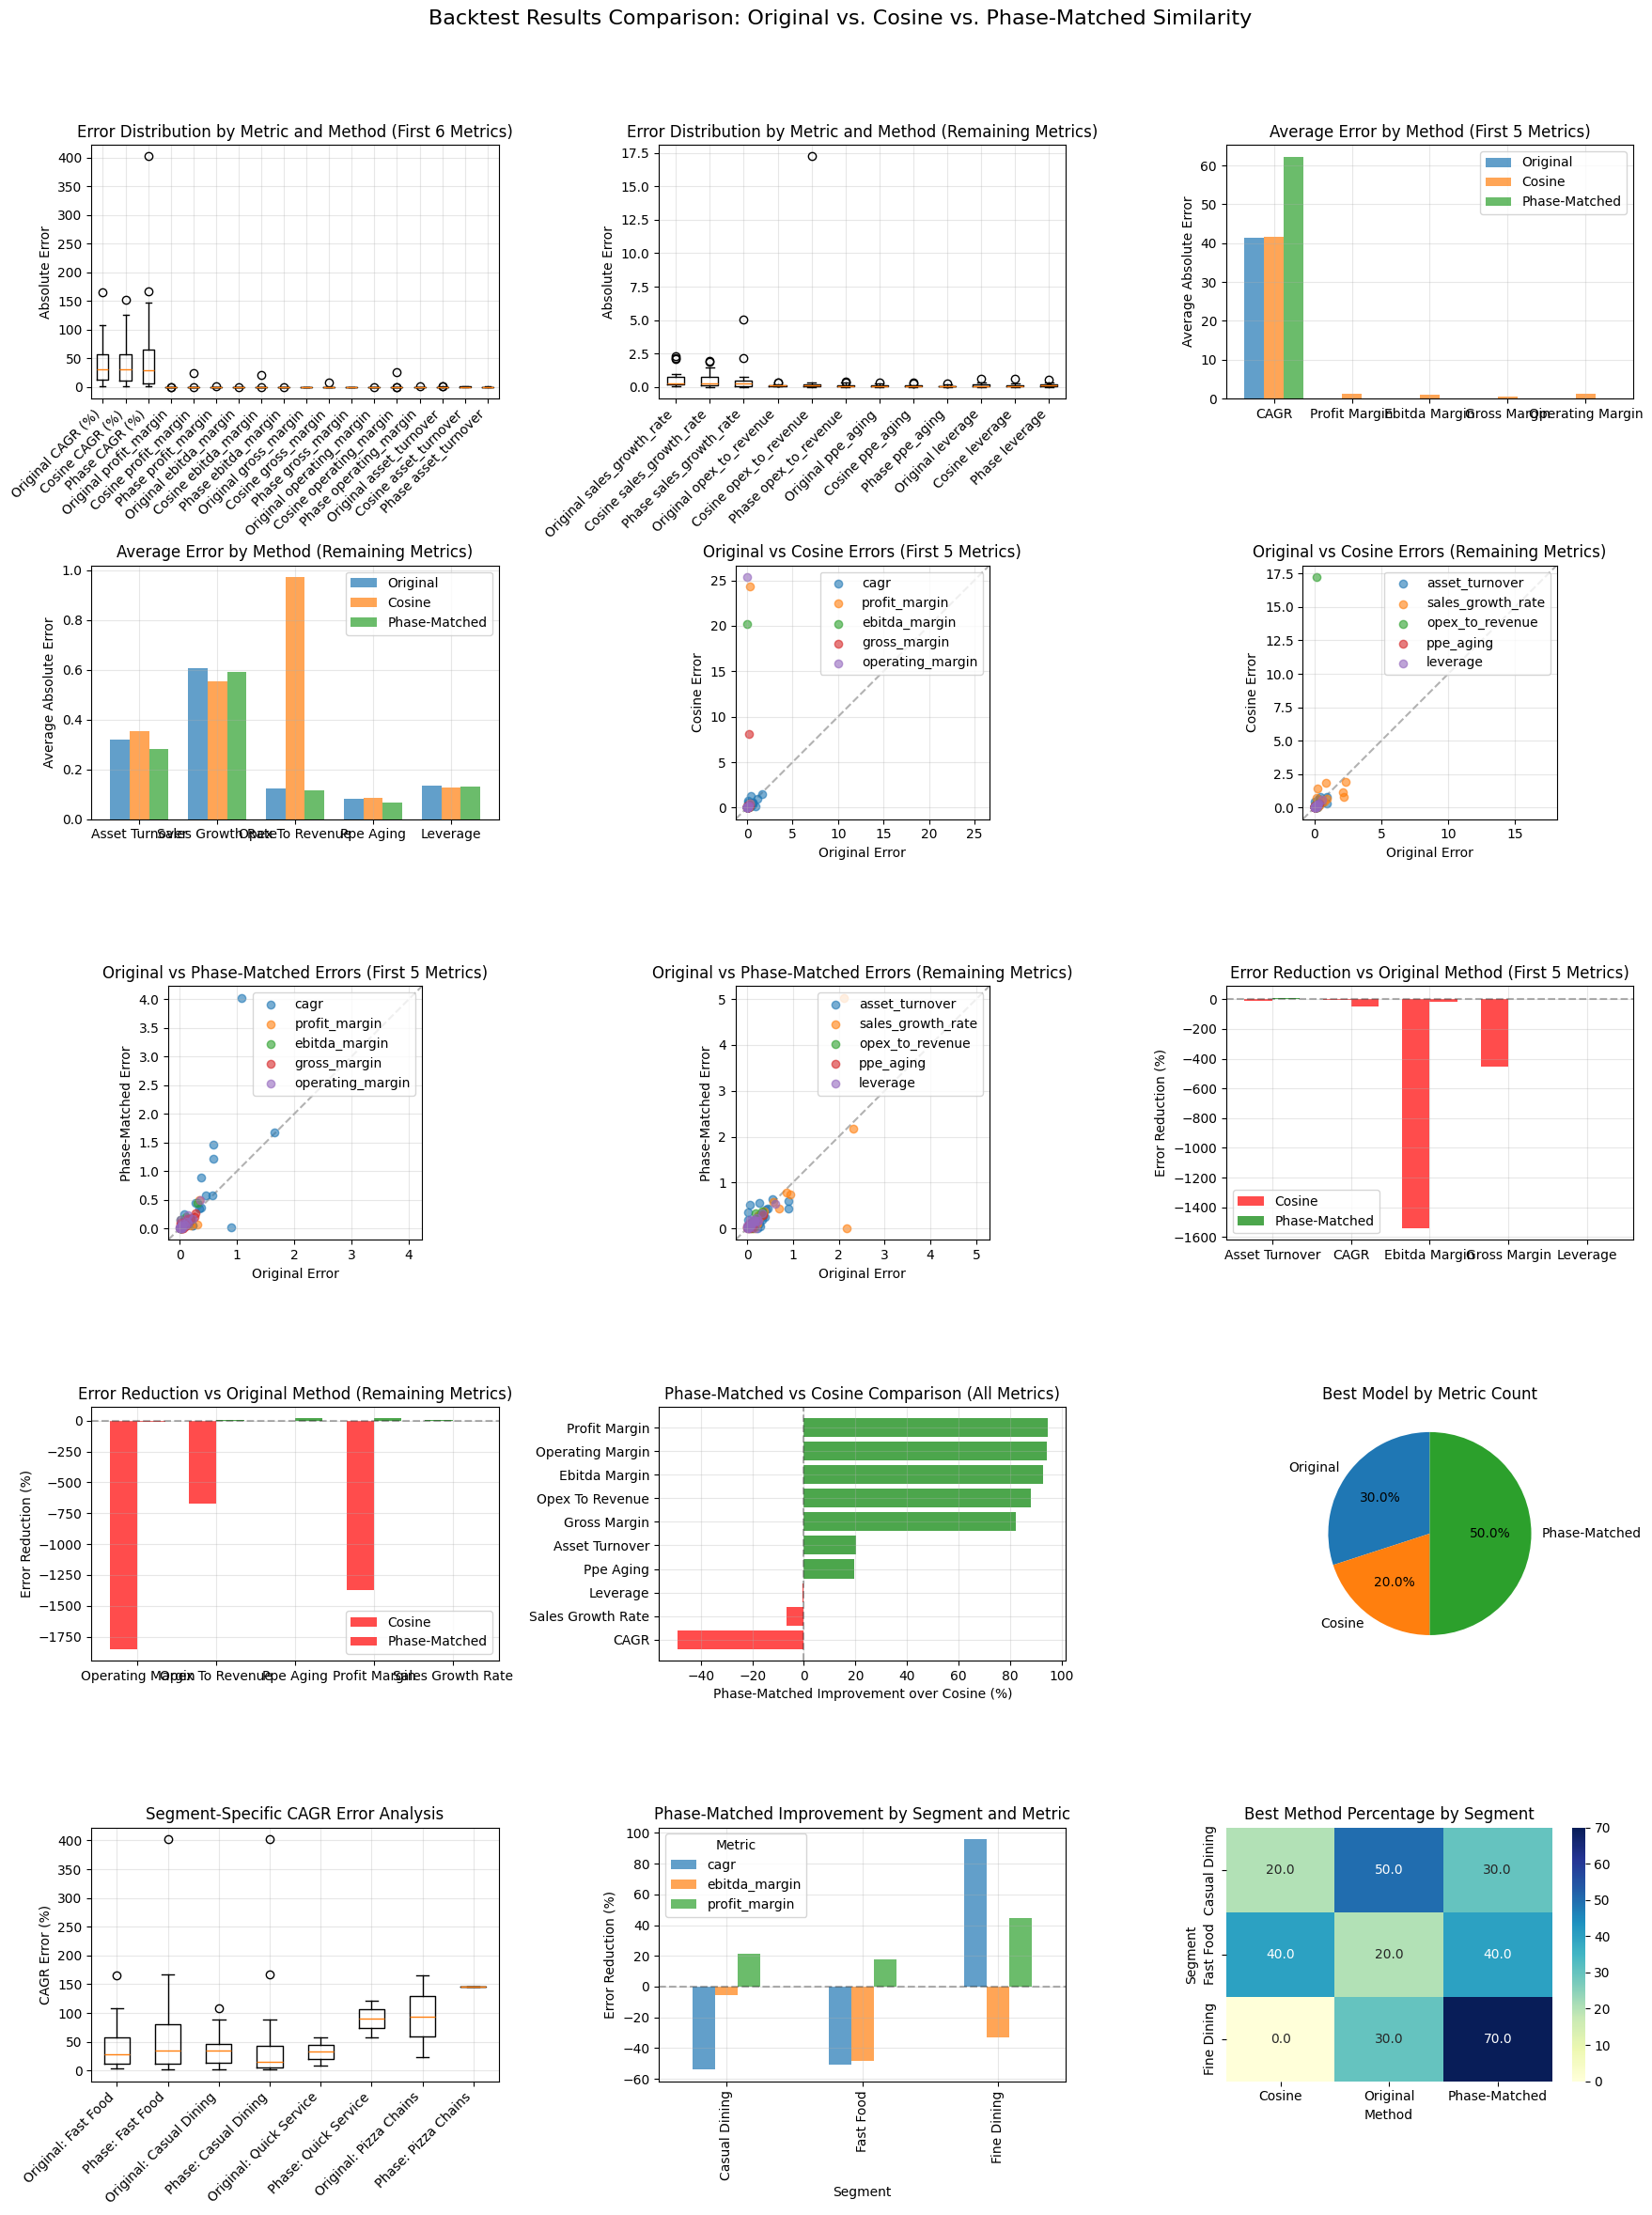



DETAILED MODEL COMPARISON WITH SEGMENT ANALYSIS

*** MODEL COMPARISON RESULTS ***

Average Errors by Model:

Growth Metrics:
CAGR: Original 41.4090%, Cosine 41.7447%, Phase-Matched 62.2455%
Sales Growth Rate: Original 0.6057, Cosine 0.5557, Phase-Matched 0.5931

Profitability Metrics:
Profit Margin: Original 0.0883, Cosine 1.2985, Phase-Matched 0.0706
Ebitda Margin: Original 0.0655, Cosine 1.0755, Phase-Matched 0.0757
Gross Margin: Original 0.0912, Cosine 0.5059, Phase-Matched 0.0897
Operating Margin: Original 0.0688, Cosine 1.3411, Phase-Matched 0.0760

Operational Metrics:
Asset Turnover: Original 0.3188, Cosine 0.3534, Phase-Matched 0.2817
Opex To Revenue: Original 0.1254, Cosine 0.9717, Phase-Matched 0.1148
Ppe Aging: Original 0.0836, Cosine 0.0850, Phase-Matched 0.0685
Leverage: Original 0.1359, Cosine 0.1287, Phase-Matched 0.1296

Error Improvement vs Original:

Growth Metrics:
Cagr: Cosine -0.81%, Phase-Matched -50.32%
Sales Growth Rate: Cosine 8.25%, Phase-Matched 2.08%

Prof

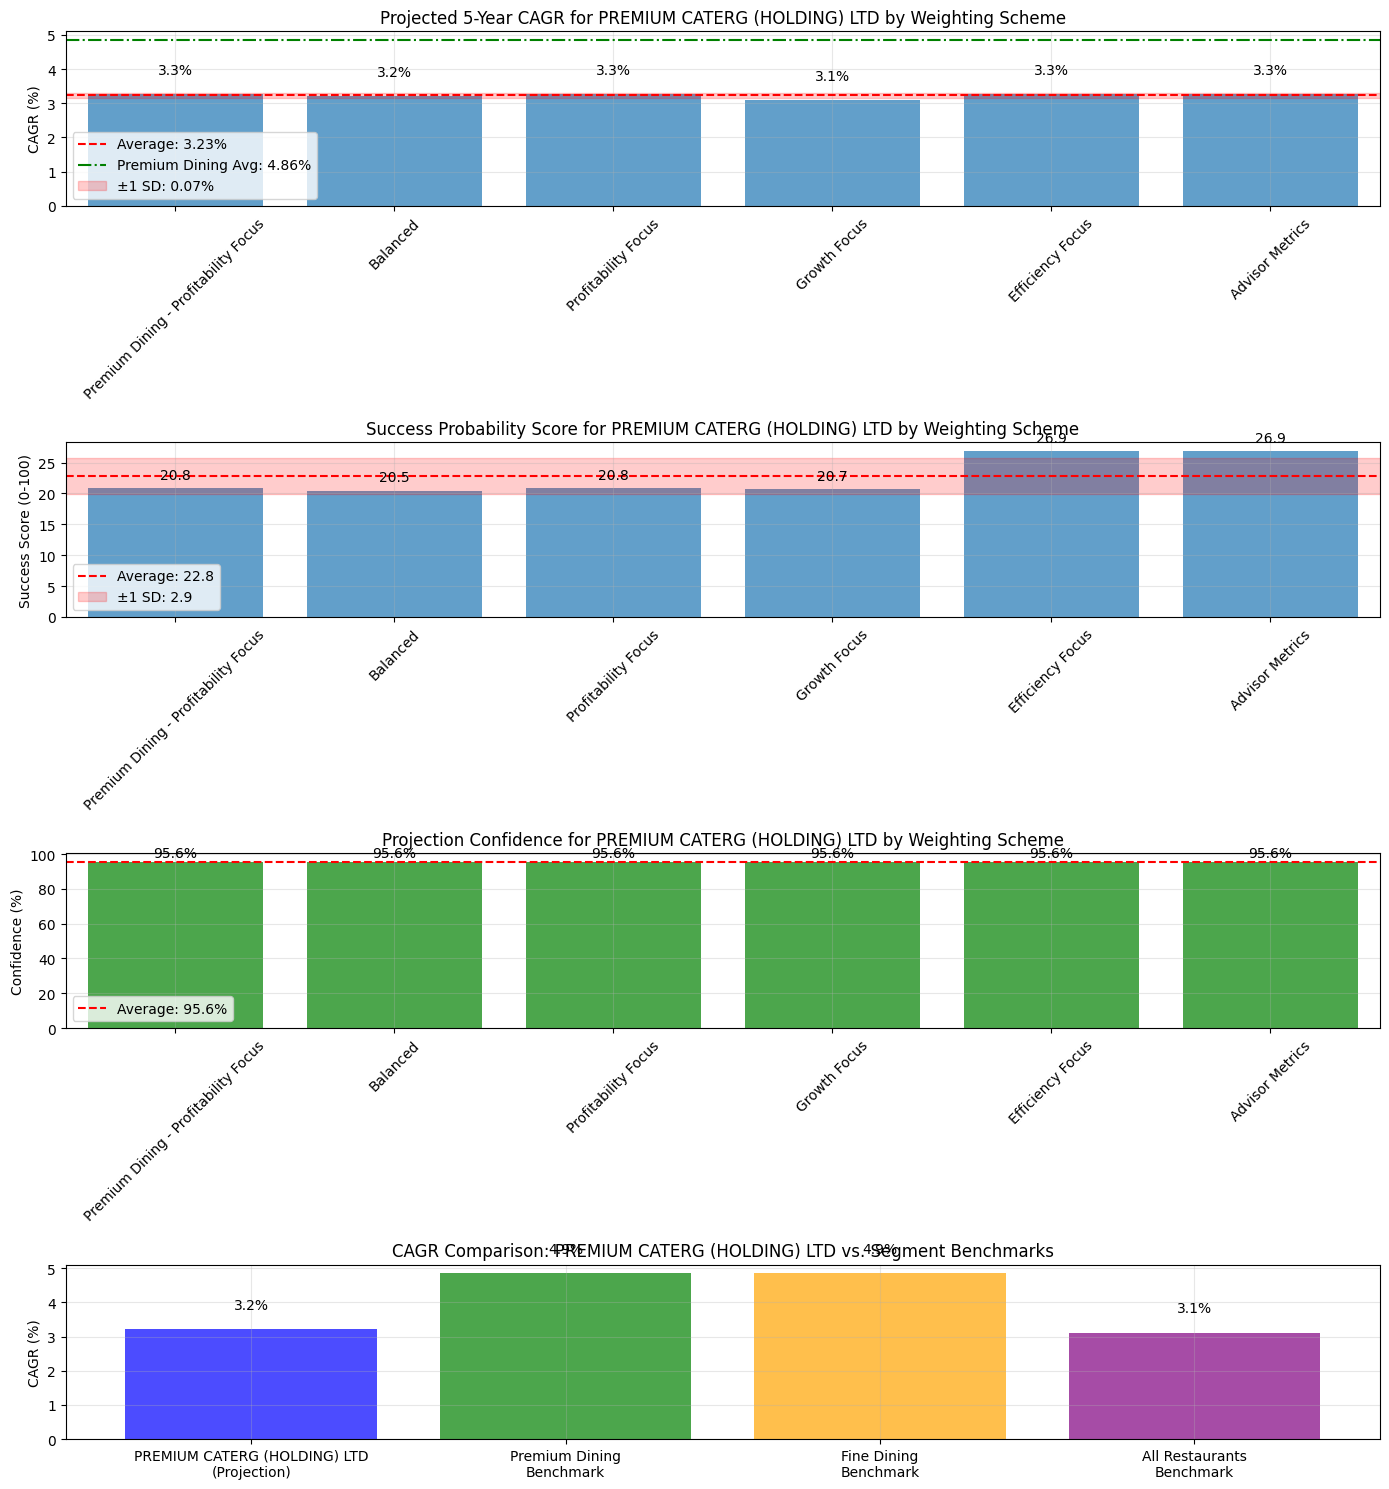

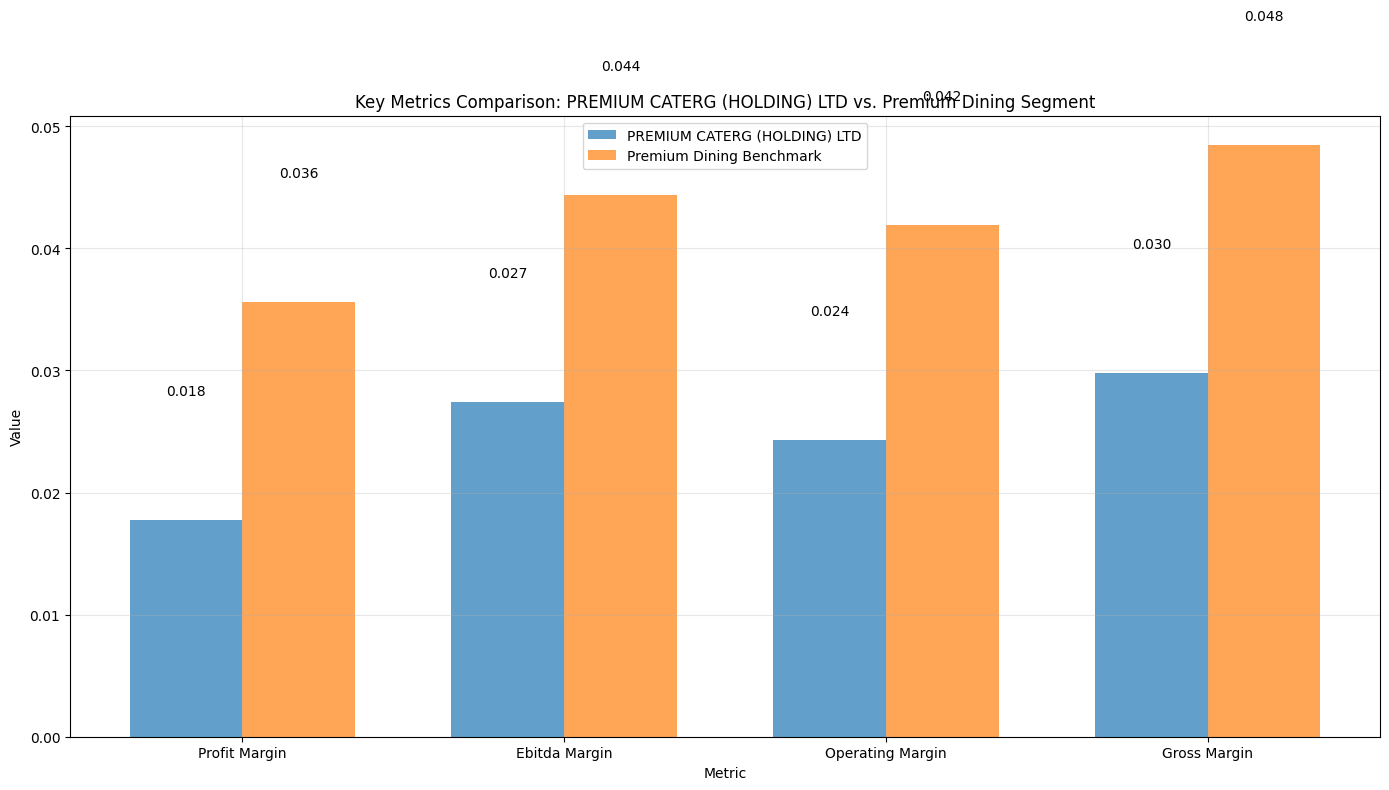


MOST SIMILAR COMPANIES BY SEGMENT:

Top similar companies from Premium Dining segment:
1. HOWARD JOHNSON CO - Score: 137.84 - Segment bonus: 1.2x - Window years: [1969, 1970, 1971]
   CAGR: 10.90%
2. RUTHS HOSPITALITY GROUP INC - Score: 137.67 - Segment bonus: 1.2x - Window years: [2019, 2020, 2021]
   CAGR: 5.52%
3. LONE STAR STEAKHOUSE SALOON - Score: 123.73 - Segment bonus: 1.2x - Window years: [1996, 1997, 1998]
   CAGR: 33.82%

Top similar companies from Quick Service segment:
1. O'CHARLEY'S INC - Score: 96.57
   CAGR: 16.51%
2. CKE RESTAURANTS INC - Score: 95.45
   CAGR: 6.37%

Top similar companies from Family Dining segment:
1. CRACKER BARREL OLD CTRY STOR - Score: 95.89
   CAGR: 14.39%


ANALYZING YOUNG COMPANY 2: CAVA GROUP INC
Segment: Quick Service (High-level: Fast Food)
Using cosine method based on segment-specific backtesting

Running cosine similarity analysis for young company: CAVA GROUP INC
Segment: Quick Service (High-level: Fast Food)
Years of data: 3
Last year: 2

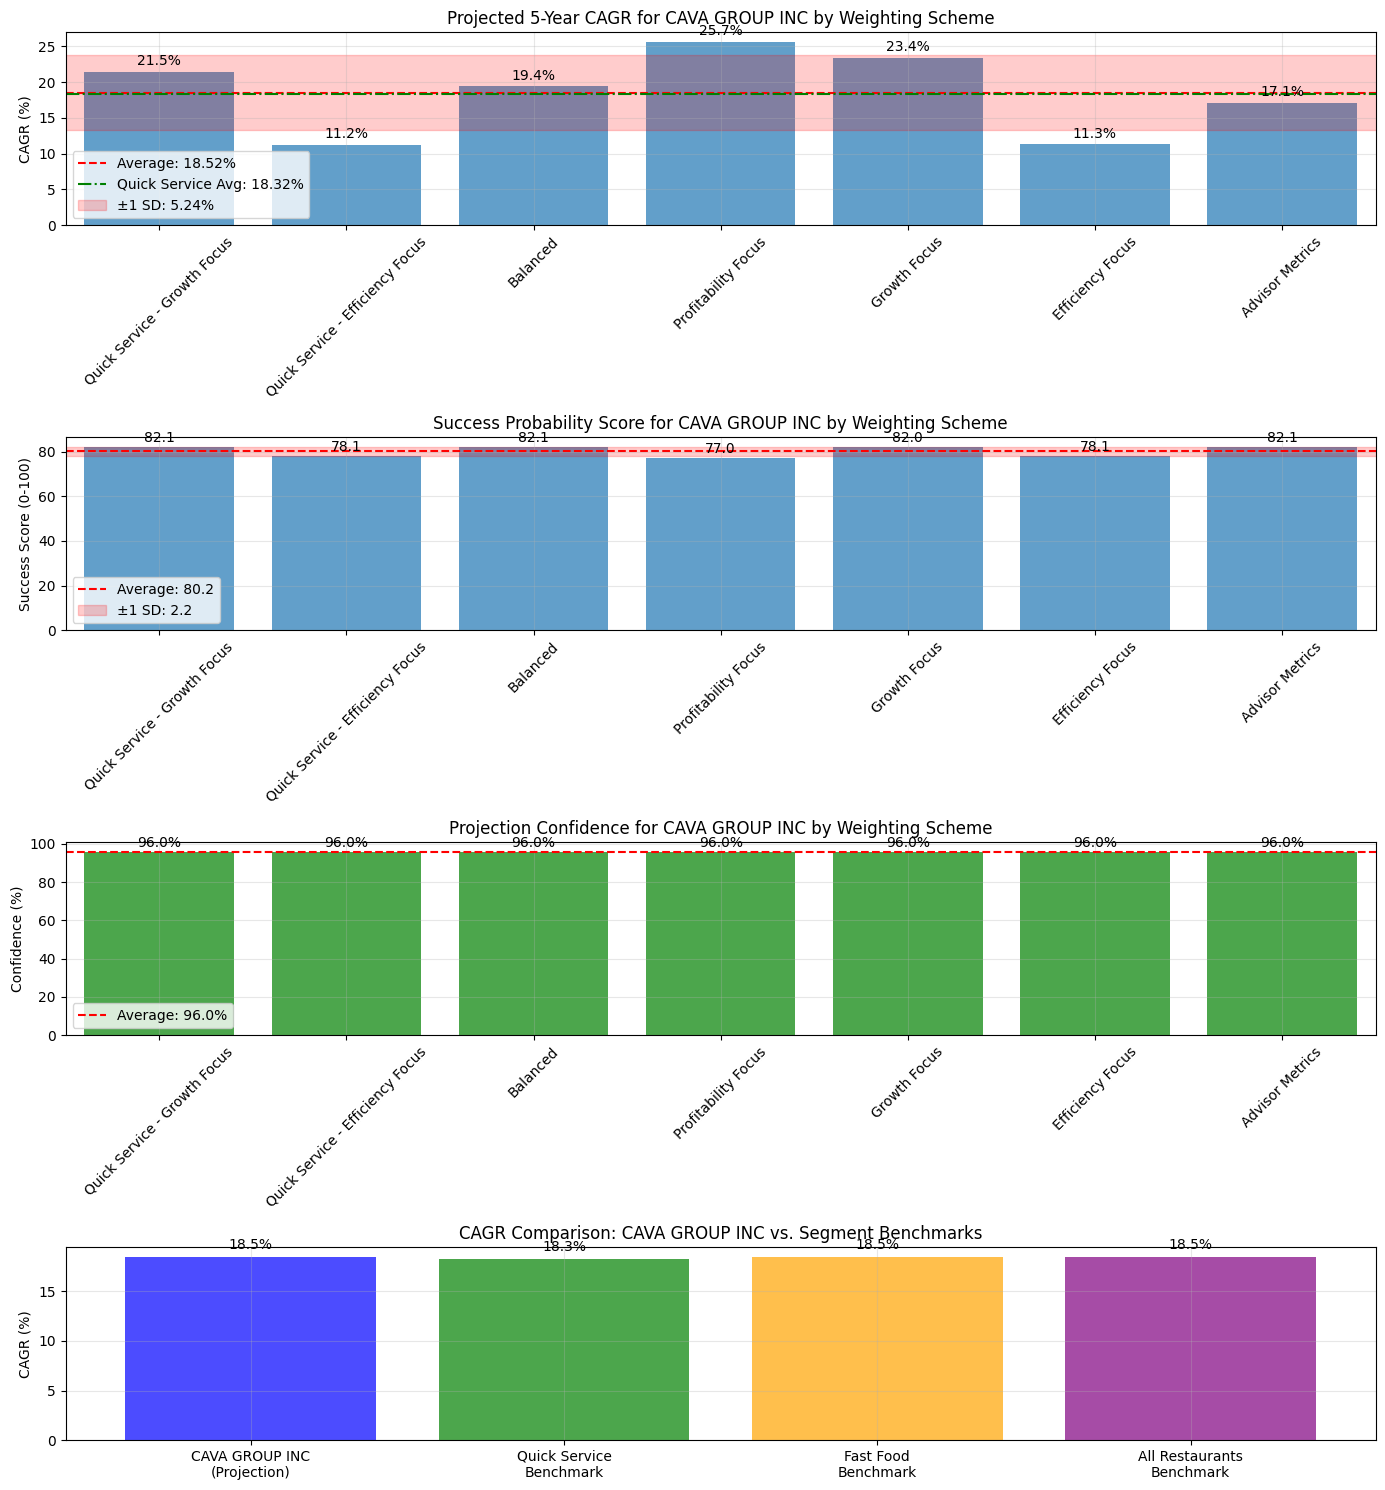

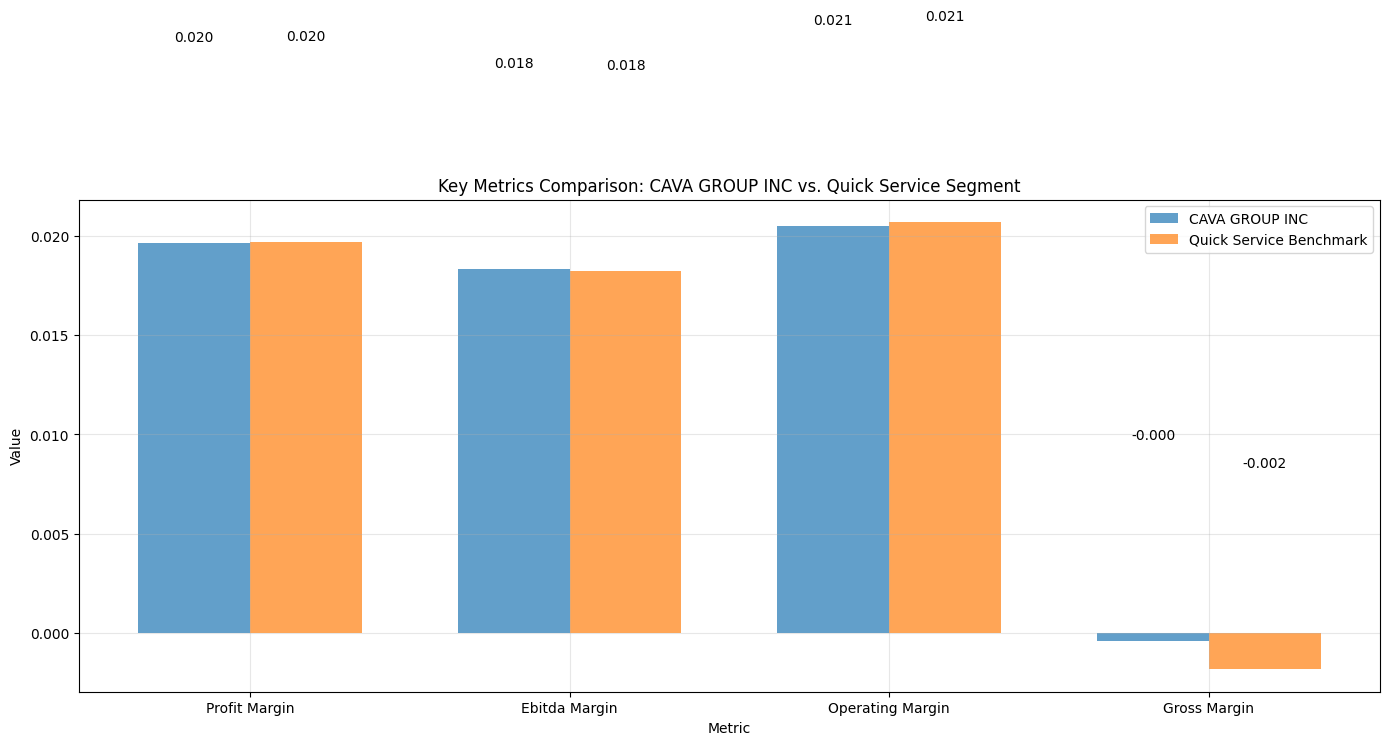


MOST SIMILAR COMPANIES BY SEGMENT:

Top similar companies from Quick Service segment:
1. TEXAS ROADHOUSE INC - Score: 115.79 - Segment bonus: 1.2x
   CAGR: 15.30%
2. RARE HOSPITALITY INTL INC - Score: 115.68 - Segment bonus: 1.2x
   CAGR: 24.03%
3. BUFFETS HOLDINGS INC - Score: 110.72 - Segment bonus: 1.2x
   CAGR: 29.71%

Top similar companies from Pizza Chains segment:
1. BUFFALO WILD WINGS INC - Score: 100.46
   CAGR: 24.46%


ANALYZING YOUNG COMPANY 3: YOSHIHARU GLOBAL CO
Segment: Ethnic Restaurants (High-level: Casual Dining)
Using original method based on segment-specific backtesting

Running original similarity analysis for young company: YOSHIHARU GLOBAL CO
Segment: Ethnic Restaurants (High-level: Casual Dining)
Years of data: 4
Last year: 2023
Using 1 segment-specific schemes and 5 general schemes

*** Weight Scheme: Ethnic Restaurants - Growth Focus ***
Analyzing 6 companies from the same segment and 88 from other segments
Top 5 similar companies (Ethnic Restaurants - Growth

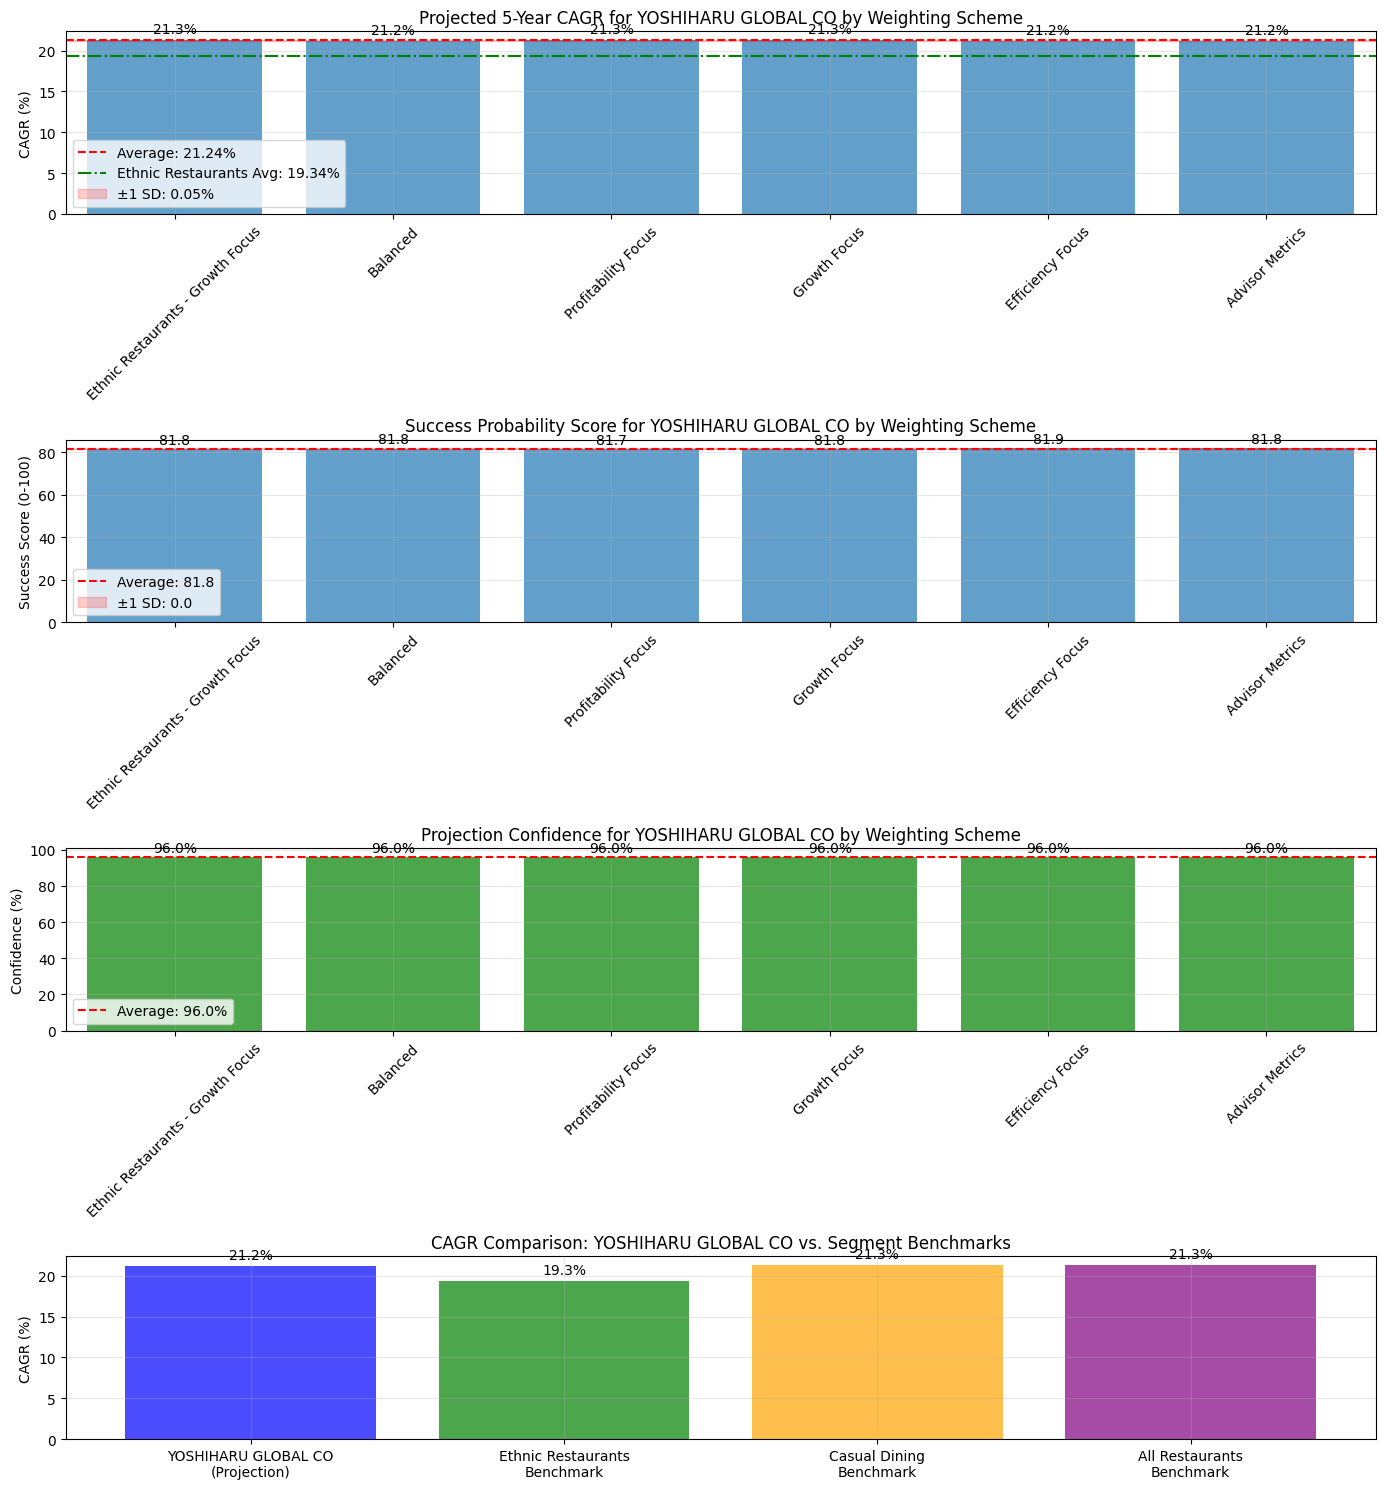

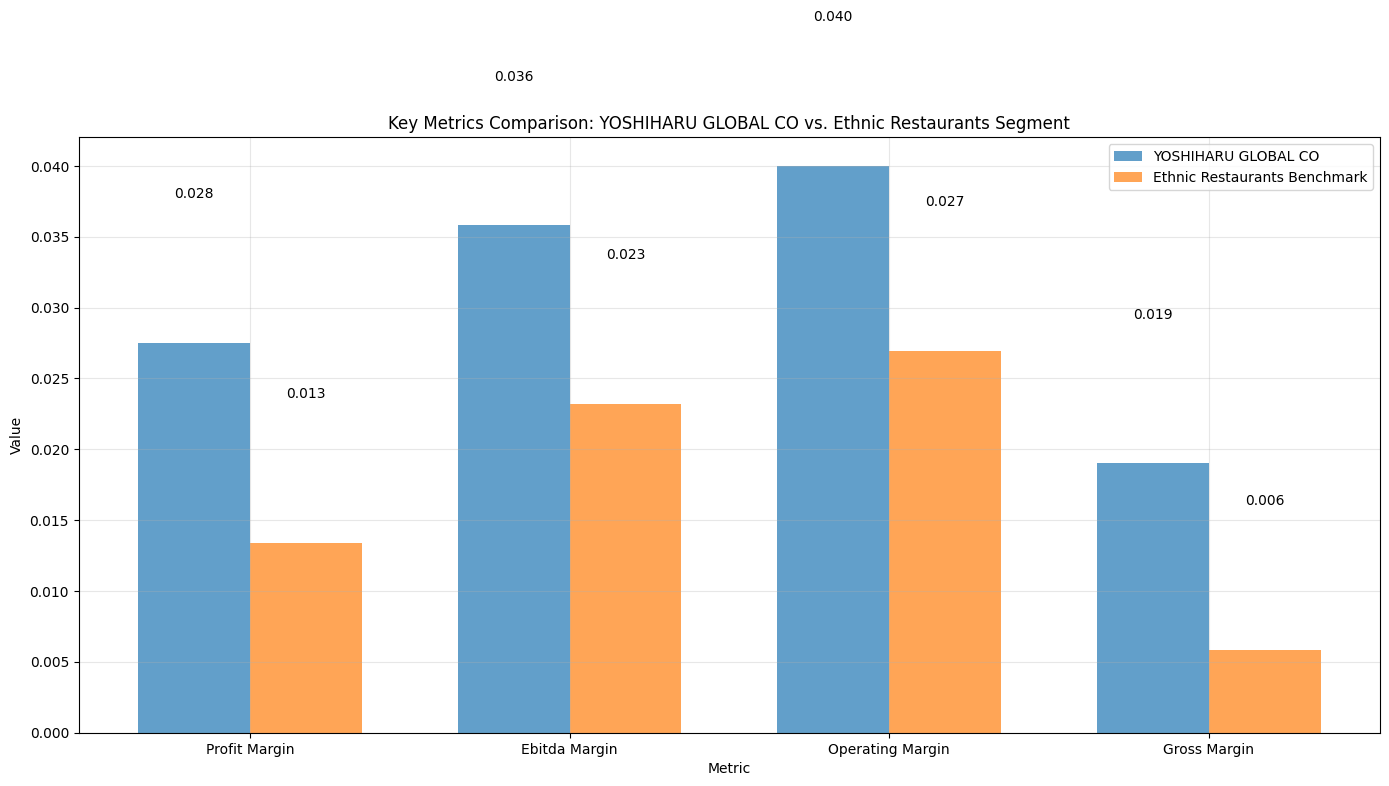


MOST SIMILAR COMPANIES BY SEGMENT:

Top similar companies from Ethnic Restaurants segment:
1. P F CHANGS CHINA BISTRO INC - Score: 102.89 - Segment bonus: 1.2x
   CAGR: 27.84%
2. BENIHANA INC - Score: 100.03 - Segment bonus: 1.2x
   CAGR: 10.83%

Top similar companies from Family Dining segment:
1. CRACKER BARREL OLD CTRY STOR - Score: 94.77
   CAGR: 14.39%
2. SPARTAN FOOD SYSTEMS INC - Score: 93.29
   CAGR: 40.89%

Top similar companies from Bar & Grill segment:
1. SKYLINE CHILI INC - Score: 93.13
   CAGR: 12.60%


ANALYSIS COMPLETE


In [22]:
# Run the full analysis pipeline if this script is executed directly
if __name__ == "__main__":
    run_analysis_pipeline()